# Classification

In [2]:
import experiments.nns.simplenet.simplenet
from experiments.nns.simplenet.simplenet import SimpleNet
import torch.optim as optim
import torch.nn as nn


model = SimpleNet(num_classes=10, in_chans= 1, scale=1, network_idx=1, mode=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [73]:
import torch
import copy
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



notebook_directory = os.path.dirname(os.path.abspath("deep_ensemble_mnist.ipynb"))
# Navigate to the parent folder (assuming "usr" and "home" are at the same level)
parent_directory = os.path.abspath(os.path.join(notebook_directory, "..","..","..","..","..","..",".."))

# Construct the path to the ImageNet directory
mnist_directory = os.path.abspath(os.path.join(parent_directory, "/usr/data1/vision/data/"))

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

transform_rotation=transforms.Compose([
    transforms.RandomRotation(degrees=(-180, 180), fill=(0,)),
    transforms.ToTensor(),
])


# Load the MNIST training dataset
train_dataset = datasets.MNIST(root=mnist_directory, train=True, download=False, transform=transform)
rotated_train_dataset = datasets.MNIST(root=mnist_directory, train=True, download=False, transform=transform_rotation)

# Load the MNIST test dataset
test_dataset = datasets.MNIST(root=mnist_directory, train=False, download=False, transform=transform)
rotated_test_dataset = datasets.MNIST(root=mnist_directory, train=False, download=False, transform=transform_rotation)

# # Select 1/10 samples of each class for both train and test datasets
# train_subset_indices = []
# test_subset_indices = []

# for c in range(10):
#     class_indices = [i for i in range(len(train_dataset)) if train_dataset[i][1] == c]
#     train_subset_indices.extend(class_indices[:len(class_indices)//10])
    
#     class_indices = [i for i in range(len(test_dataset)) if test_dataset[i][1] == c]
#     test_subset_indices.extend(class_indices[:len(class_indices)//10])

# Create the subset with 1/10th of the original size for each class
# train_subset = torch.utils.data.Subset(train_dataset, train_subset_indices)
# rotated_train_subset = torch.utils.data.Subset(rotated_train_dataset, train_subset_indices)


# # Save the subset indices inside mnist_directory
train_idx_path = os.path.join(mnist_directory, "train_indices.pth")
# rotated_idx_sub_path = os.path.join(mnist_directory, "rotated_train_indices.pth")
test_idx_path = os.path.join(mnist_directory, "test_indices.pth")
# rotated_test_idx_sub_path = os.path.join(mnist_directory, "rotated_test_indices.pth")
# torch.save(train_subset_indices, train_idx_path)
# torch.save(train_subset_indices, rotated_idx_sub_path)
# torch.save(test_subset_indices, test_idx_path)


# Load the subset indices from mnist_directory
loaded_train_indices = torch.load(train_idx_path)
loaded_rotated_train_indices = torch.load(train_idx_path)
loaded_test_indices = torch.load(test_idx_path)
loaded_rotated_test_indices = torch.load(test_idx_path)

# Create the subset using the loaded indices
loaded_train_subset = torch.utils.data.Subset(train_dataset, loaded_train_indices)
rotated_loaded_train_subset = torch.utils.data.Subset(rotated_train_dataset, loaded_rotated_train_indices)
loaded_test_subset = torch.utils.data.Subset(test_dataset, loaded_test_indices)
rotated_loaded_test_subset = torch.utils.data.Subset(rotated_test_dataset, loaded_test_indices)

In [40]:

train_loader = DataLoader(loaded_train_subset, batch_size=1, shuffle=False)
# Alternatively, you can use DataLoader to iterate over the dataset
rotated_train_loader = DataLoader(rotated_loaded_train_subset, batch_size=1, shuffle=False)
for images, labels in rotated_train_loader:
    rotated_image = images[0]
    rotated_label = labels[0]
    break  # Break after the first iteration to get a single example

for images, labels in train_loader:
    original_image = images[0]
    original_label = labels[0]
    break  # Break after the first iteration to get a single example


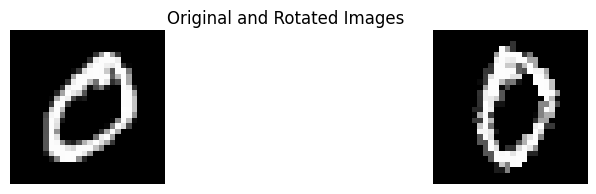

In [41]:
# import matplotlib.pyplot as plt

# # Function to display a grid of images
# def show_images(images, title):
#     plt.figure(figsize=(10, 2))
#     for i in range(len(images)):
#         plt.subplot(1, len(images), i + 1)
#         plt.imshow(images[i].numpy().squeeze(), cmap='gray')
#         plt.axis('off')
#     plt.suptitle(title)
#     plt.show()


# show_images([original_image, rotated_image], title='Original and Rotated Images')


In [74]:
# Create data loaders
batch_size = 128
train_loader = DataLoader(loaded_train_subset, batch_size=batch_size, shuffle=True)
rotated_train_loader = DataLoader(rotated_loaded_train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(loaded_test_subset, batch_size=512, shuffle=False)
rotated_test_loader = DataLoader(rotated_loaded_test_subset, batch_size=512, shuffle=False)

In [45]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble

epochs = 2
two_particle_ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.CrossEntropyLoss(),
        epochs,
        SimpleNet, 10, 1, 1, 1, 2,
        num_devices=2,
        num_ensembles=2,
    )

100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


In [50]:
two_model_outputs = two_particle_ensemble.posterior_pred(test_loader,f_reg=False, mode=["mode","std","mean_prob"])
rotated_two_model_outputs = two_particle_ensemble.posterior_pred(rotated_test_loader,f_reg=False, mode=["mode","std","mean_prob"])

In [16]:
two_model_outputs["mode"]

tensor([7, 2, 1,  ..., 4, 5, 6])

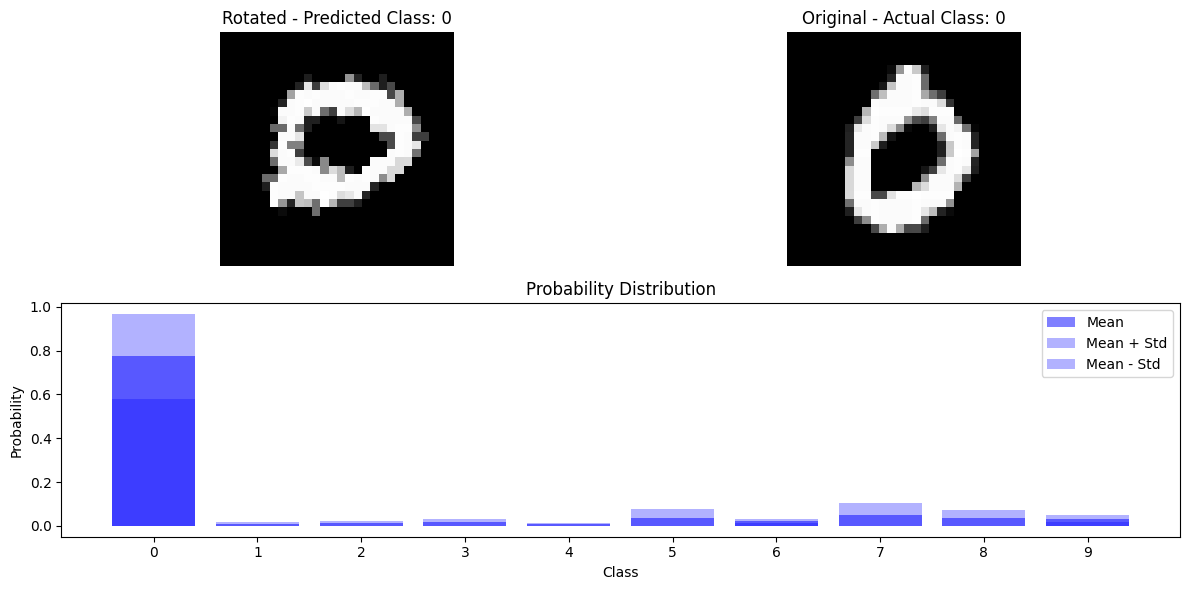

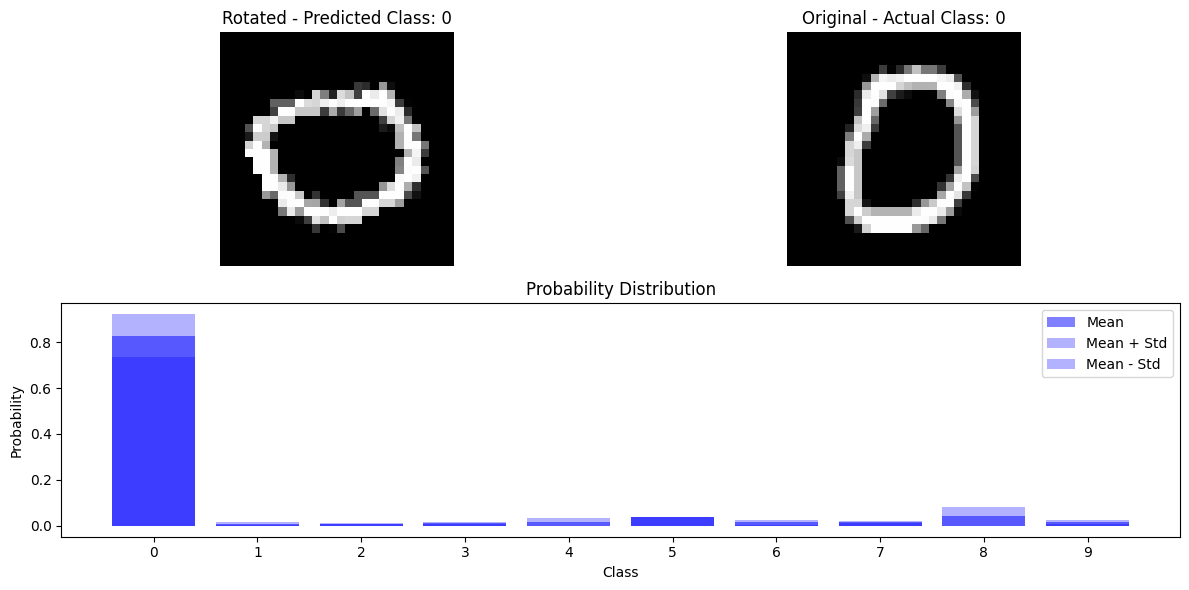

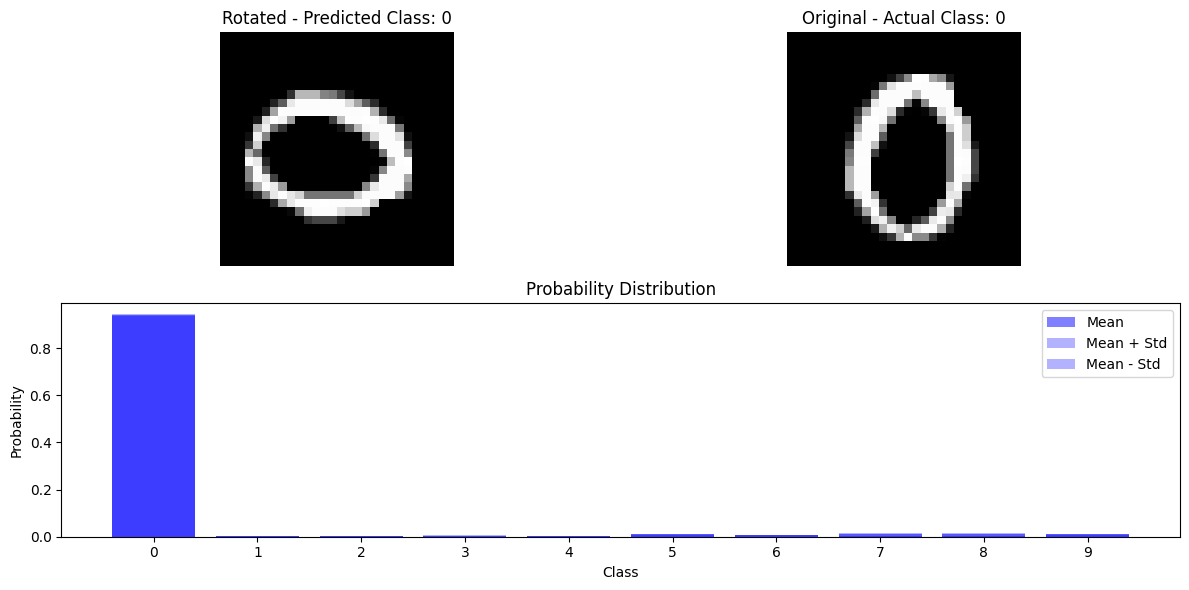

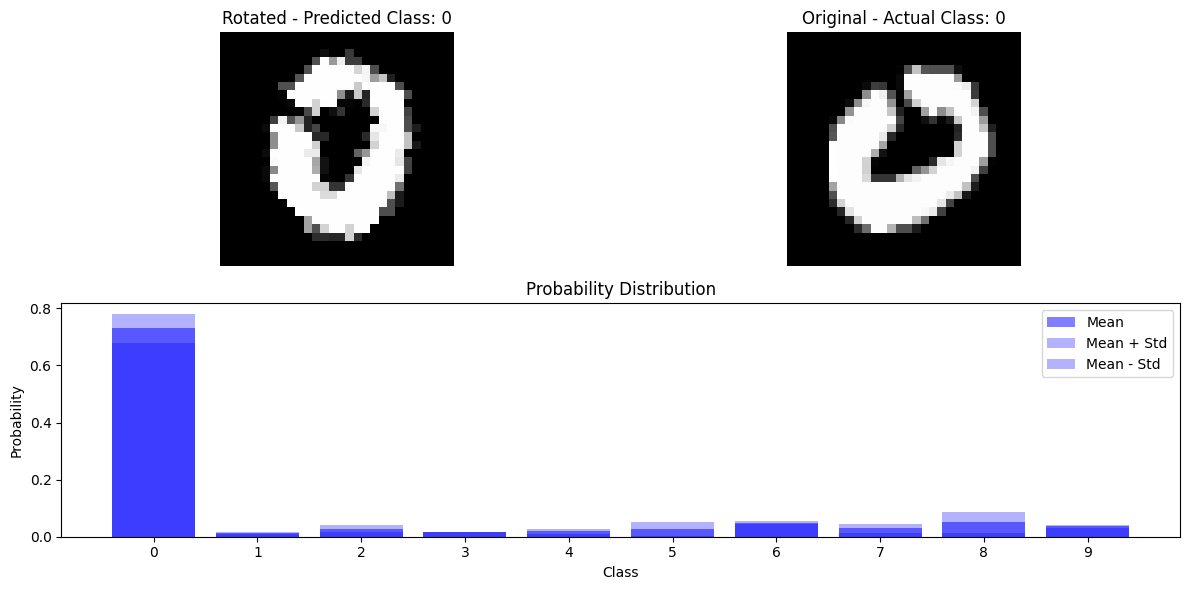

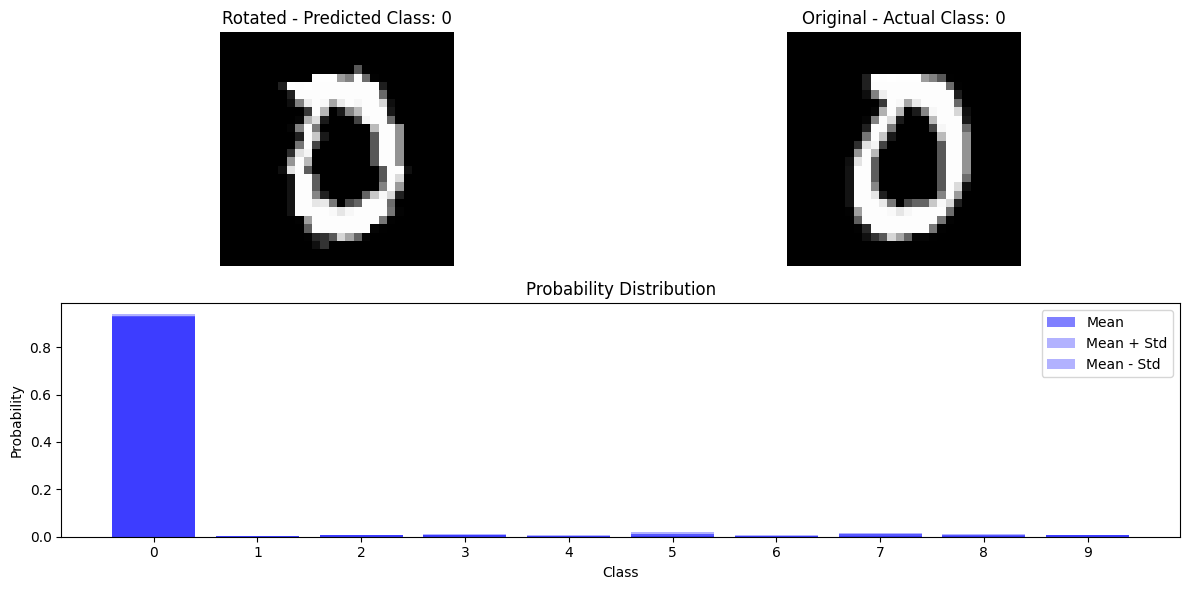

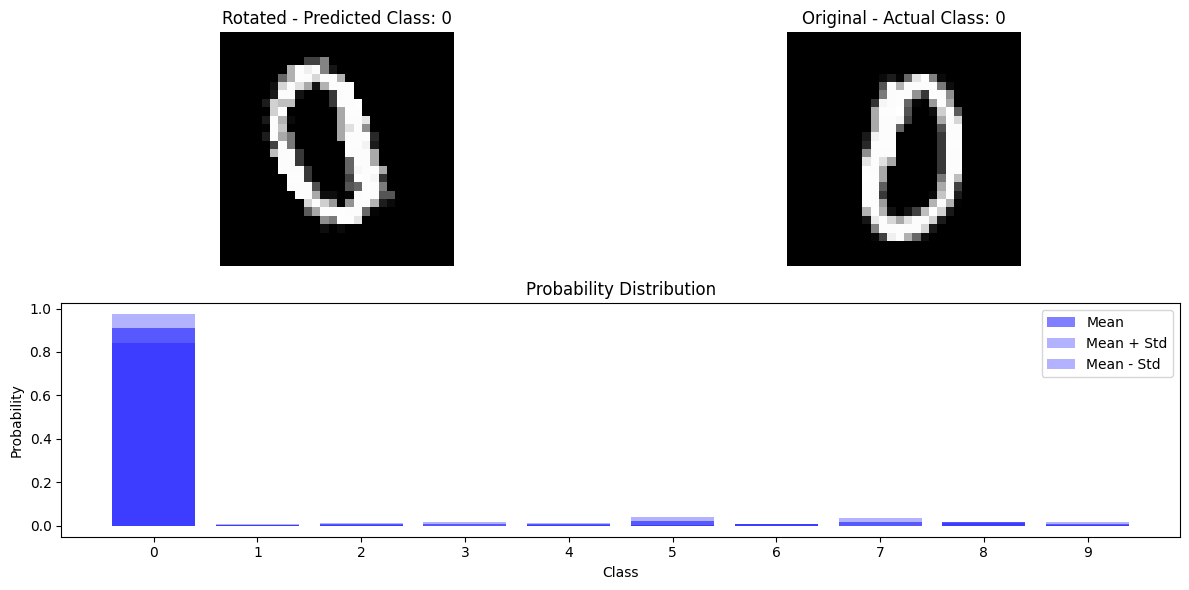

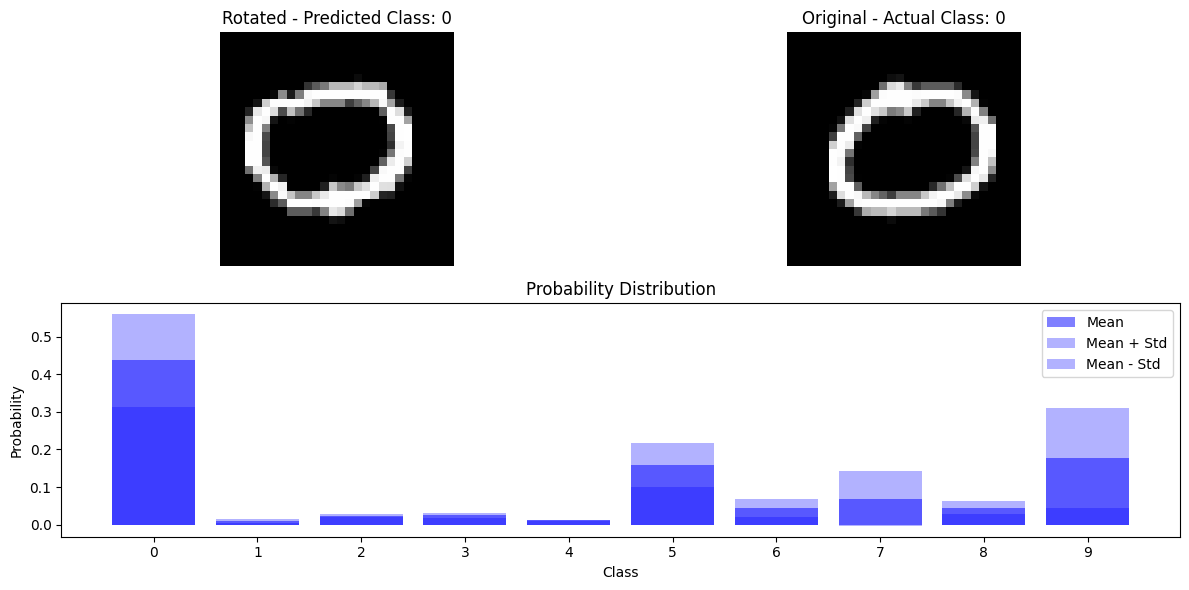

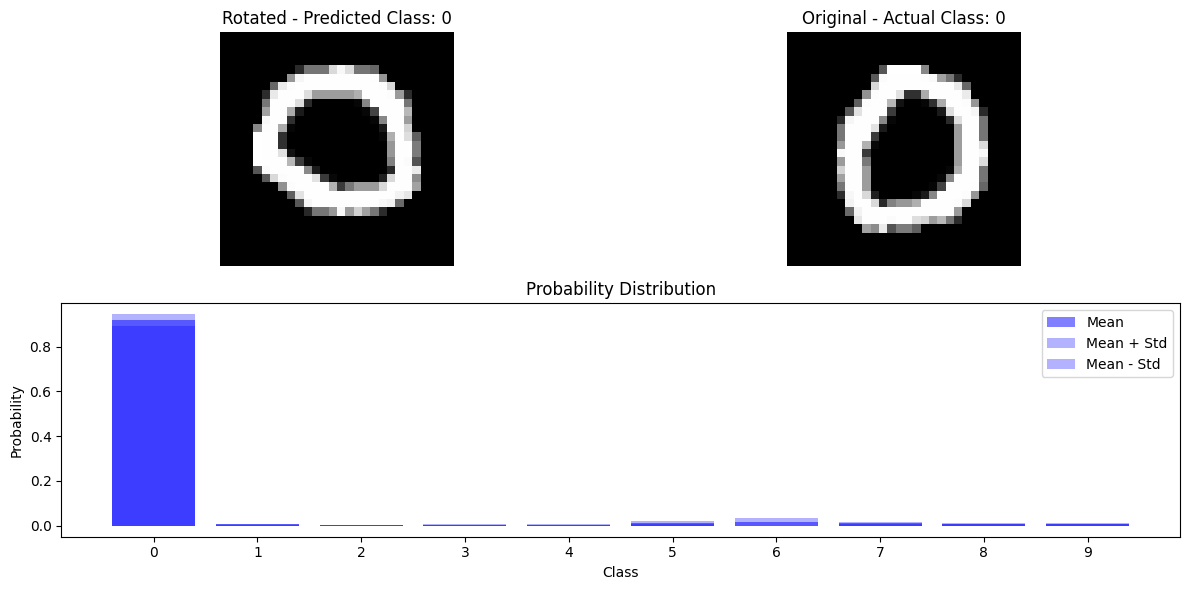

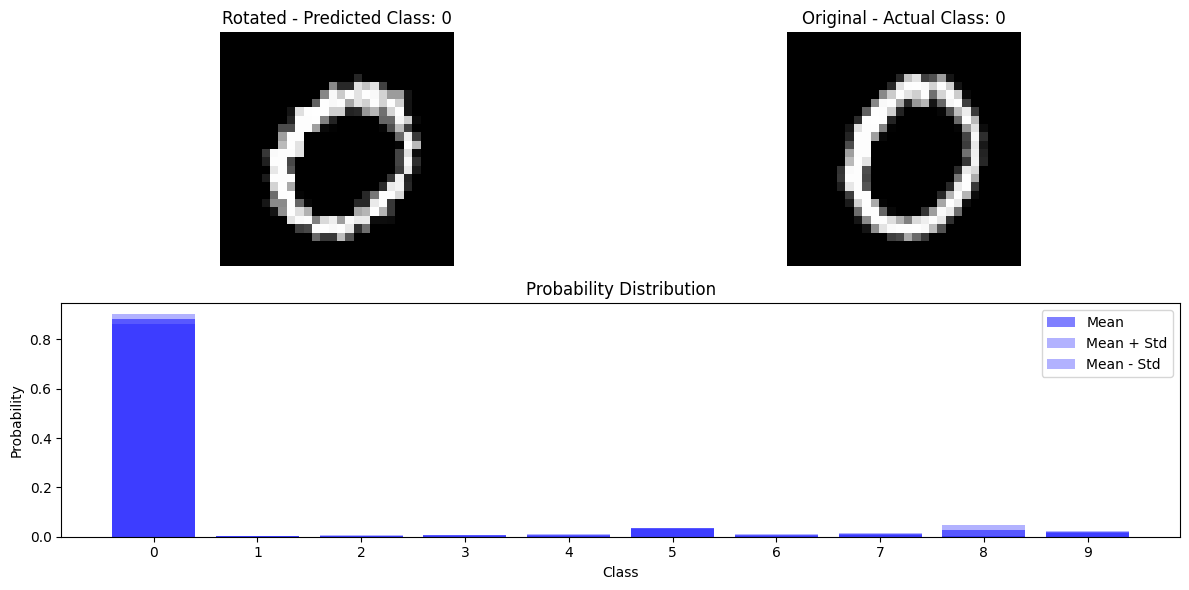

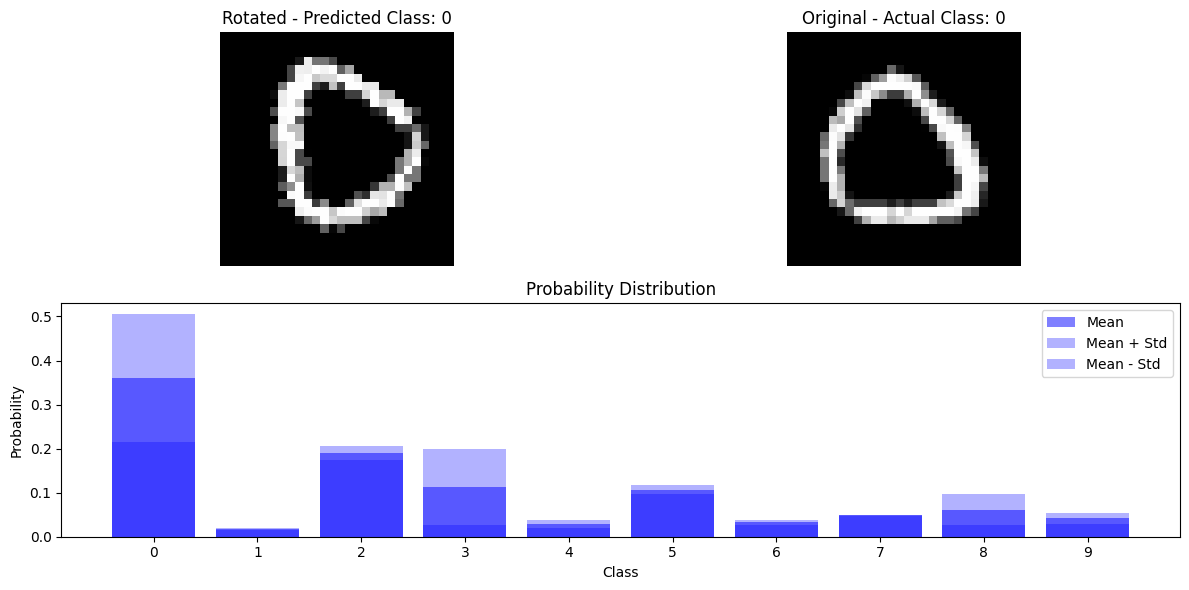

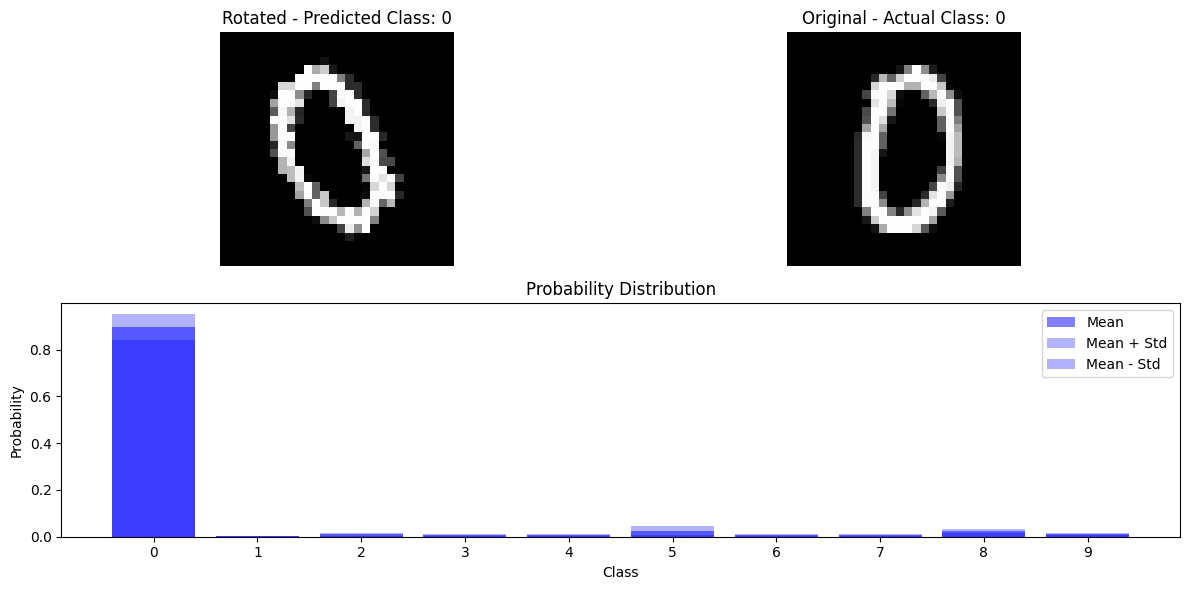

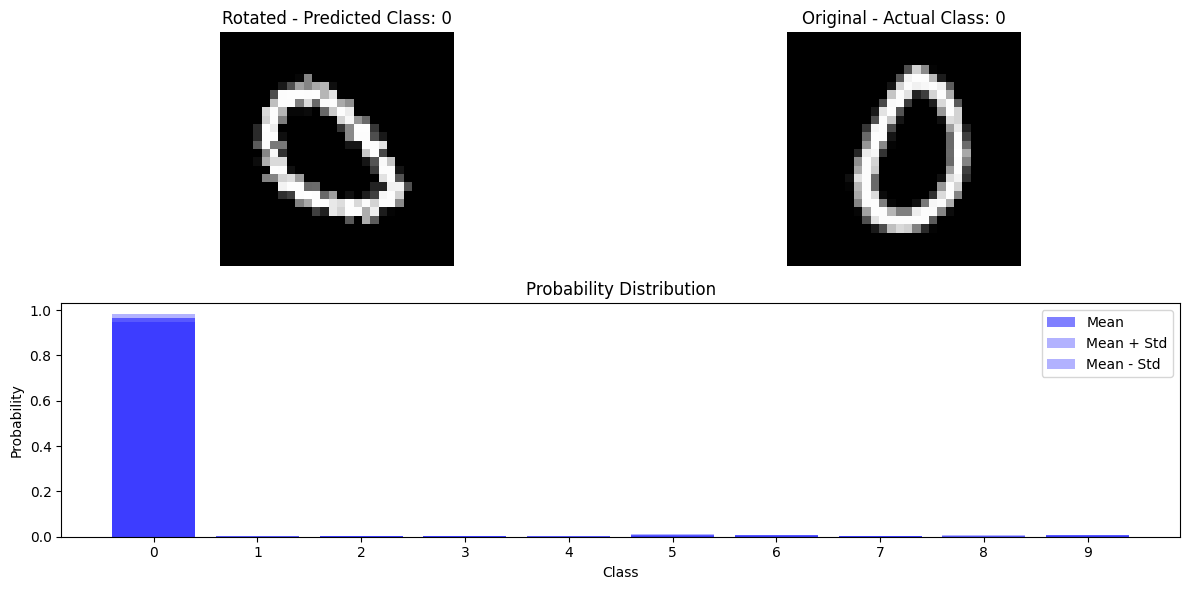

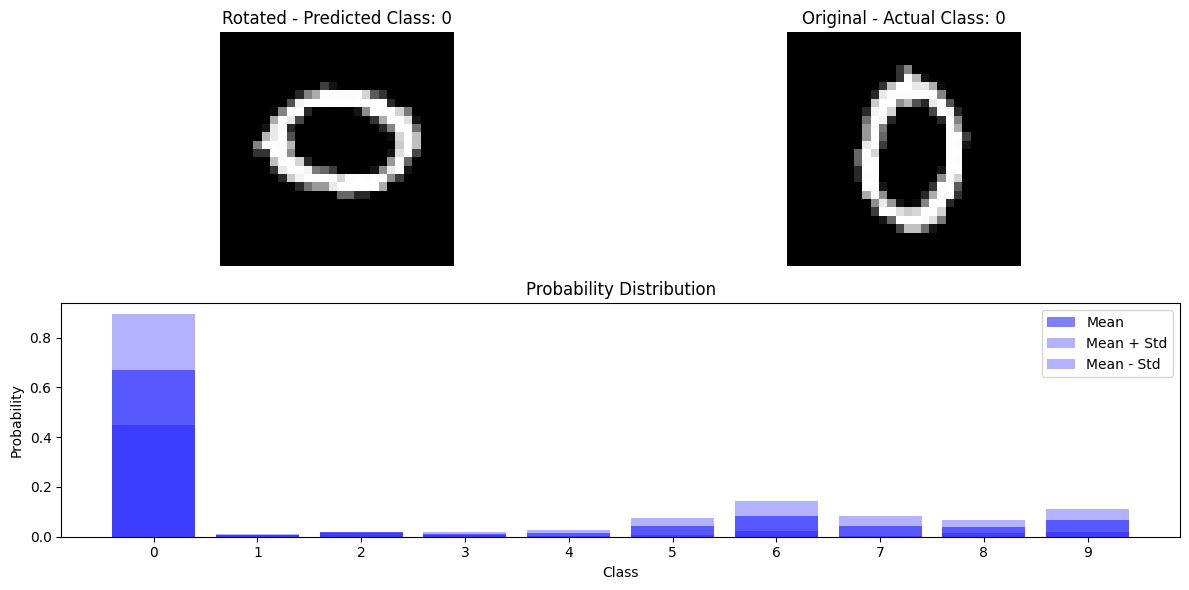

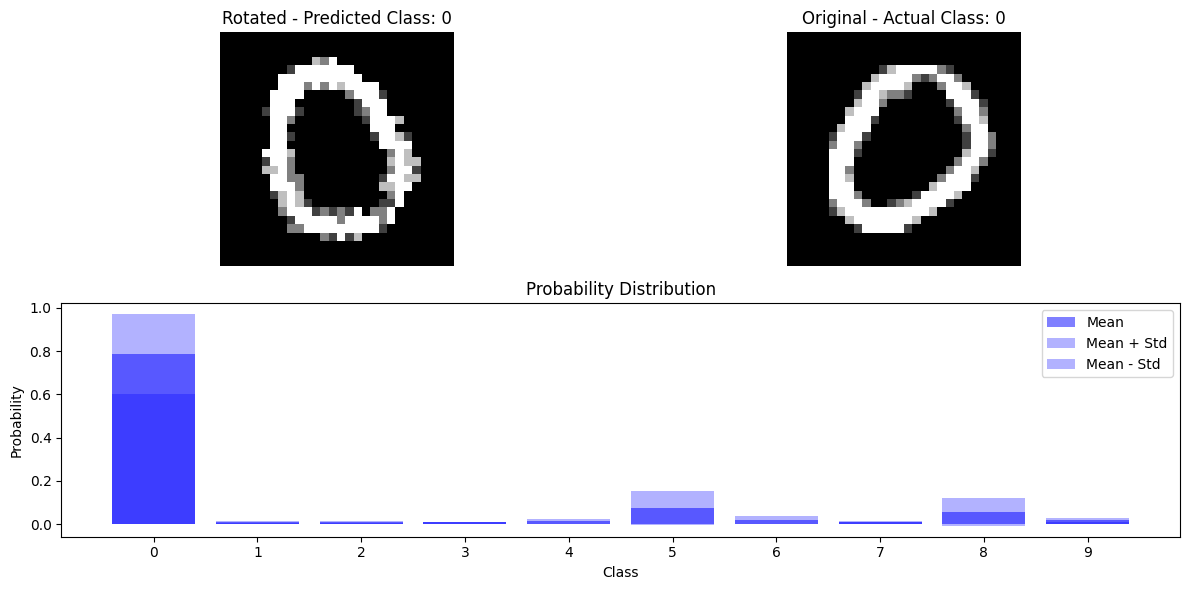

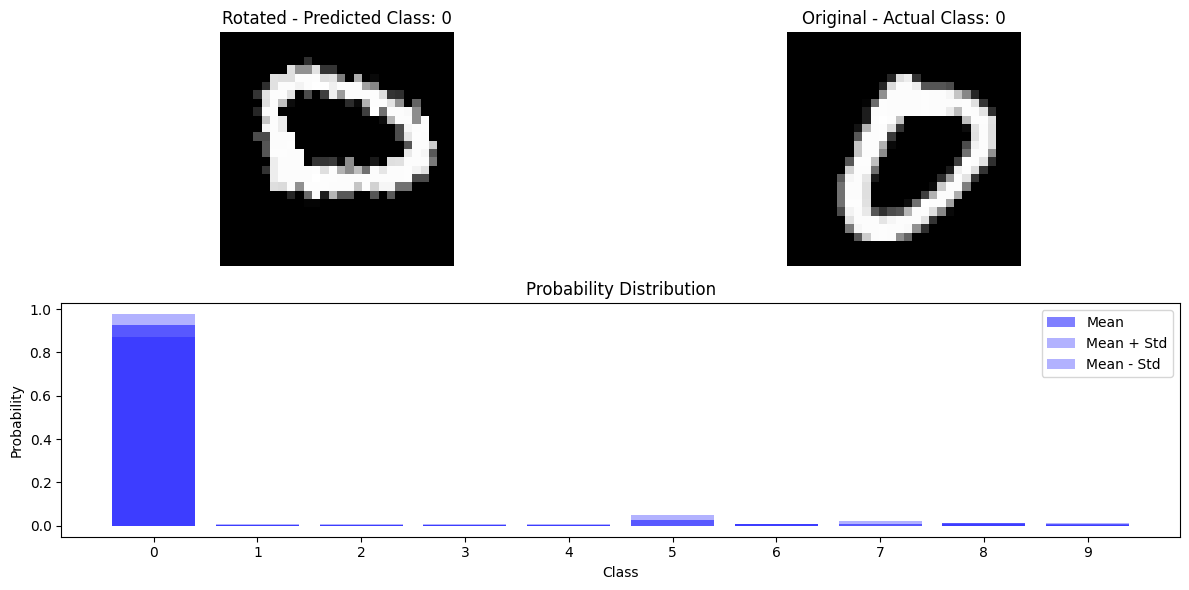

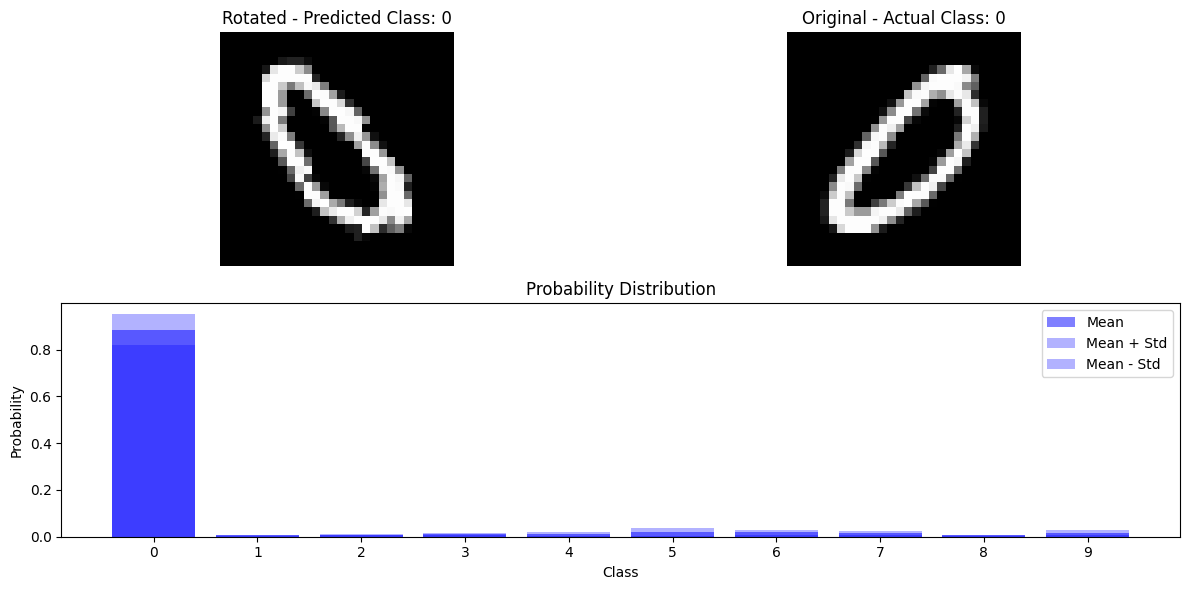

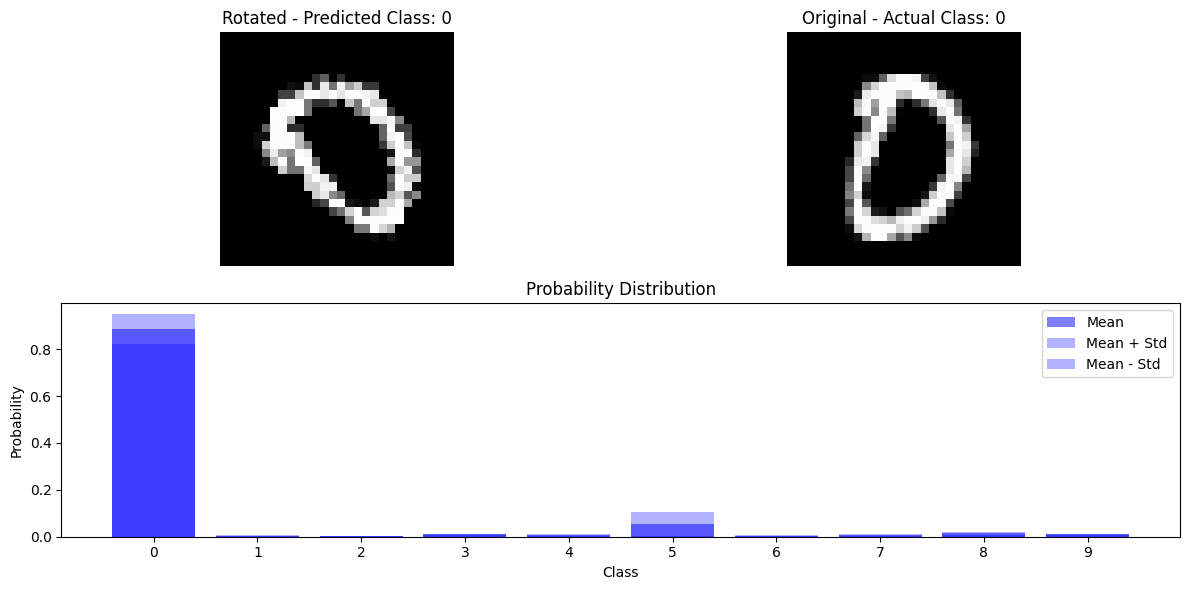

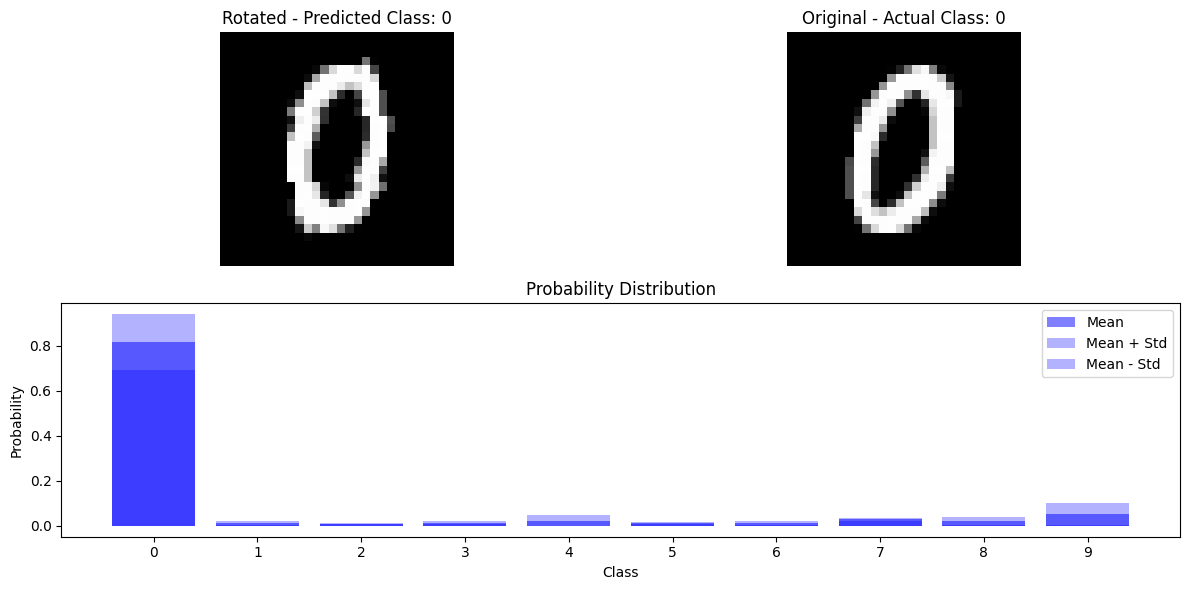

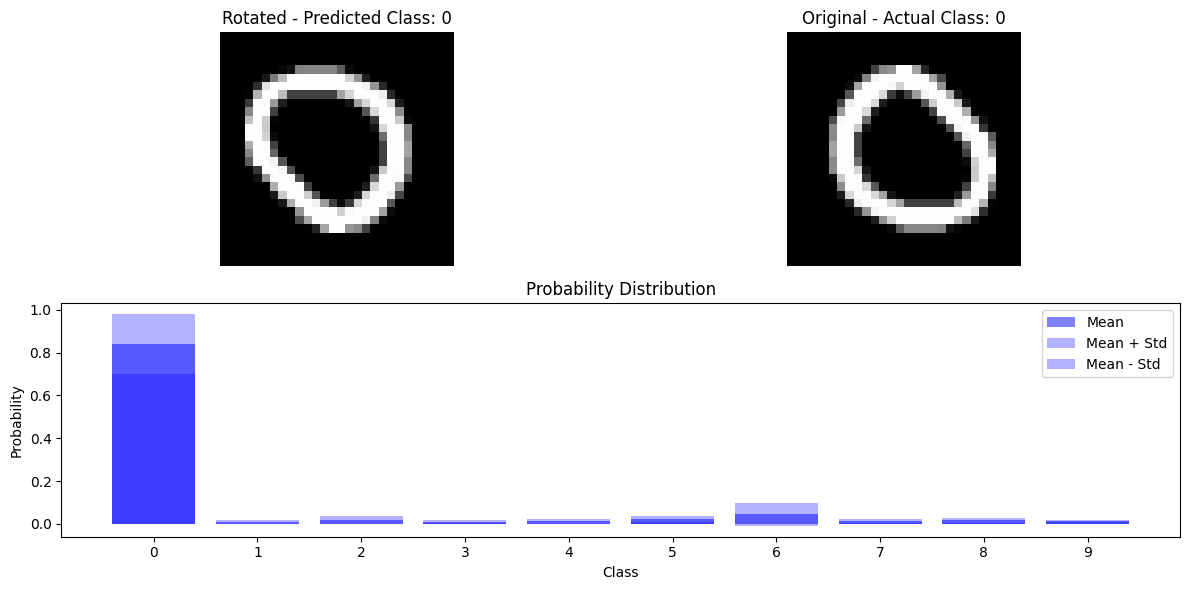

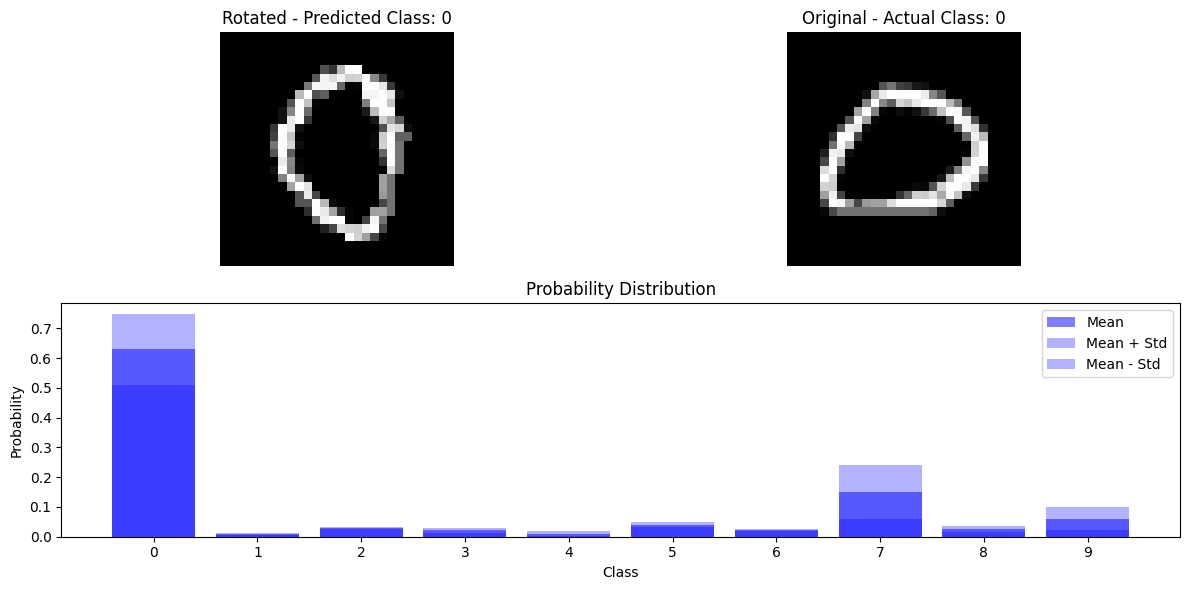

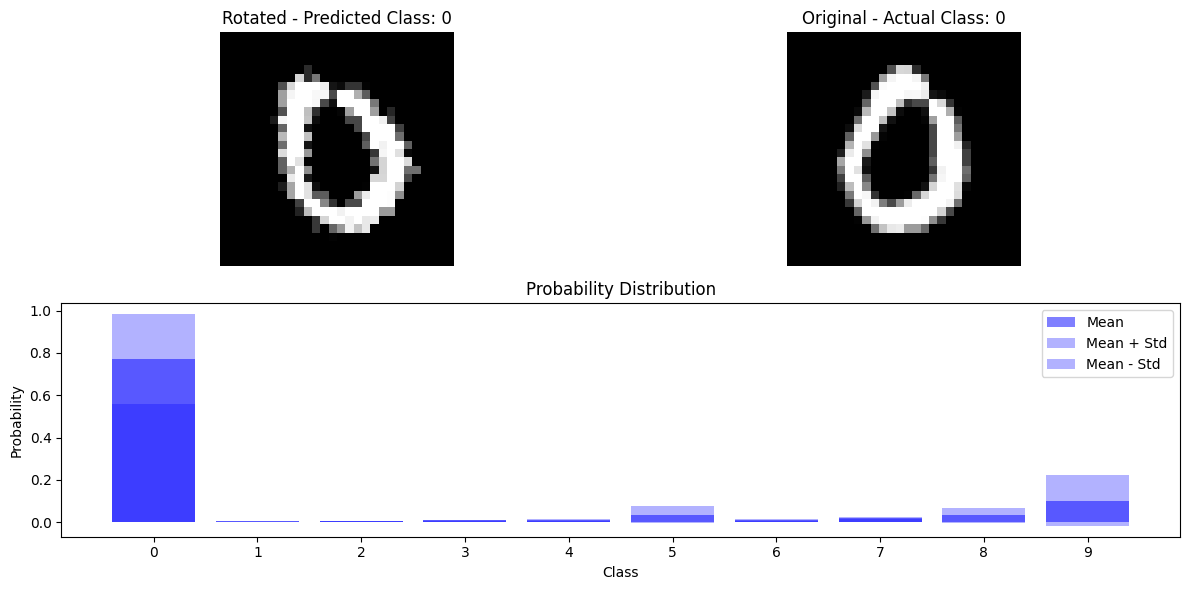

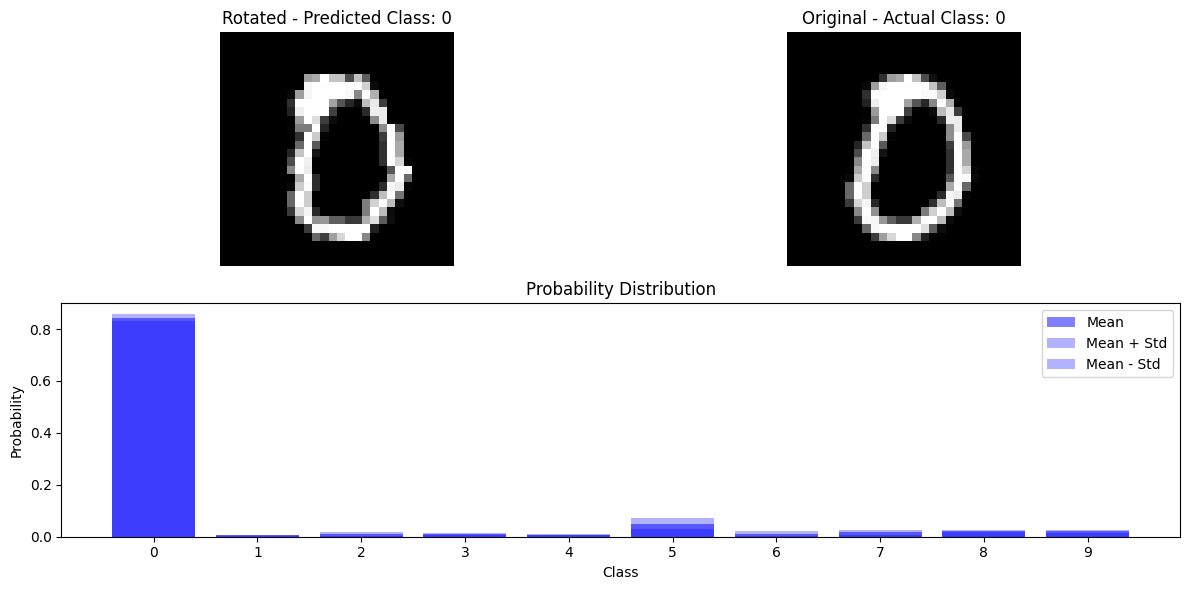

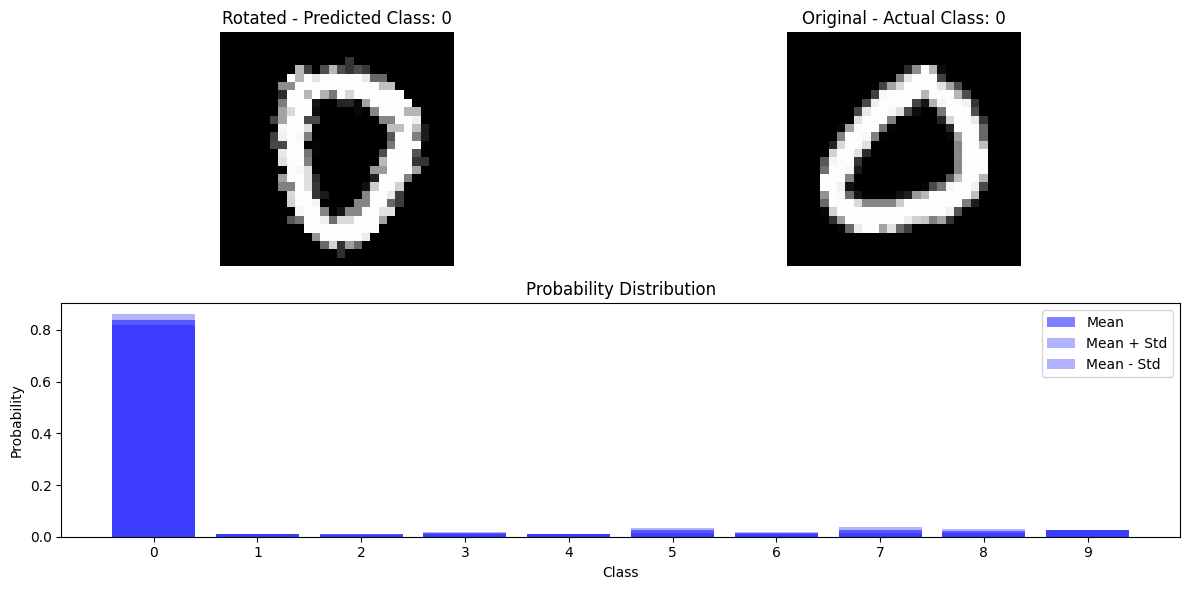

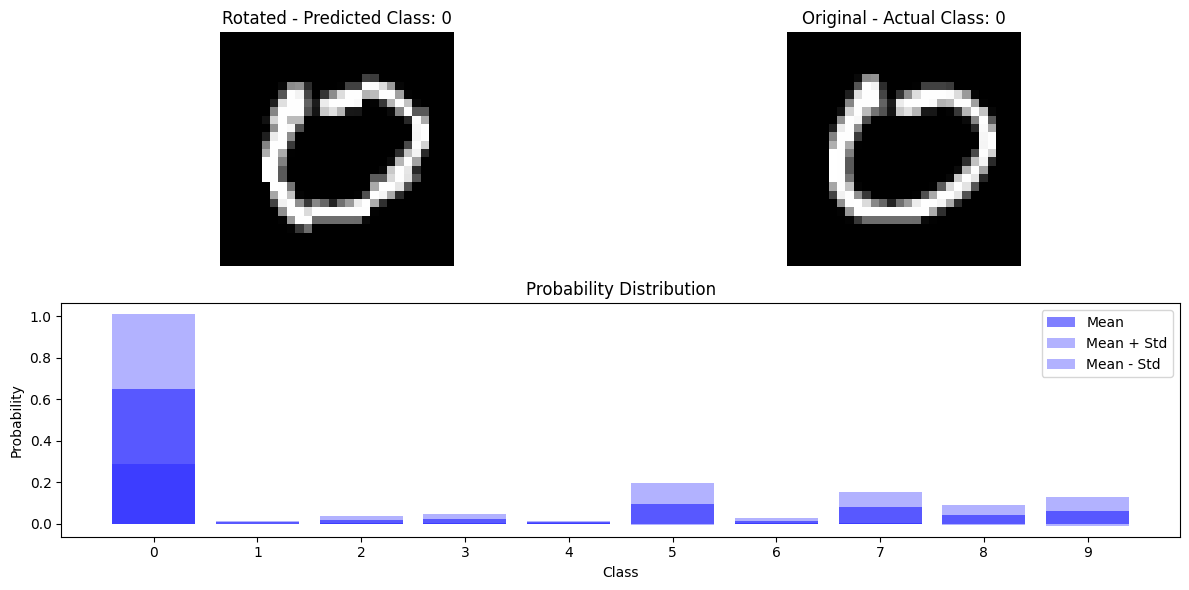

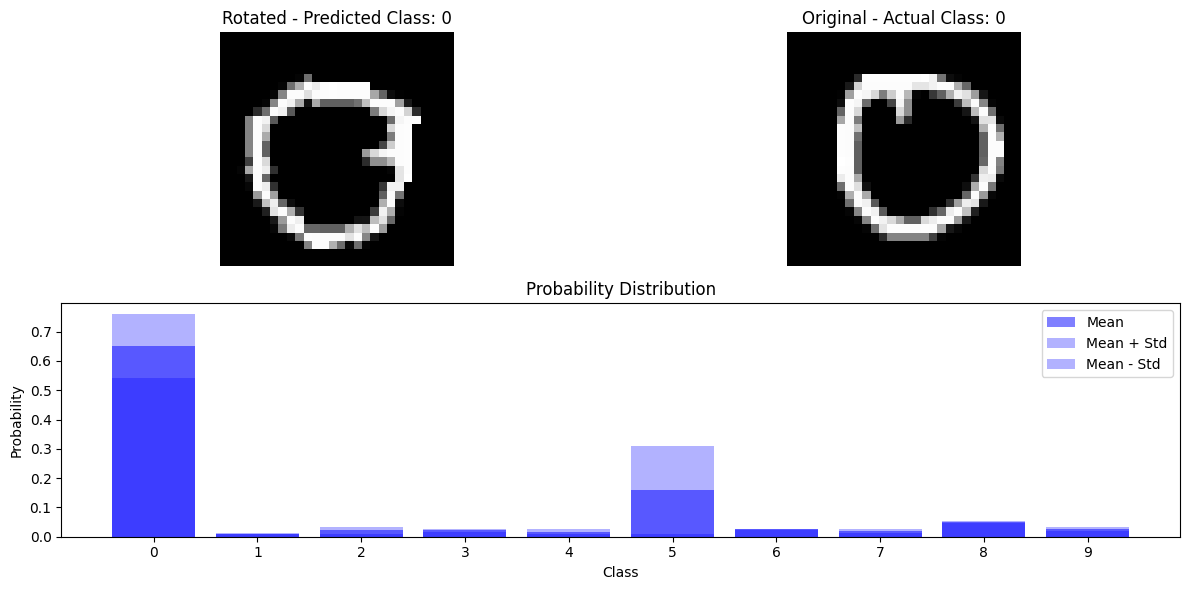

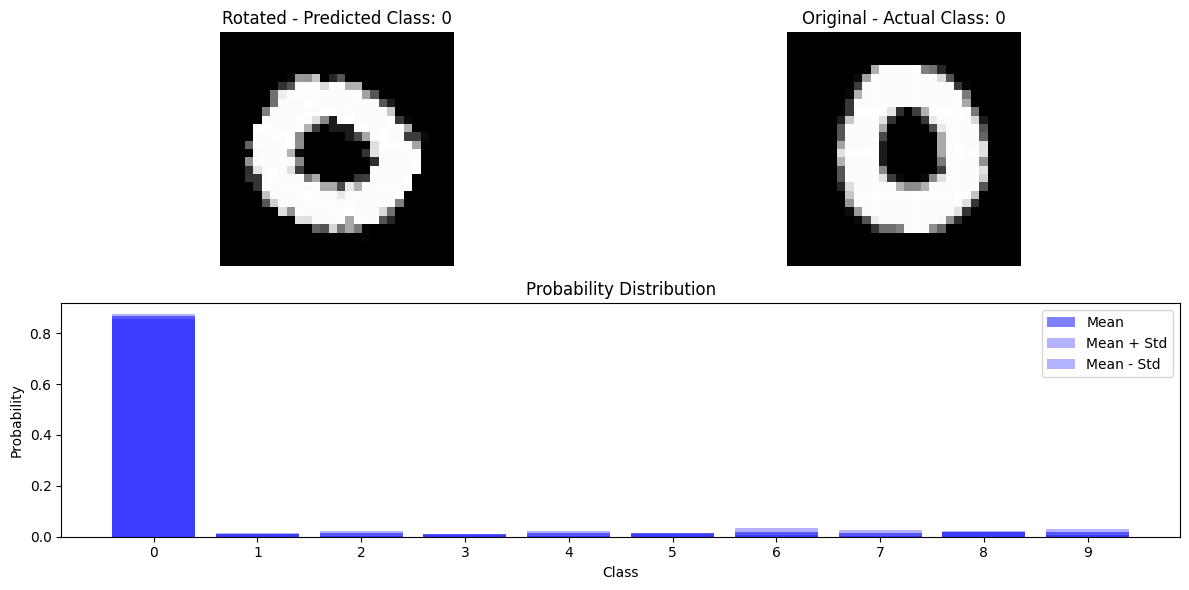

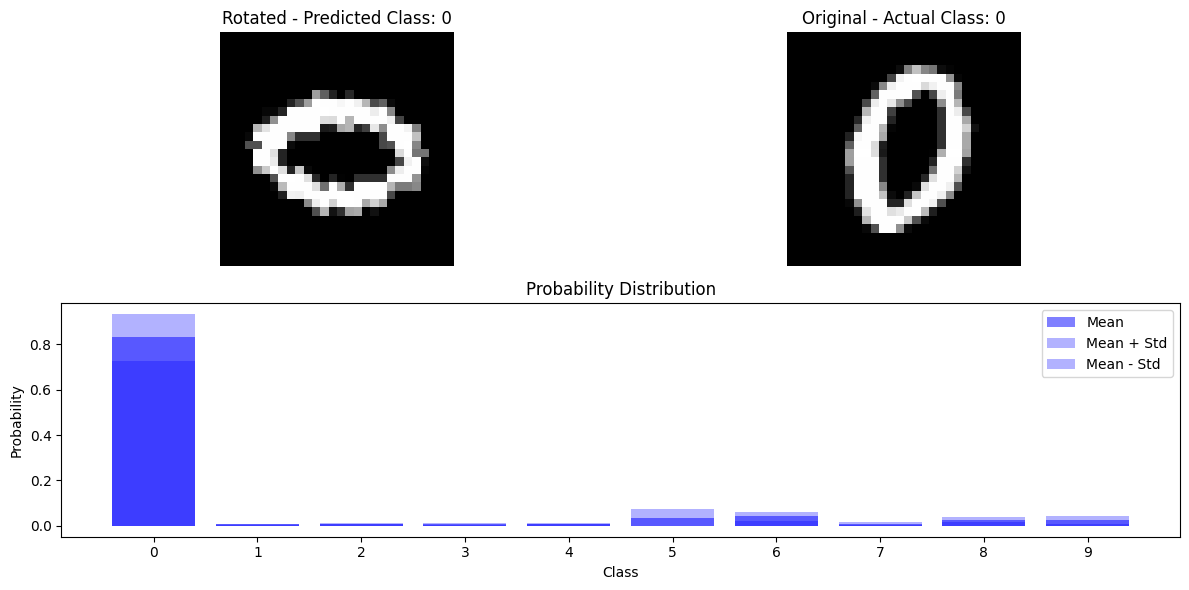

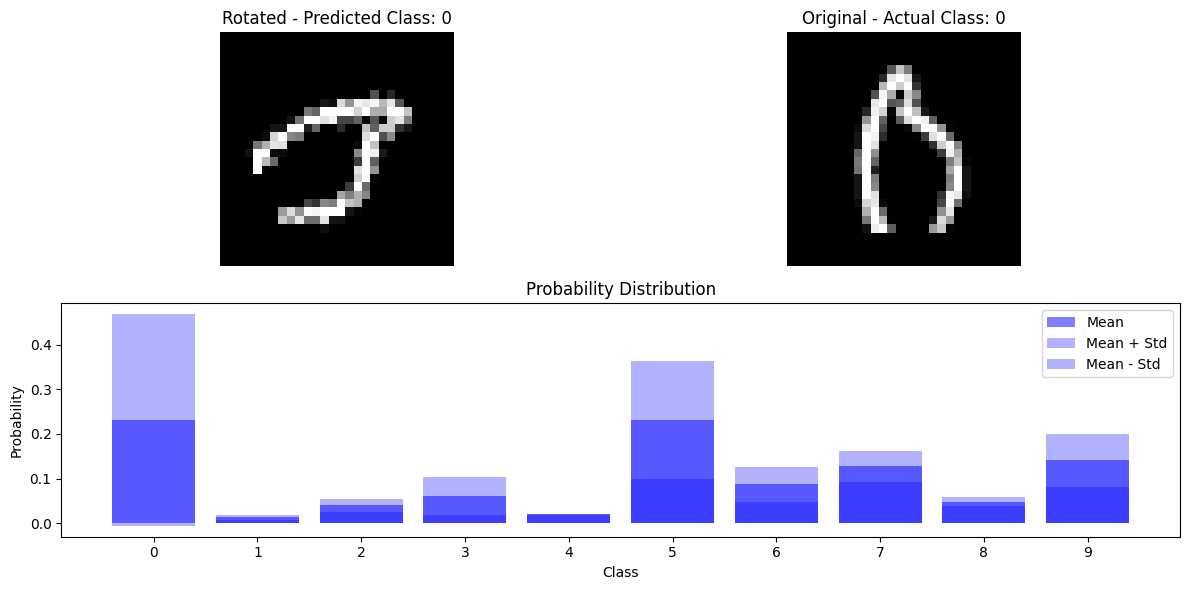

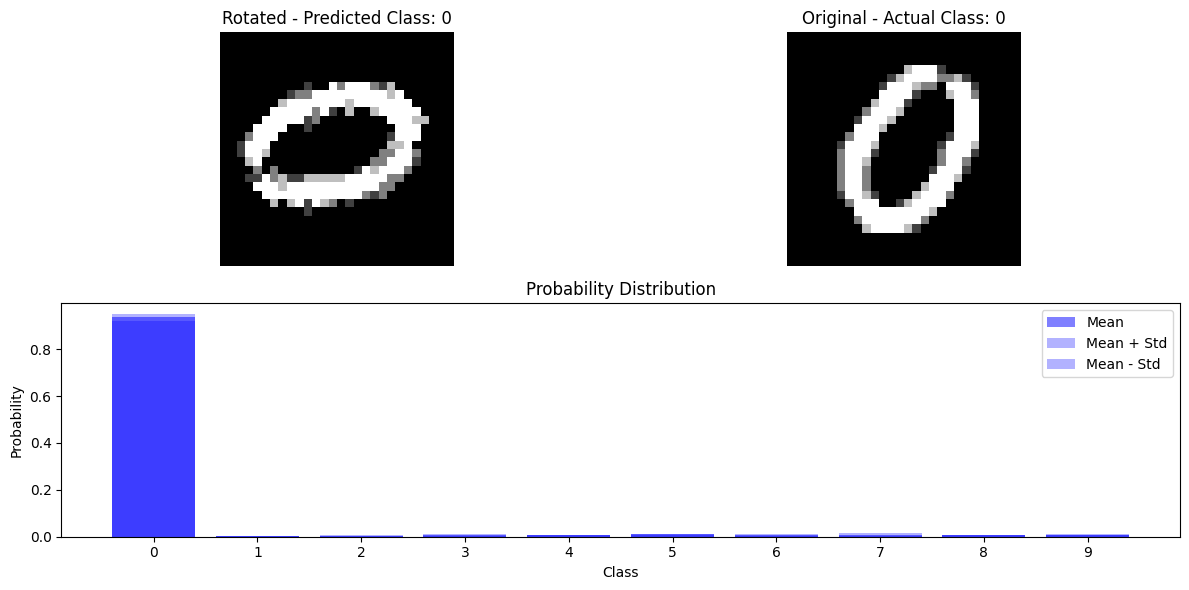

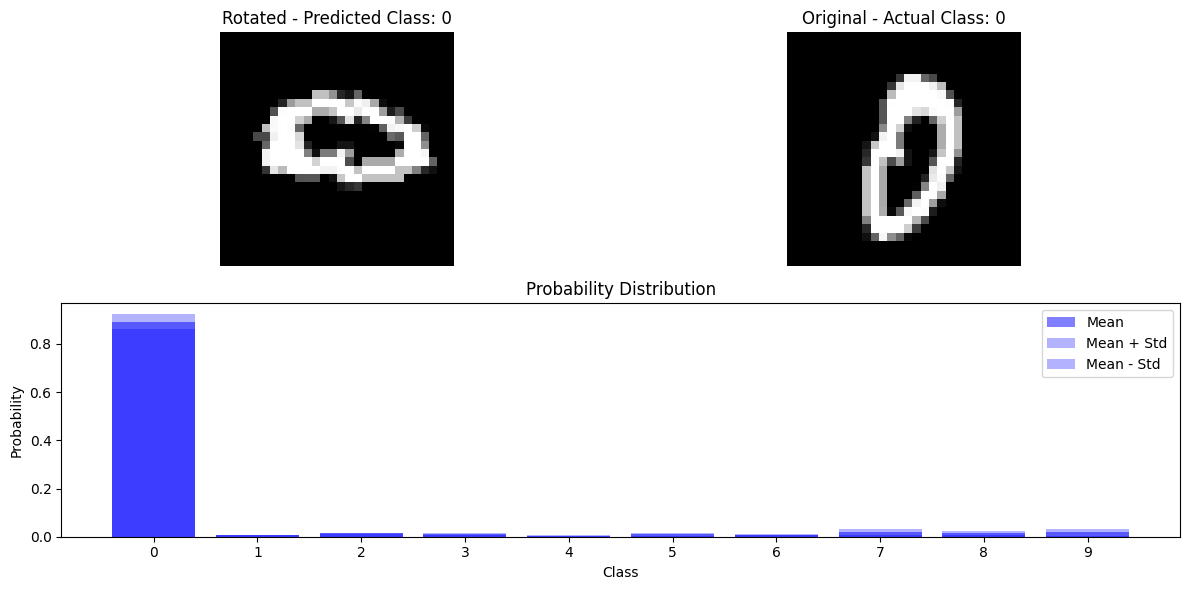

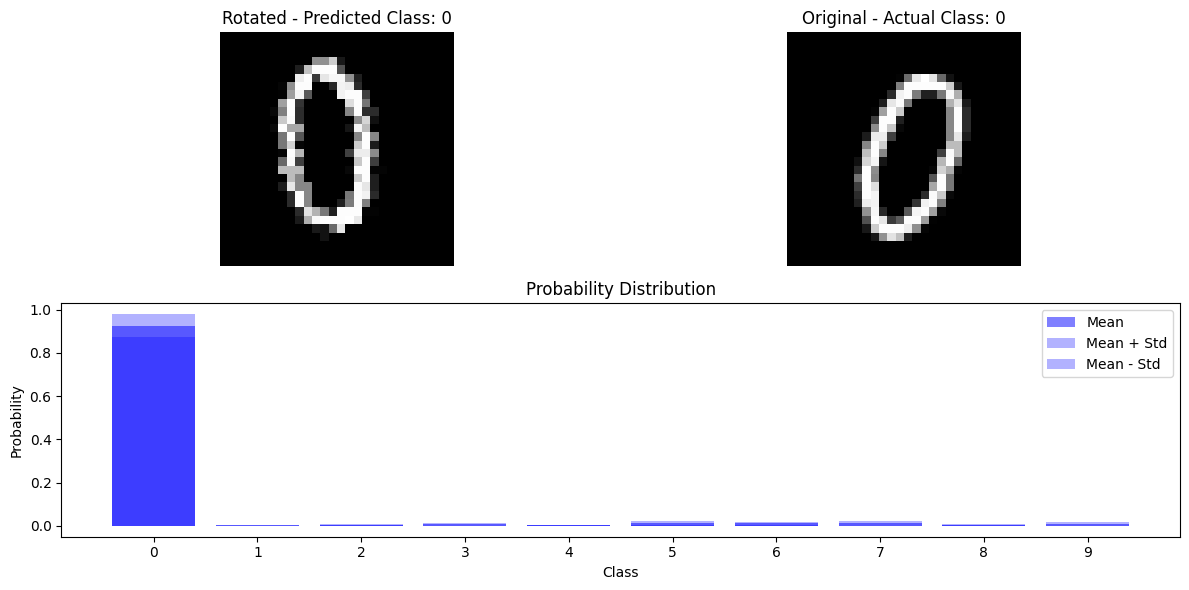

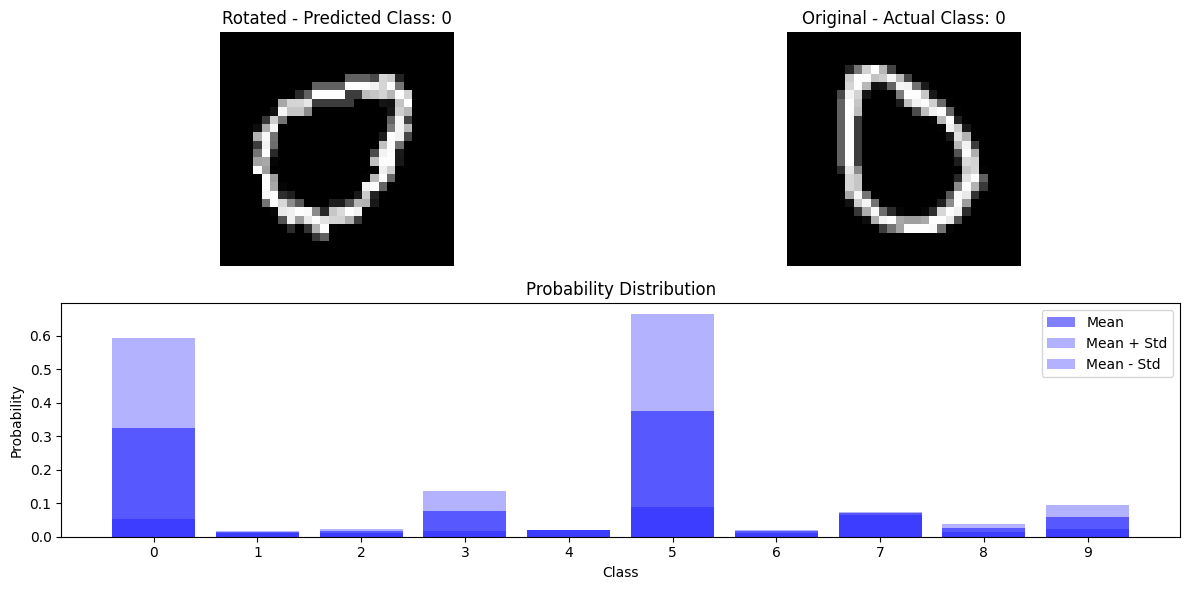

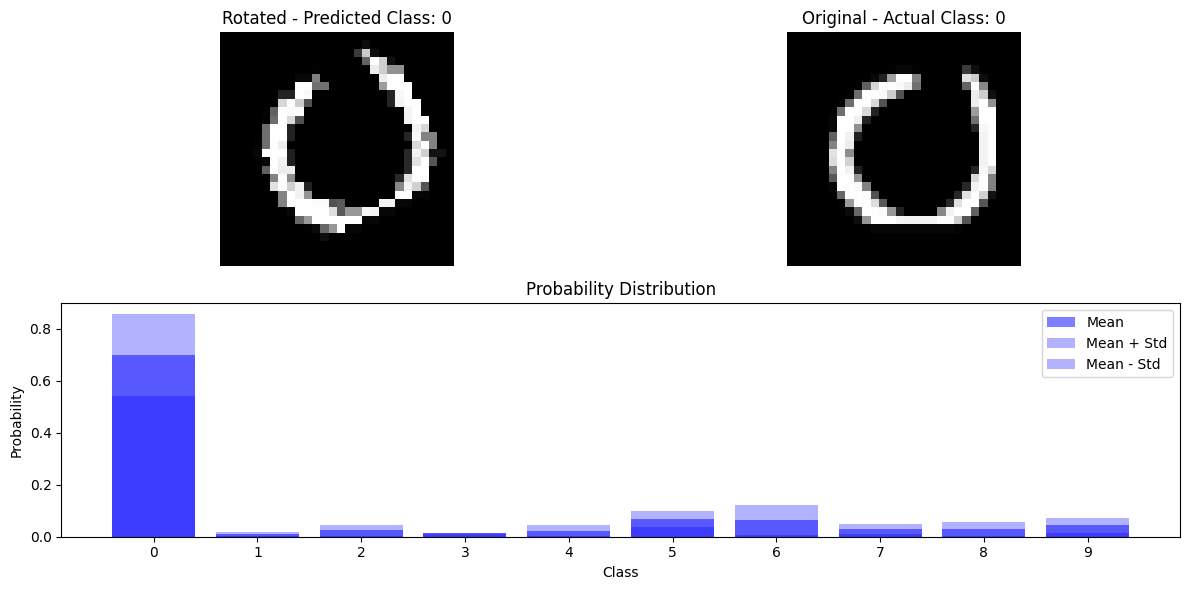

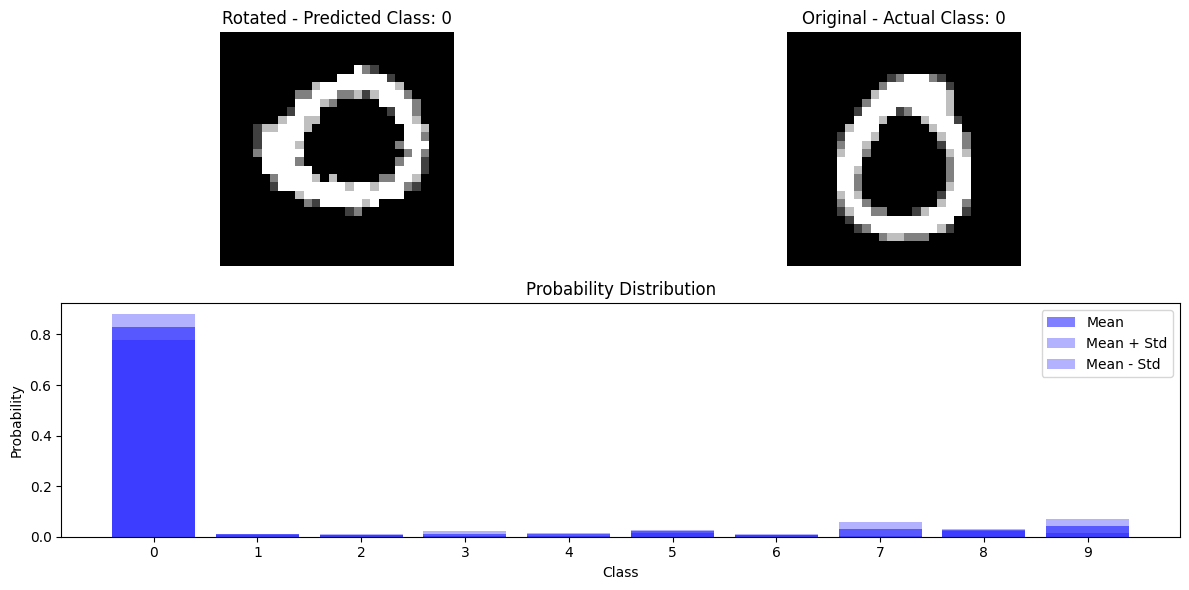

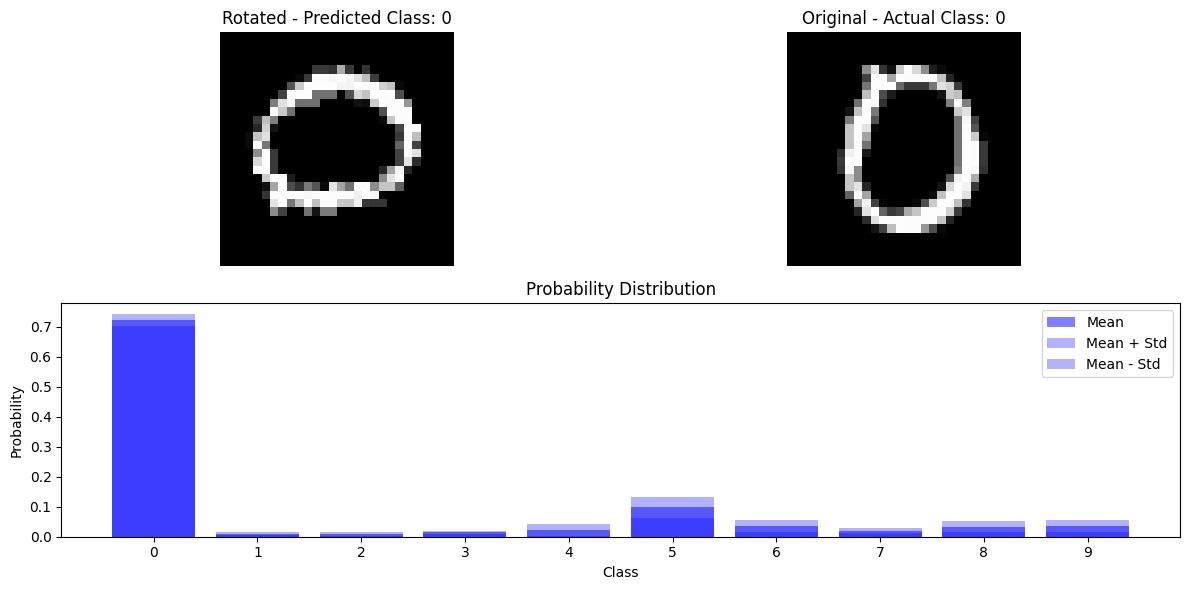

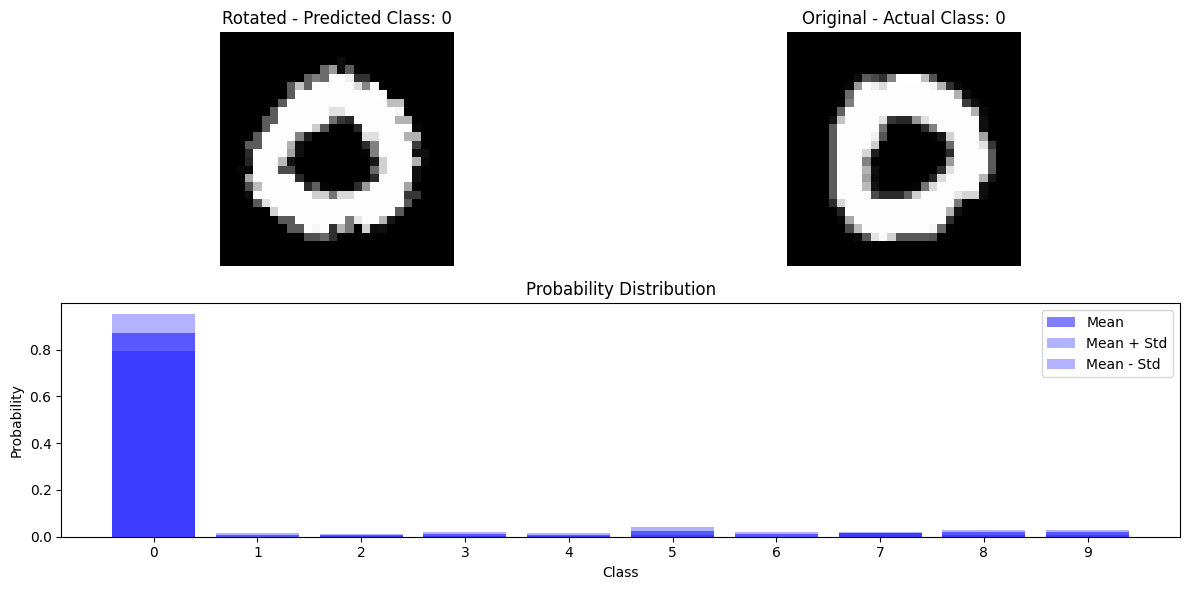

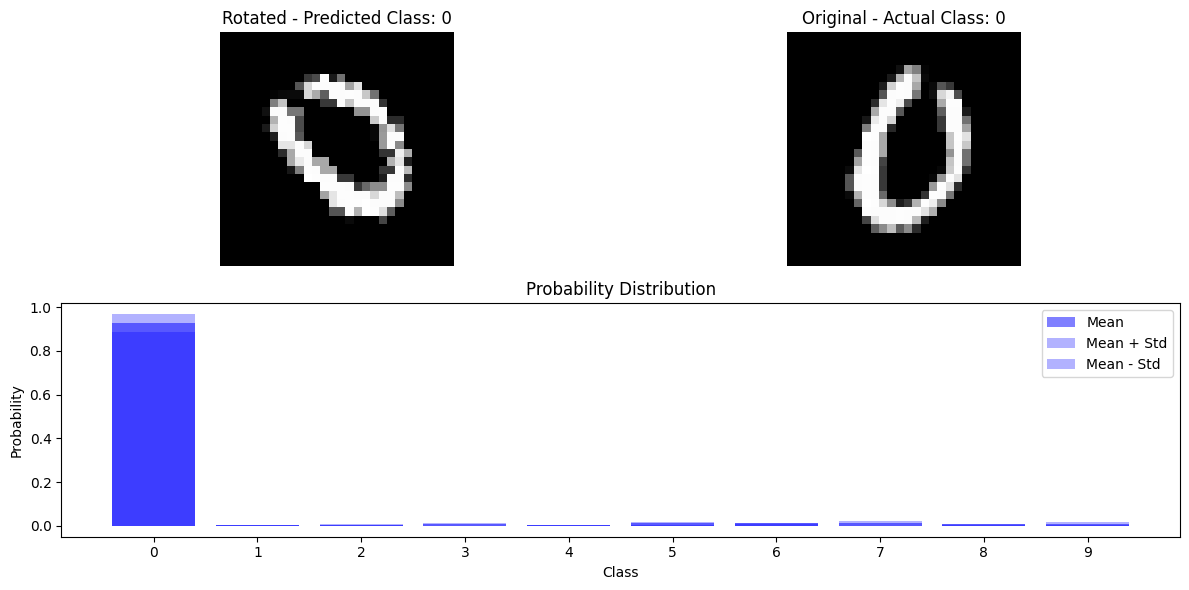

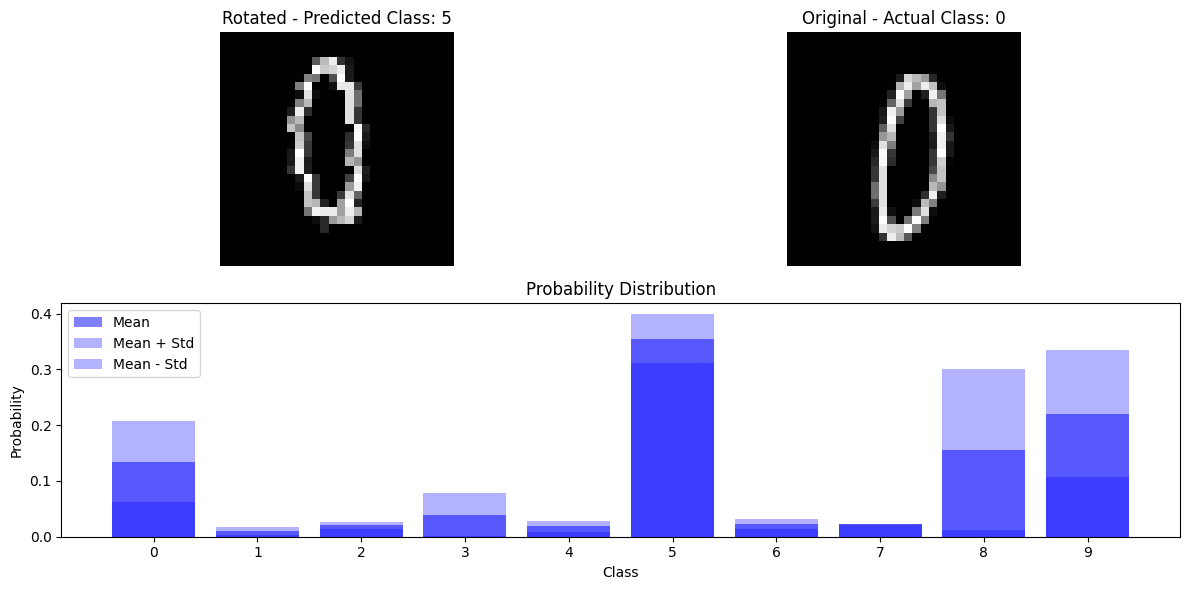

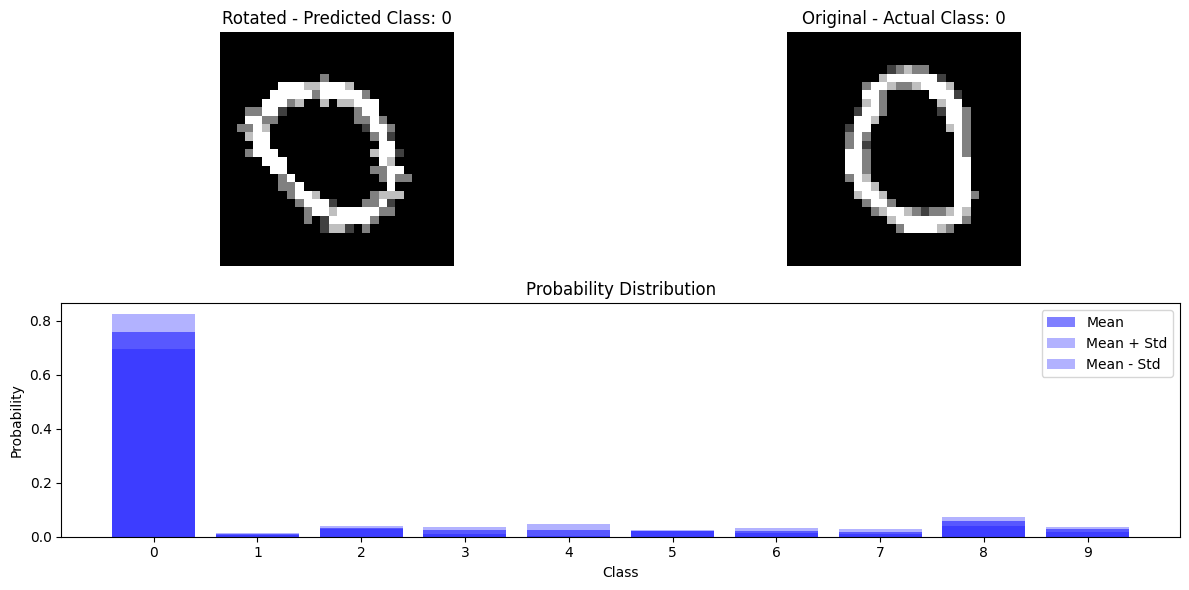

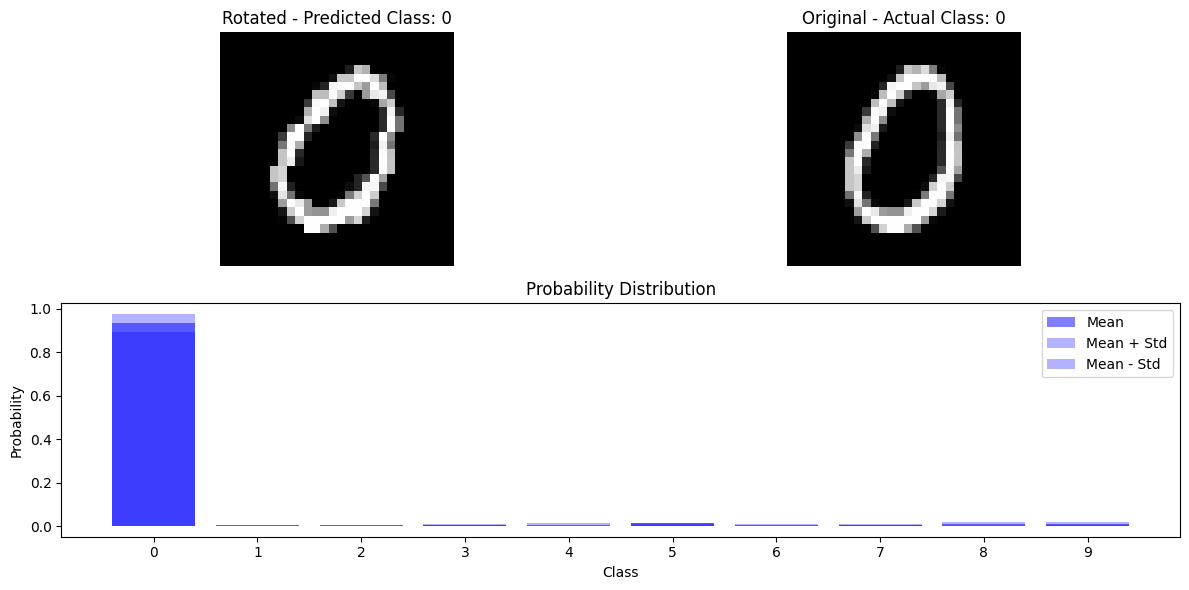

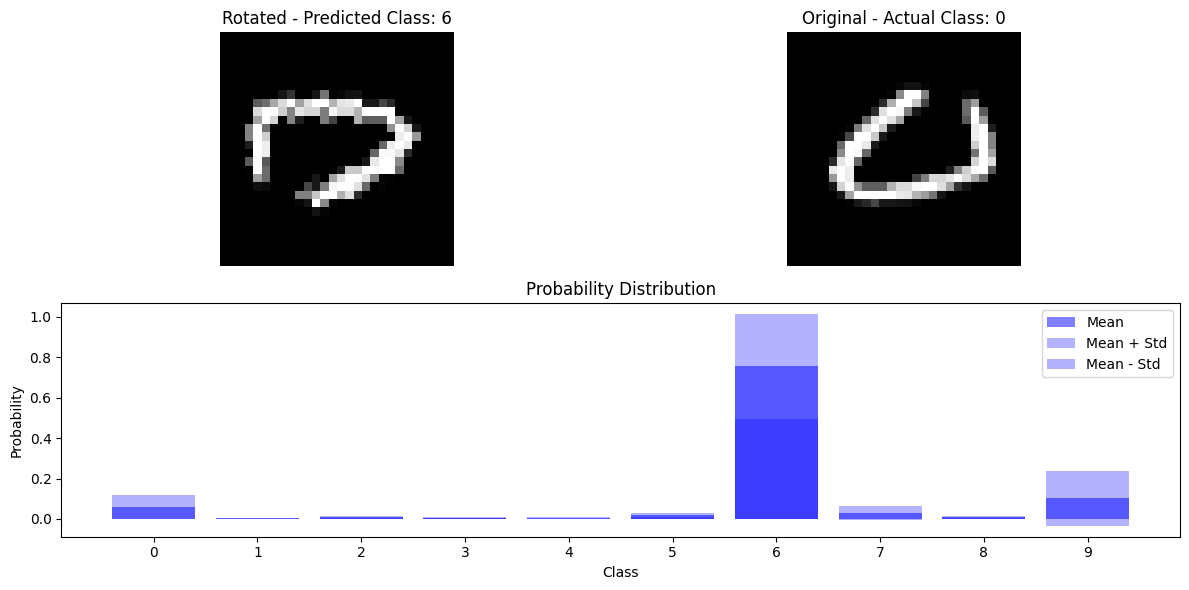

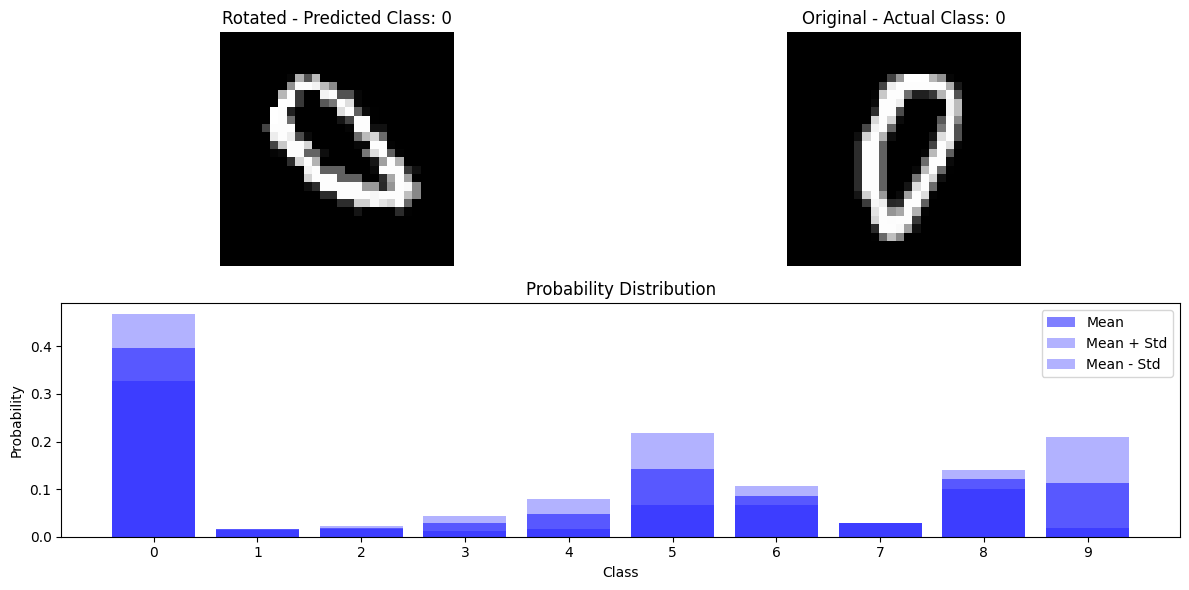

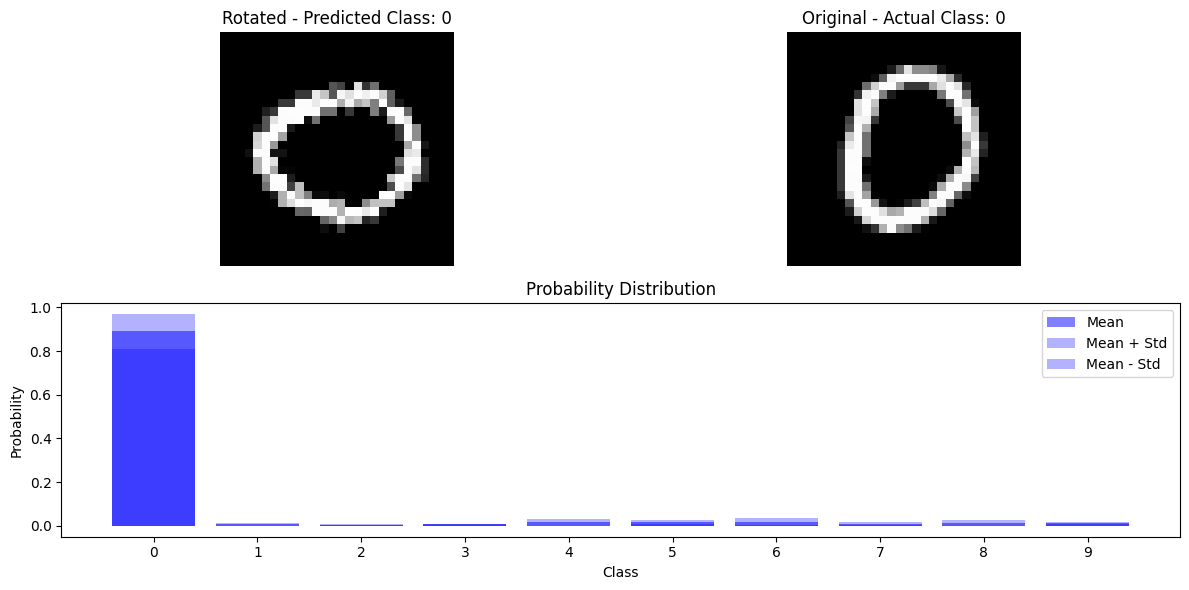

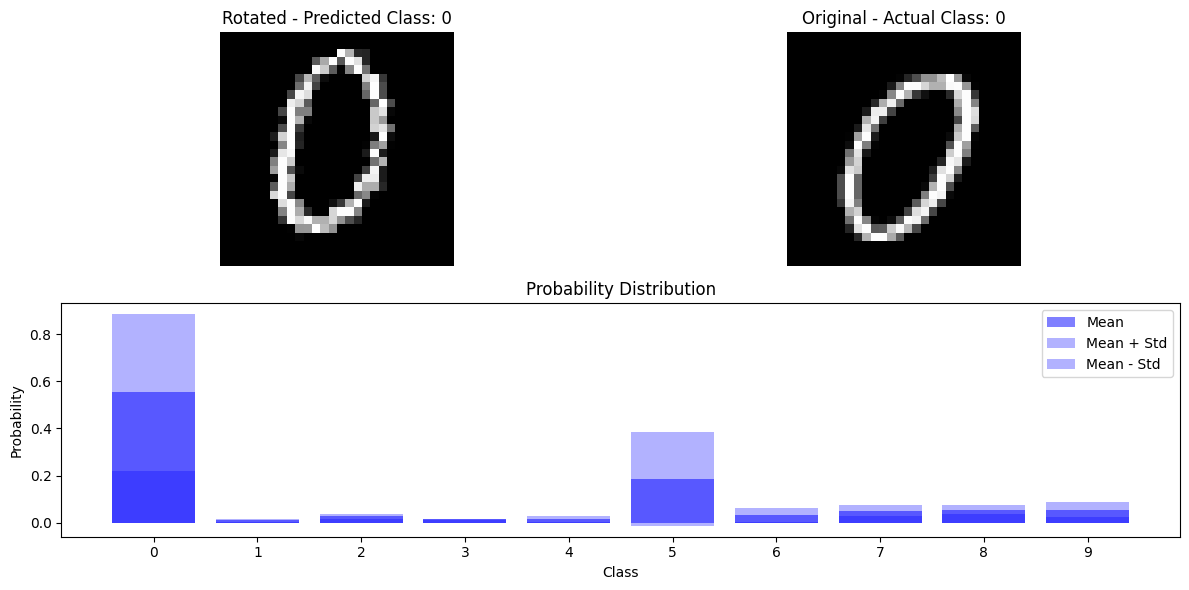

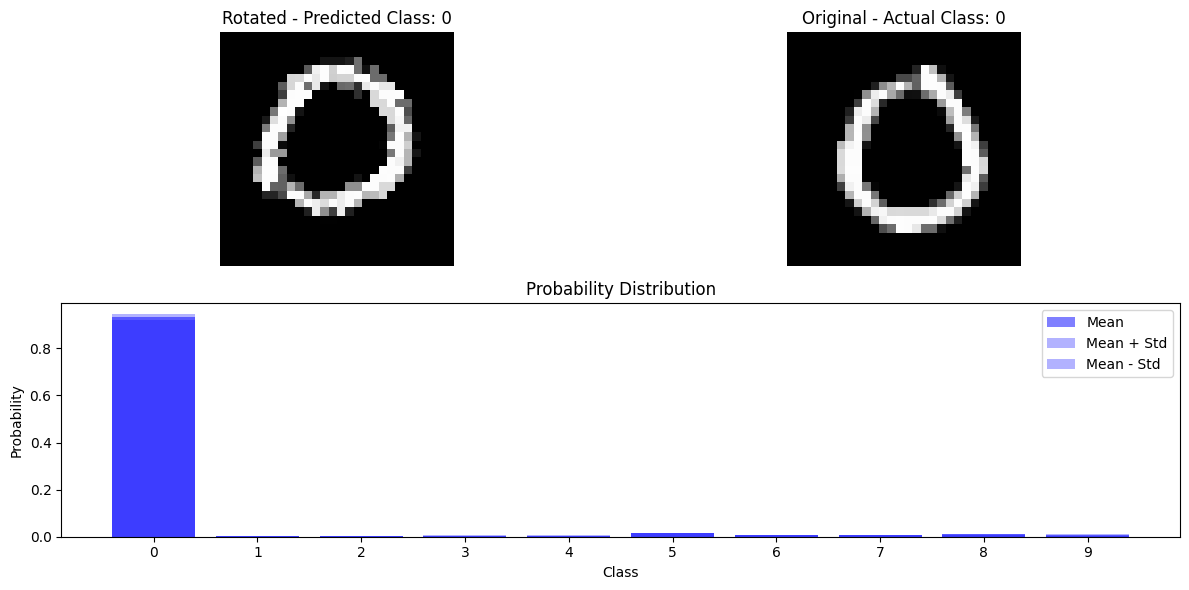

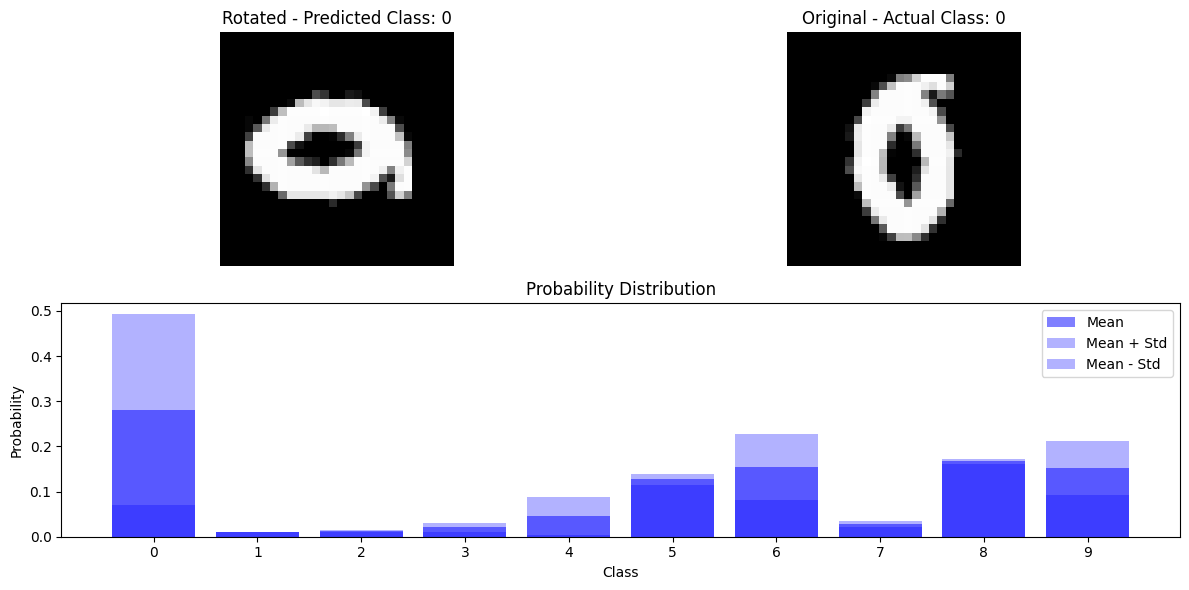

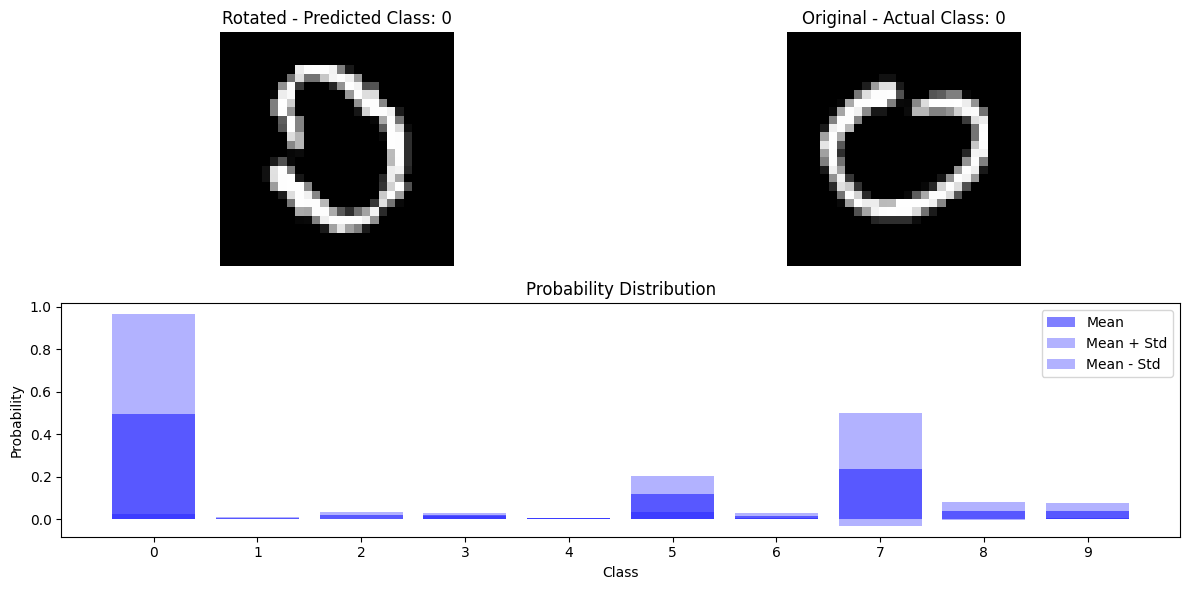

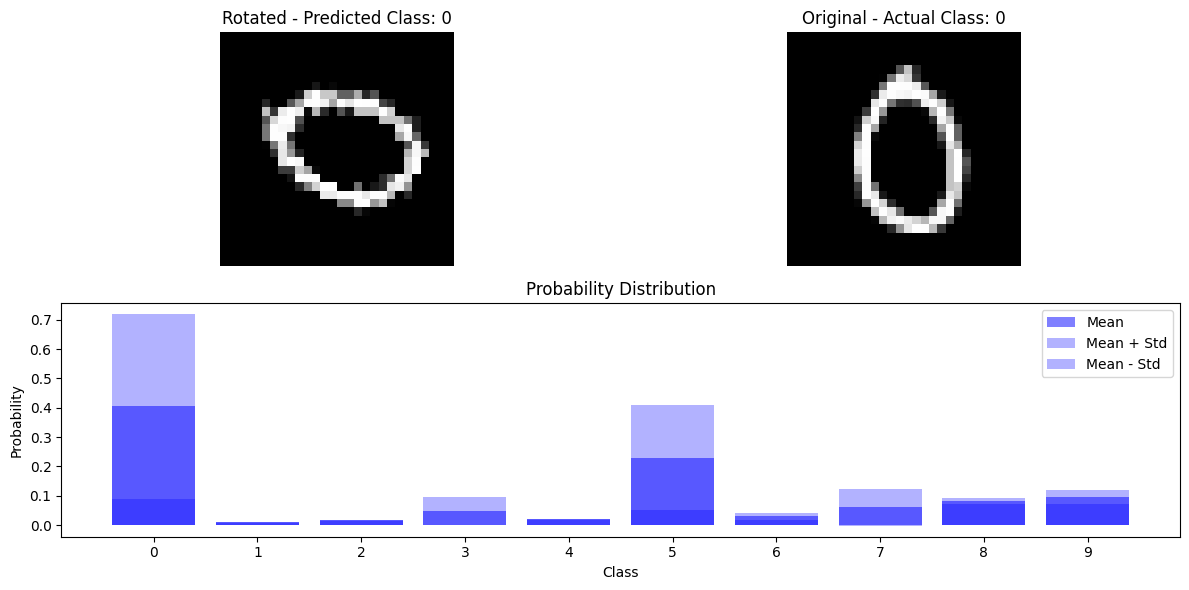

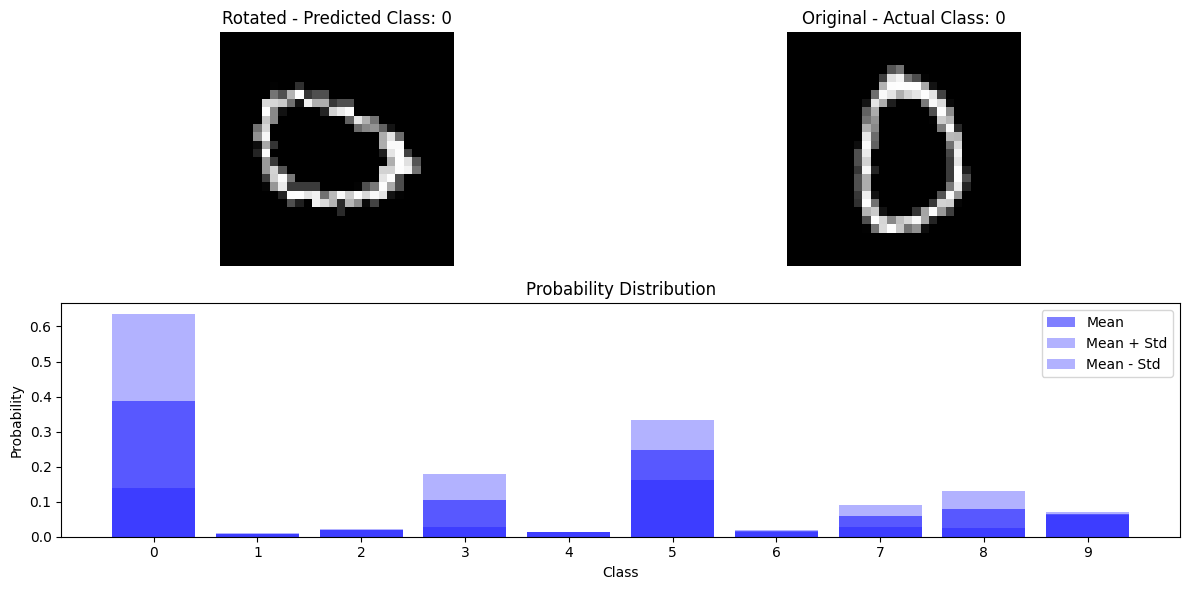

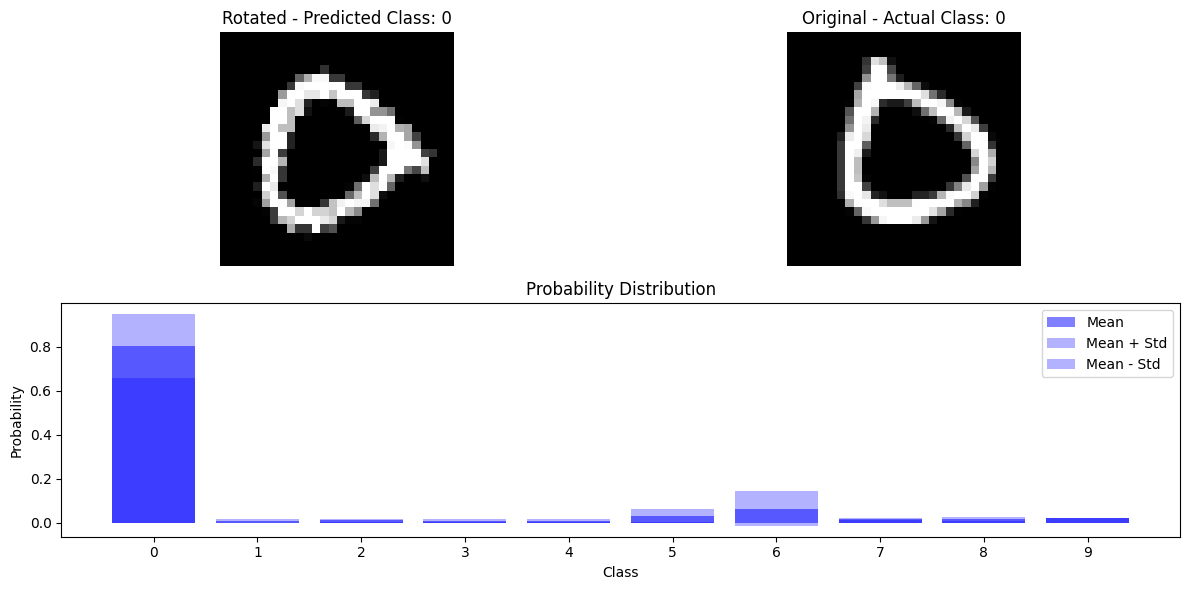

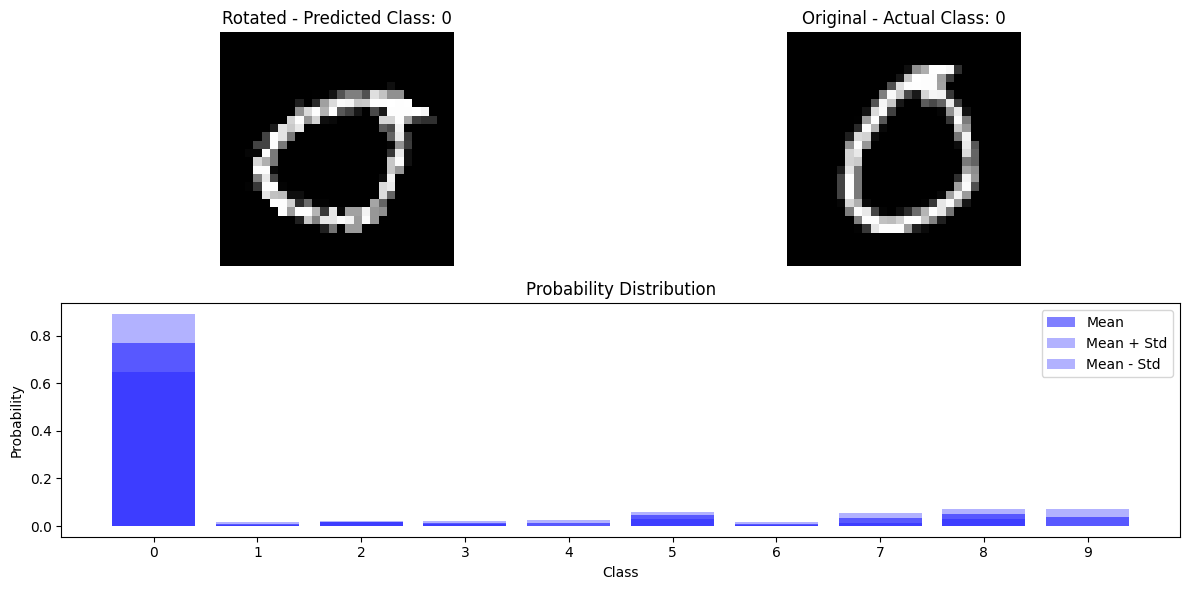

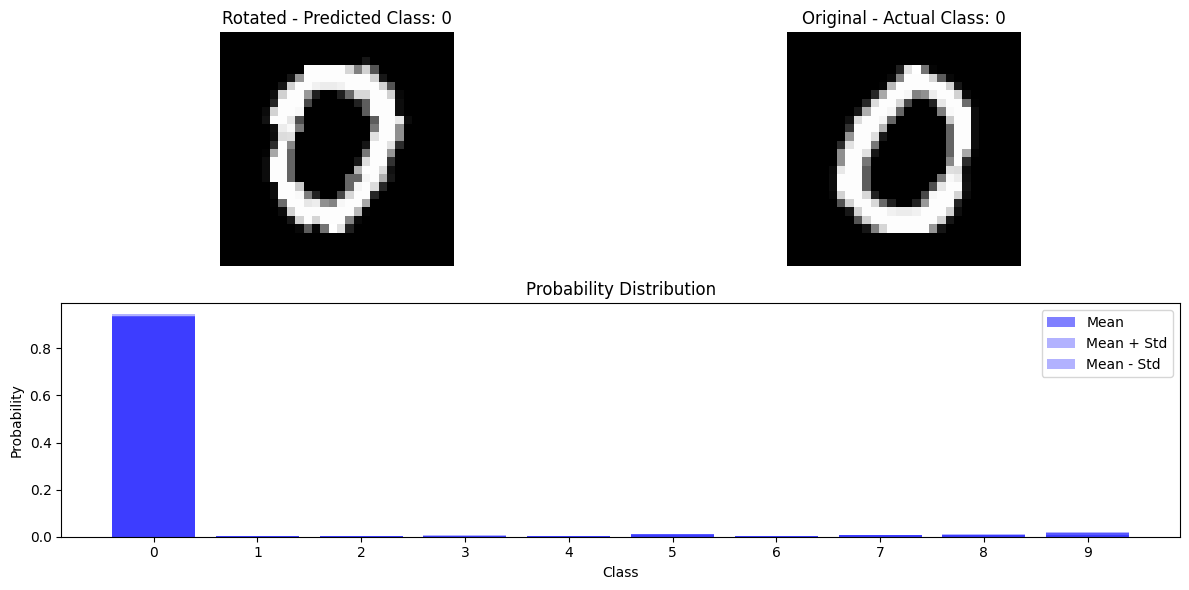

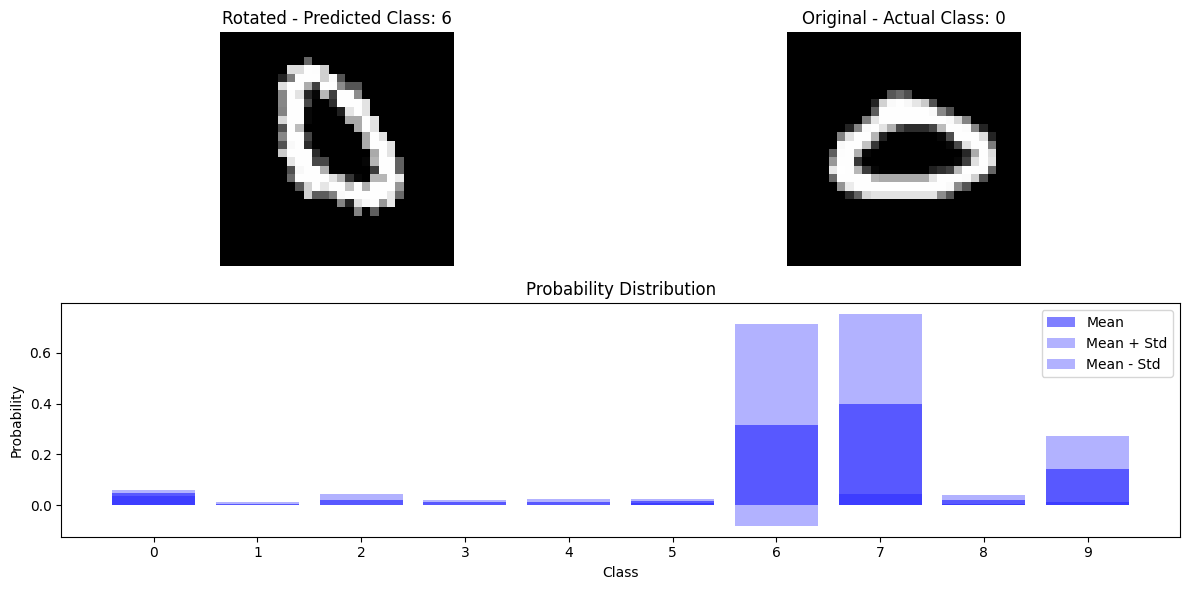

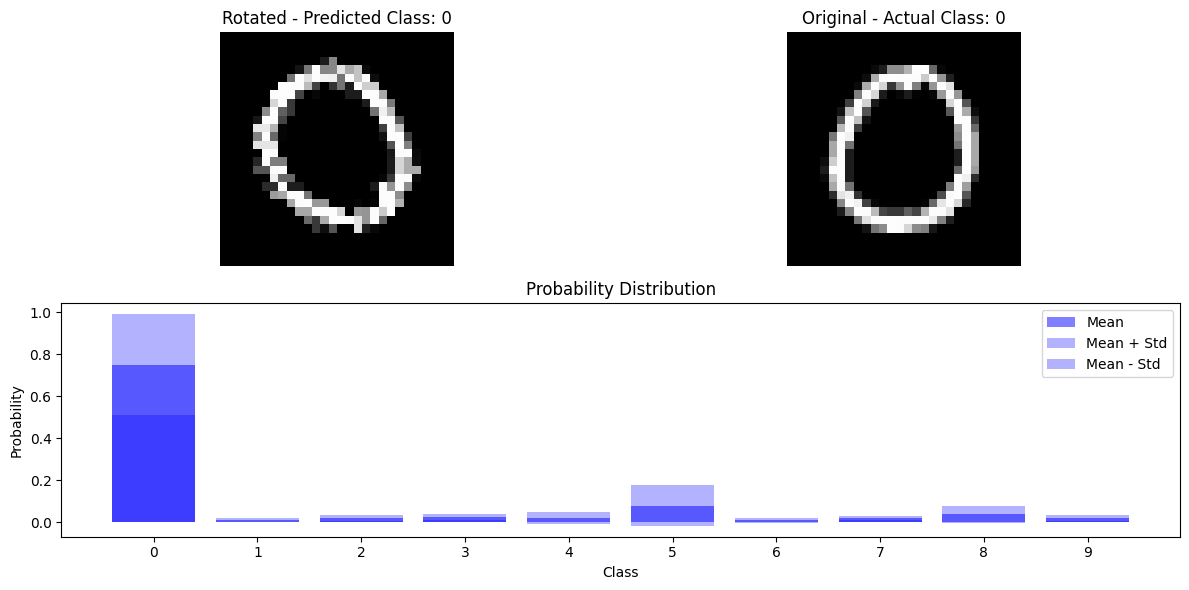

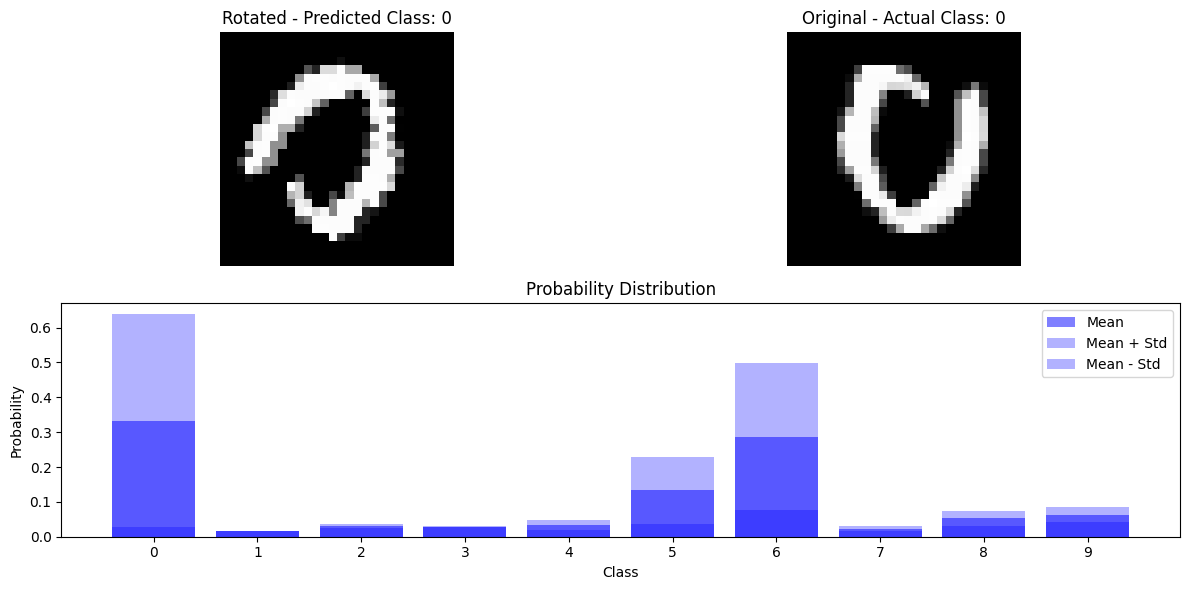

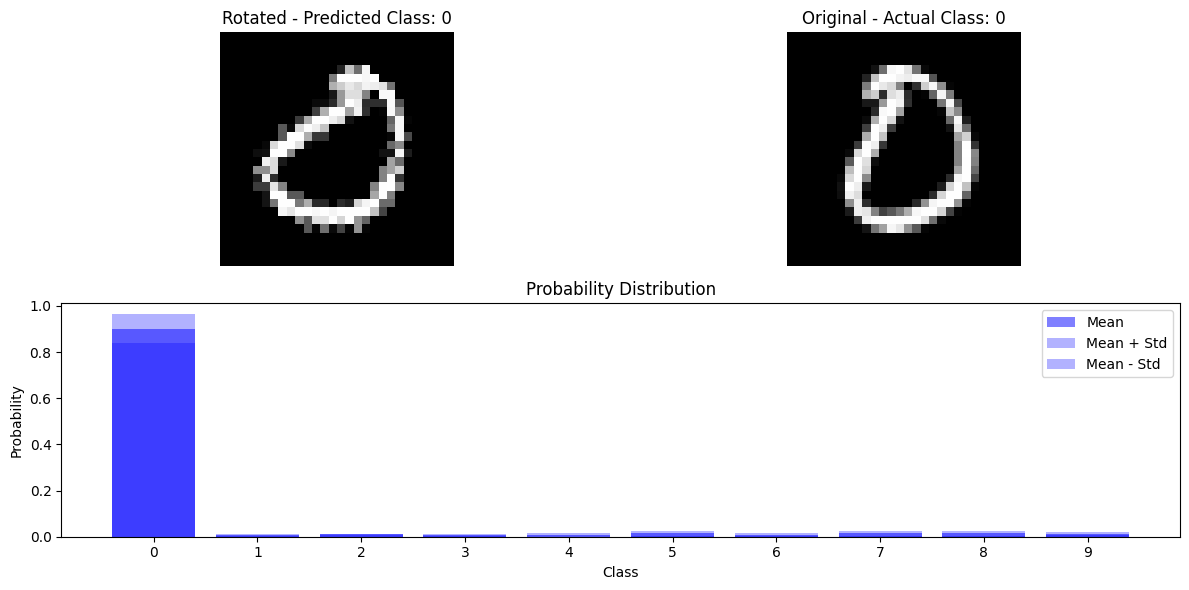

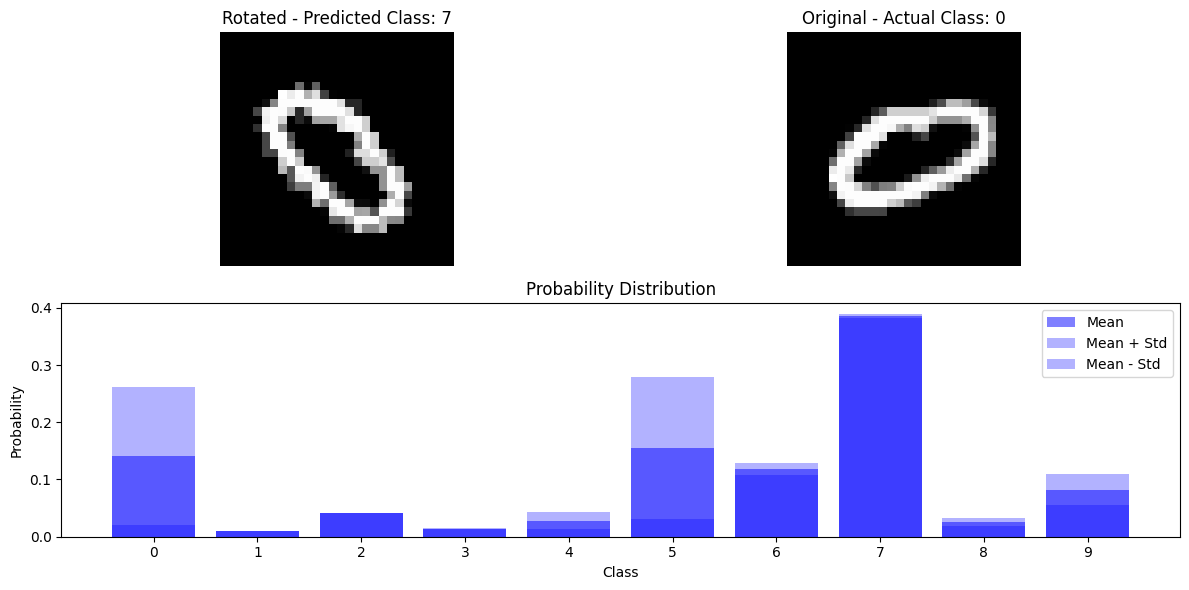

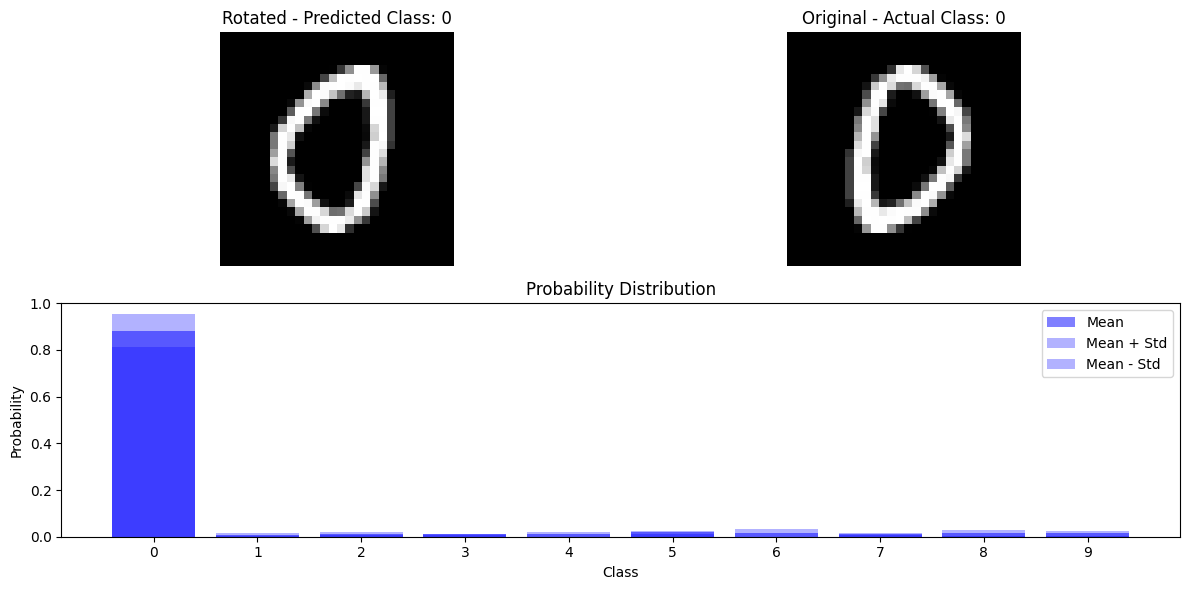

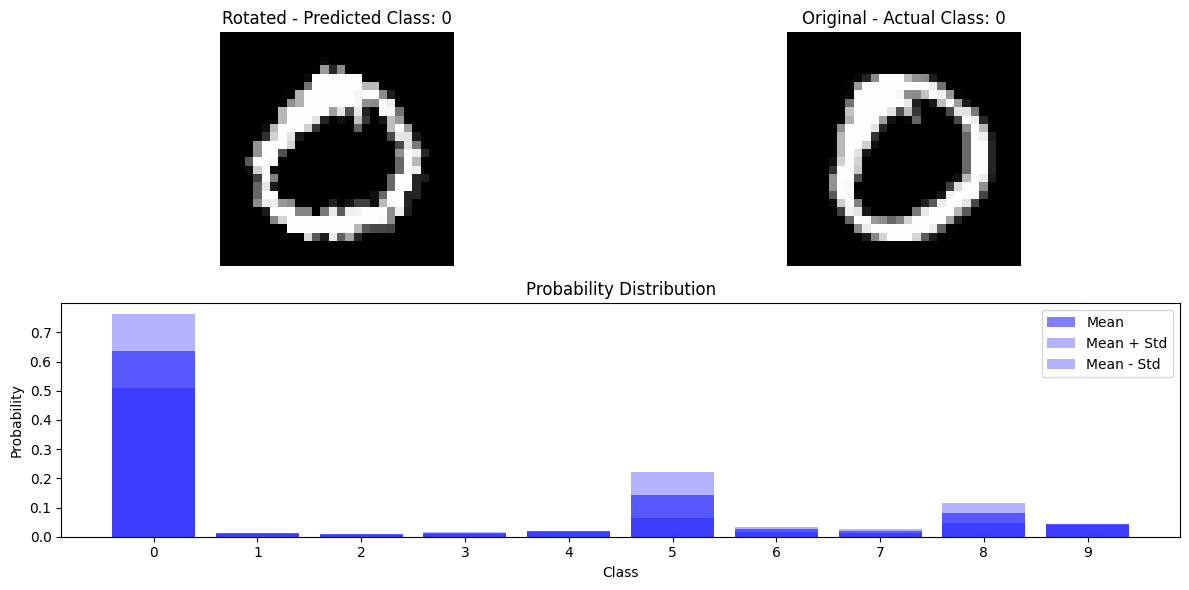

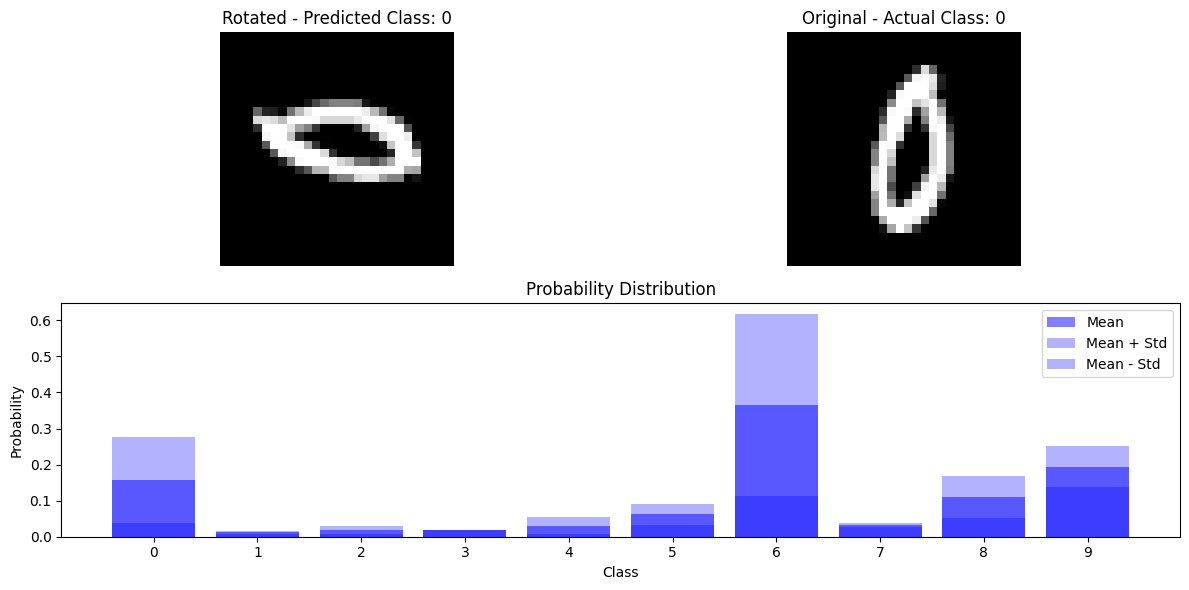

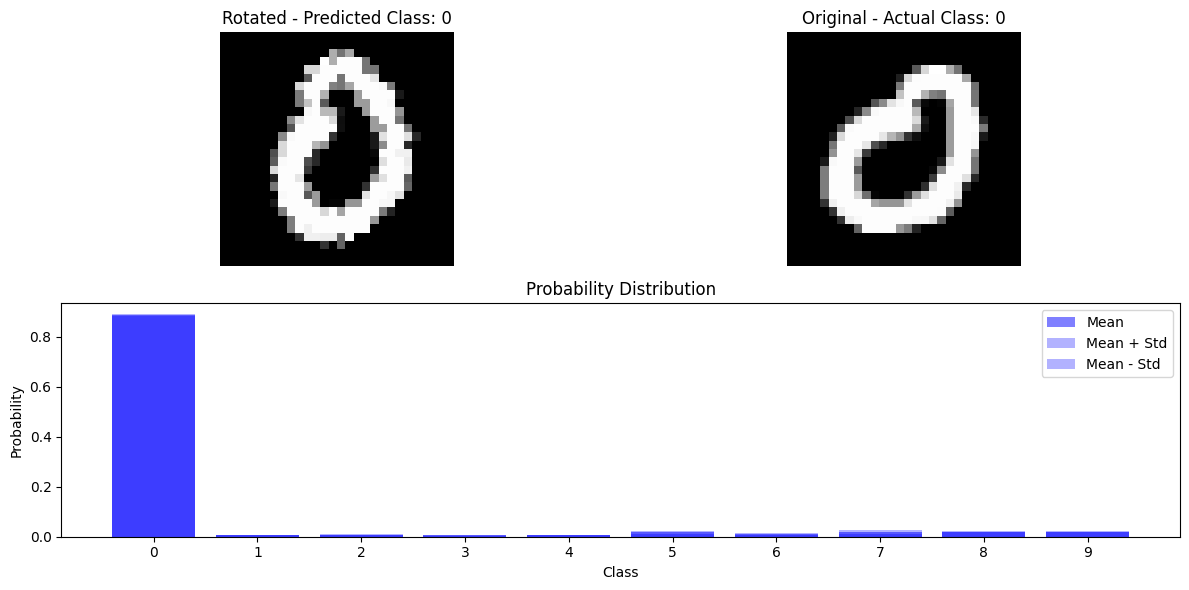

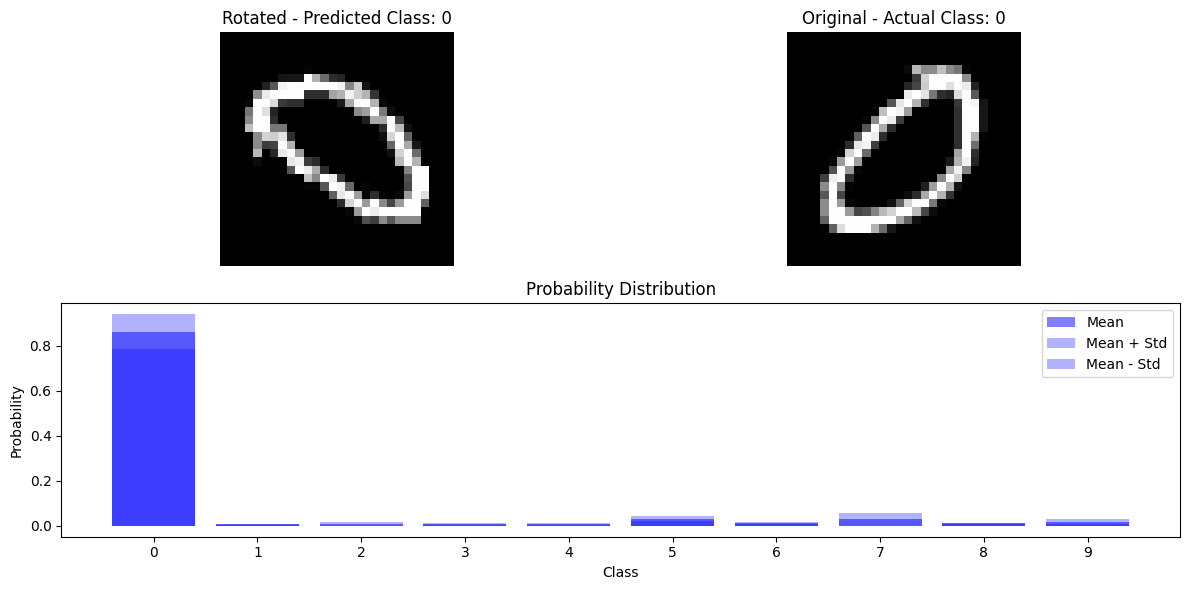

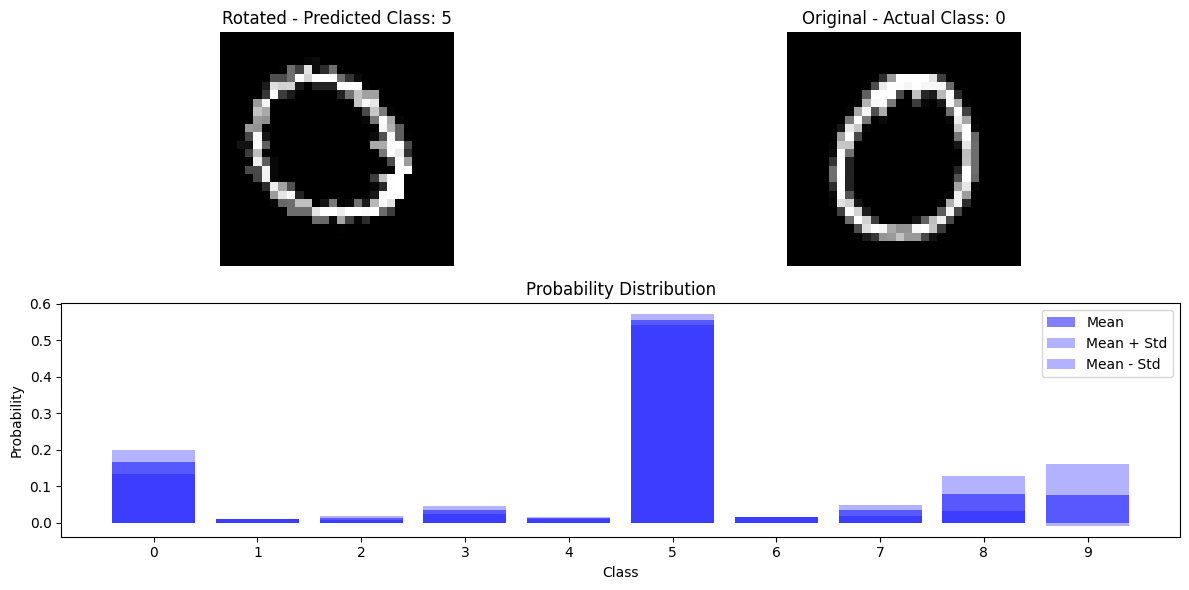

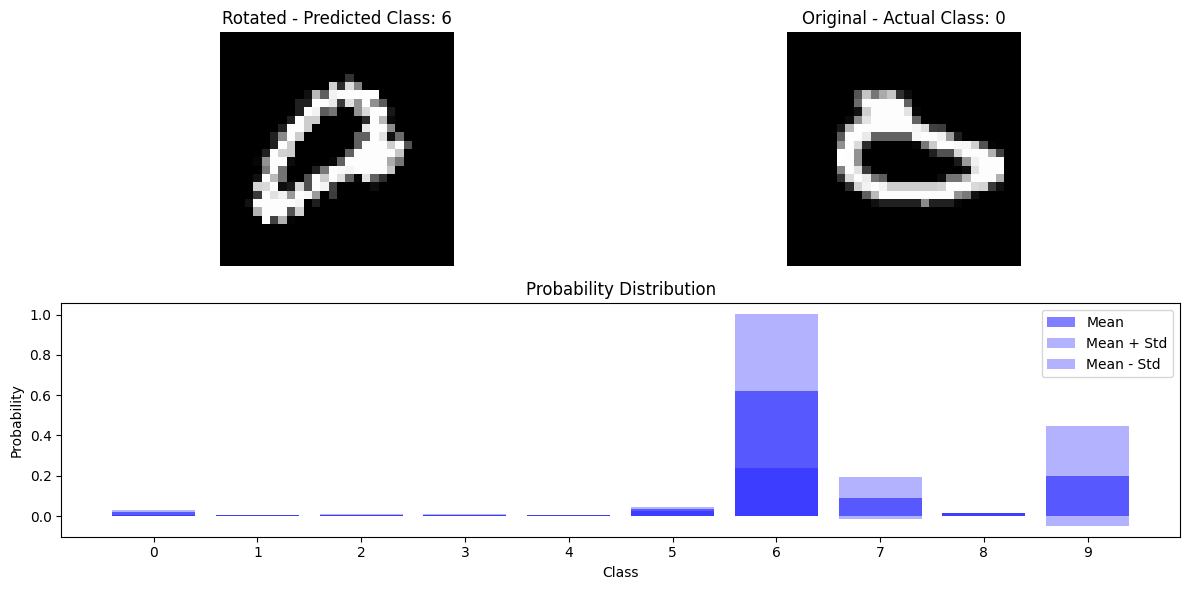

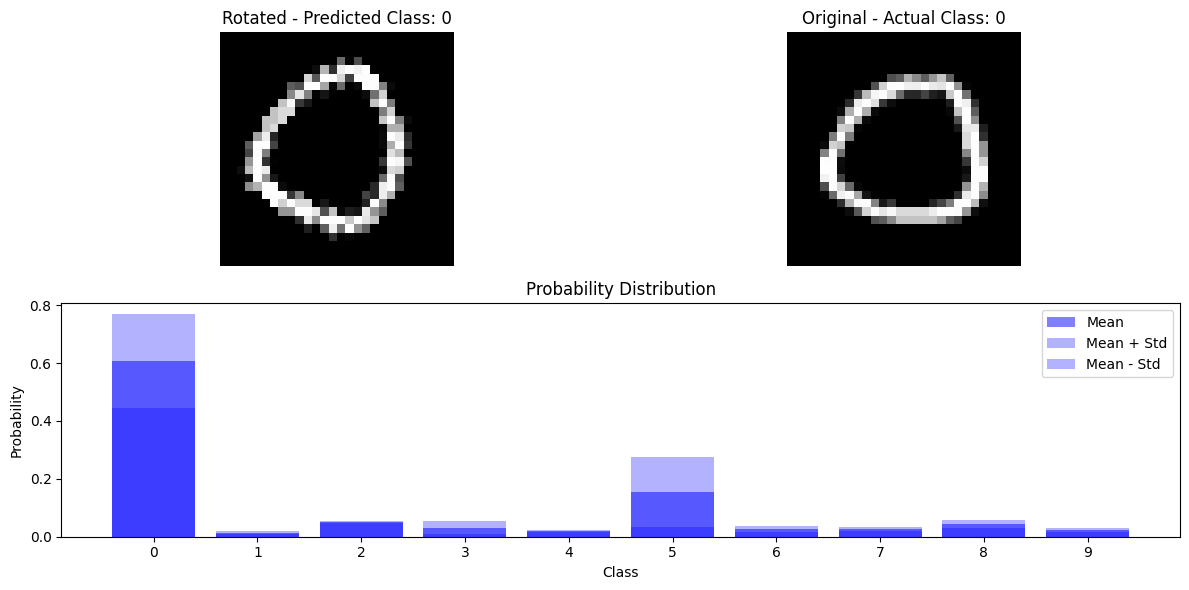

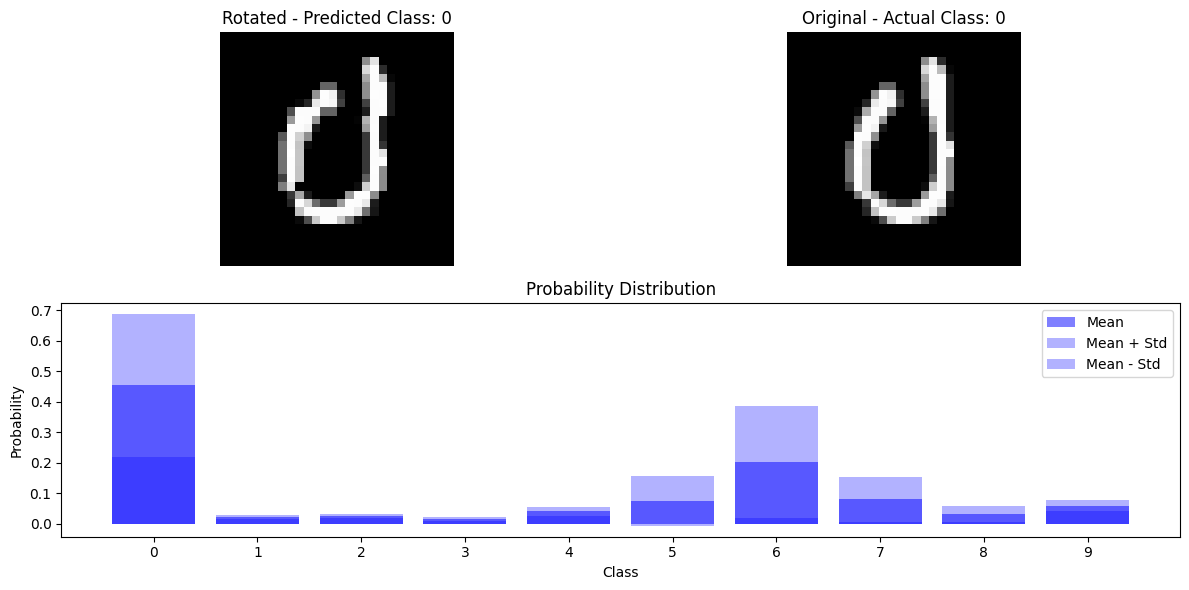

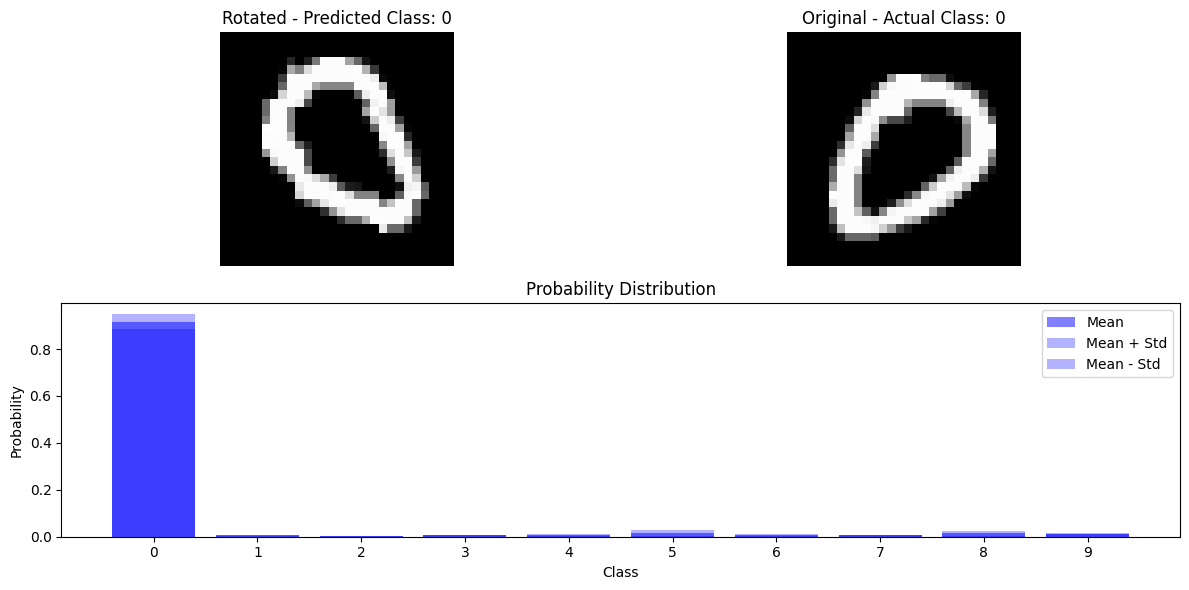

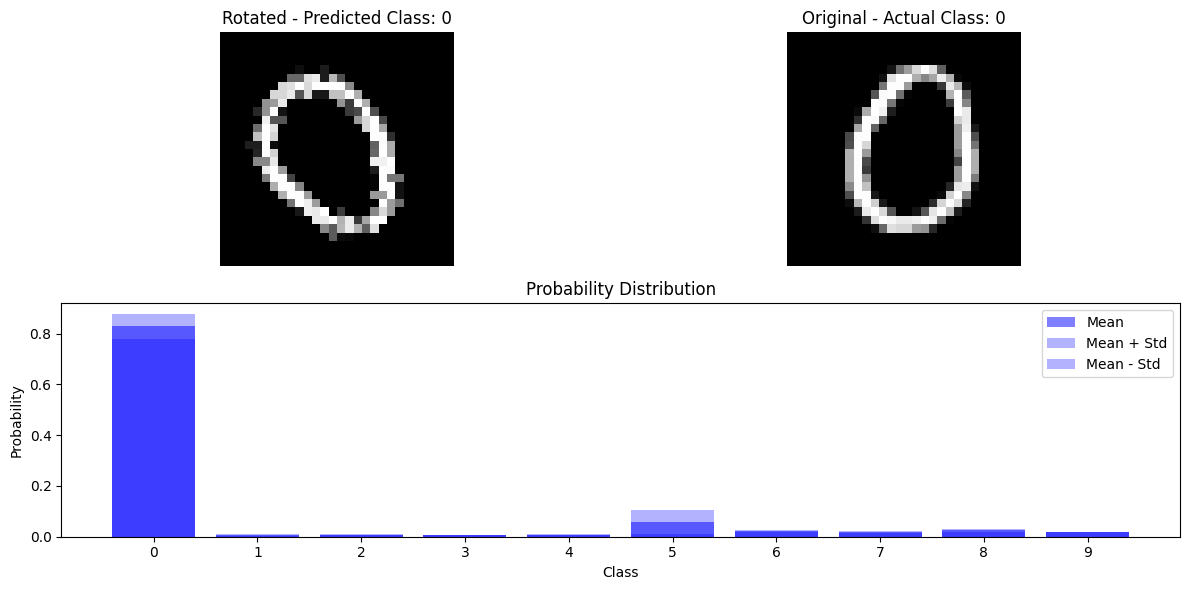

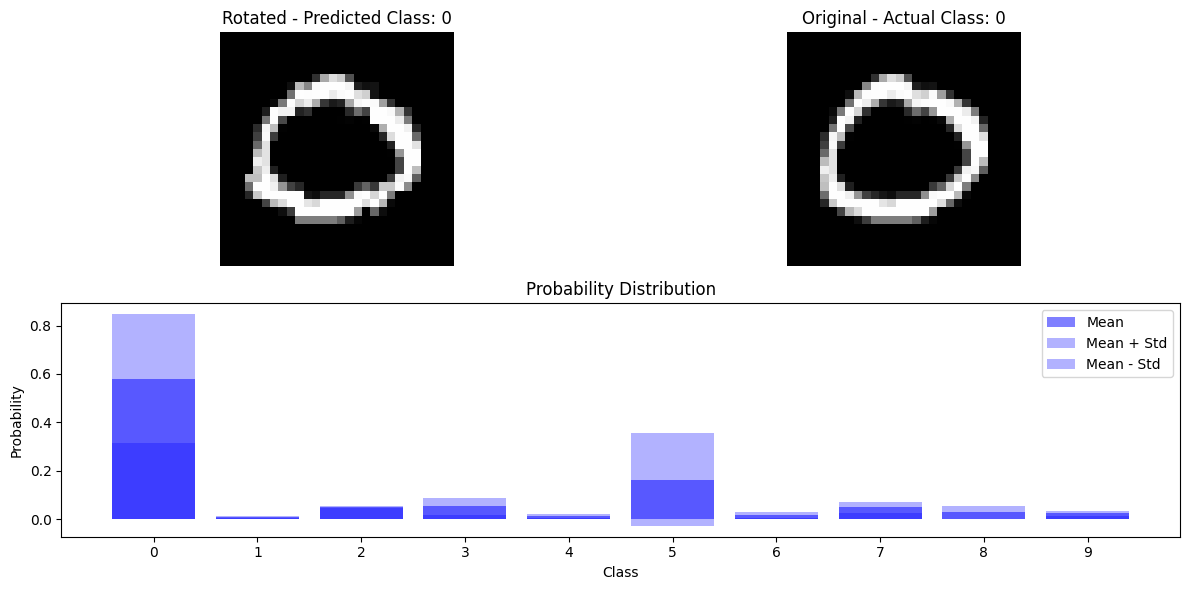

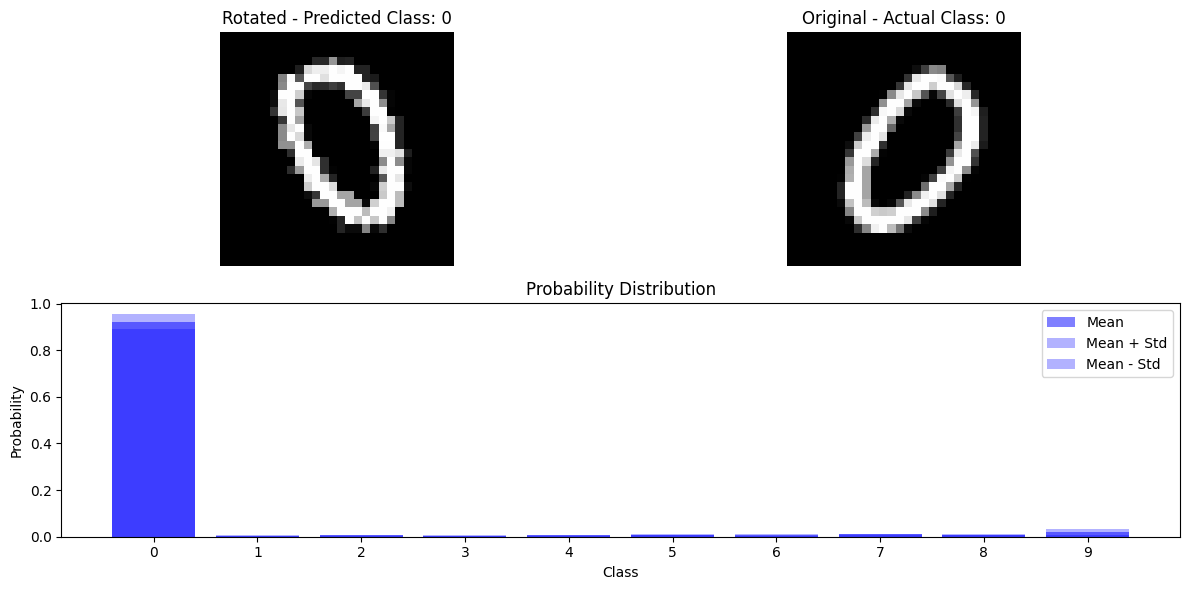

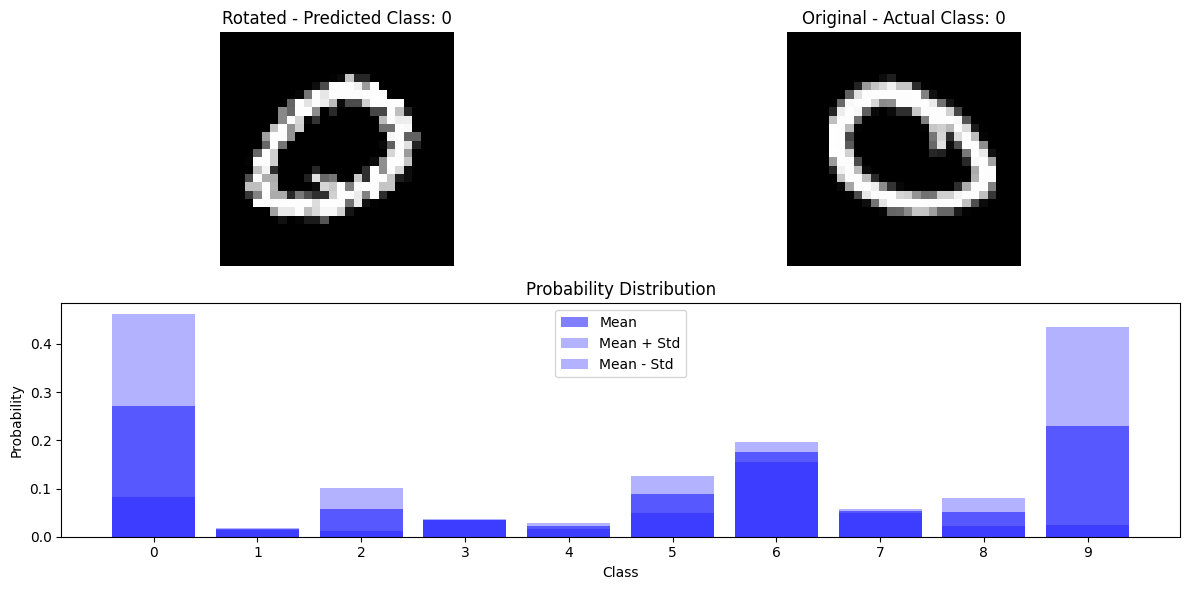

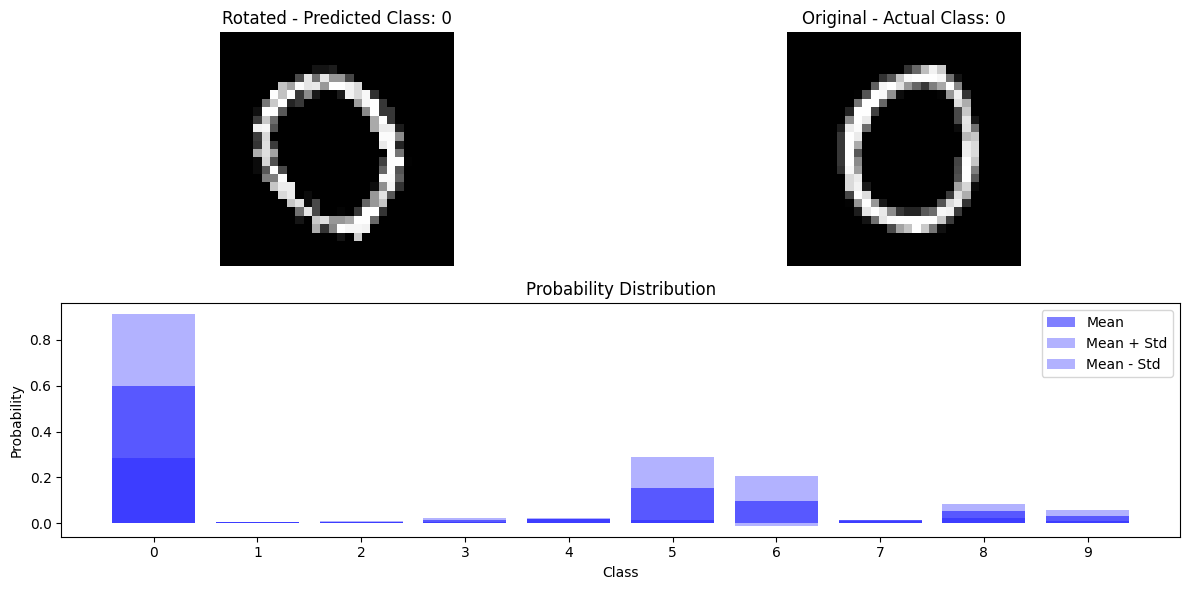

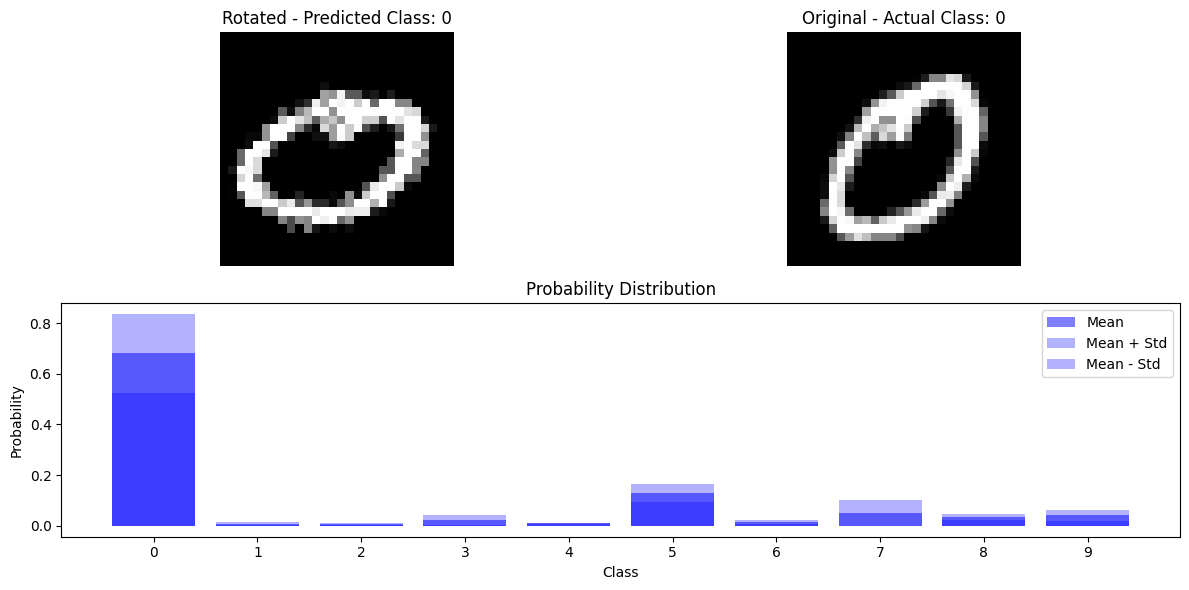

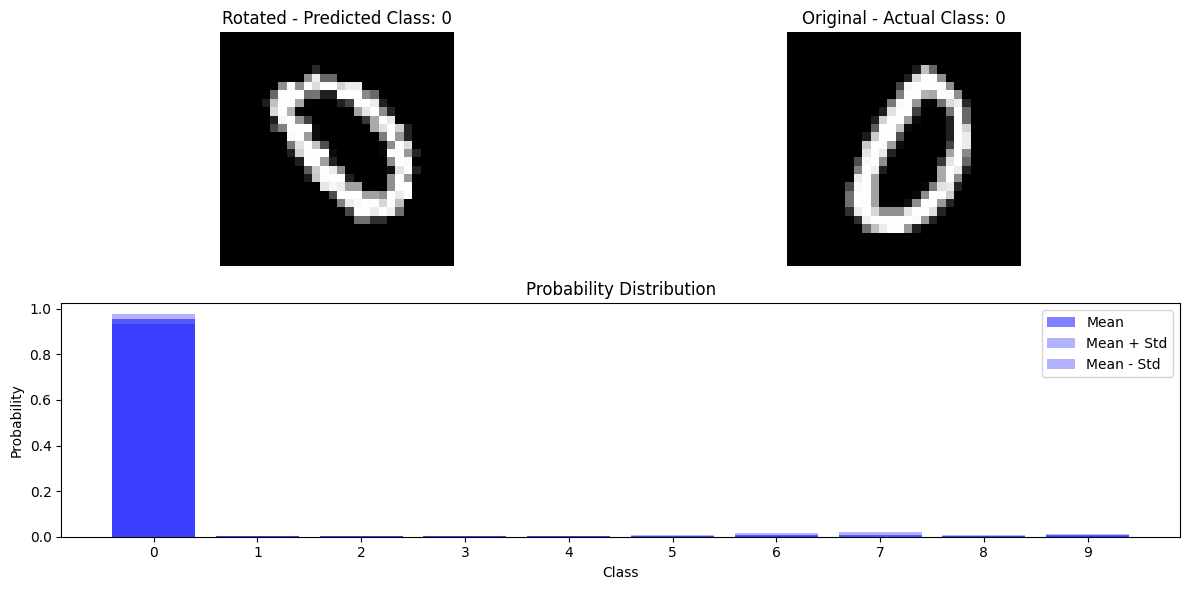

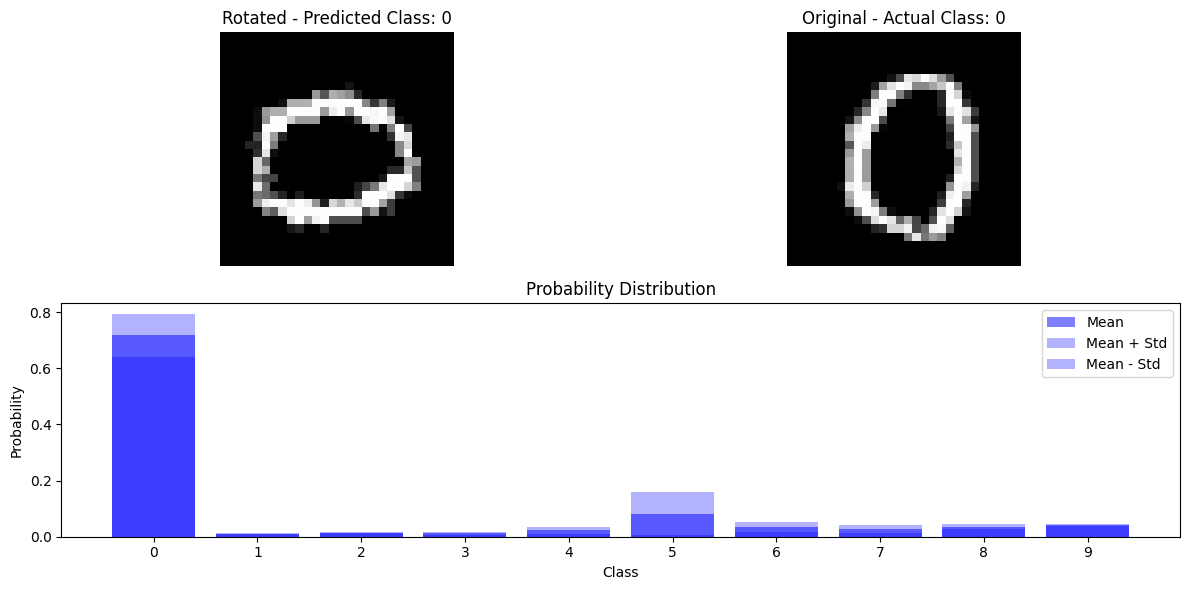

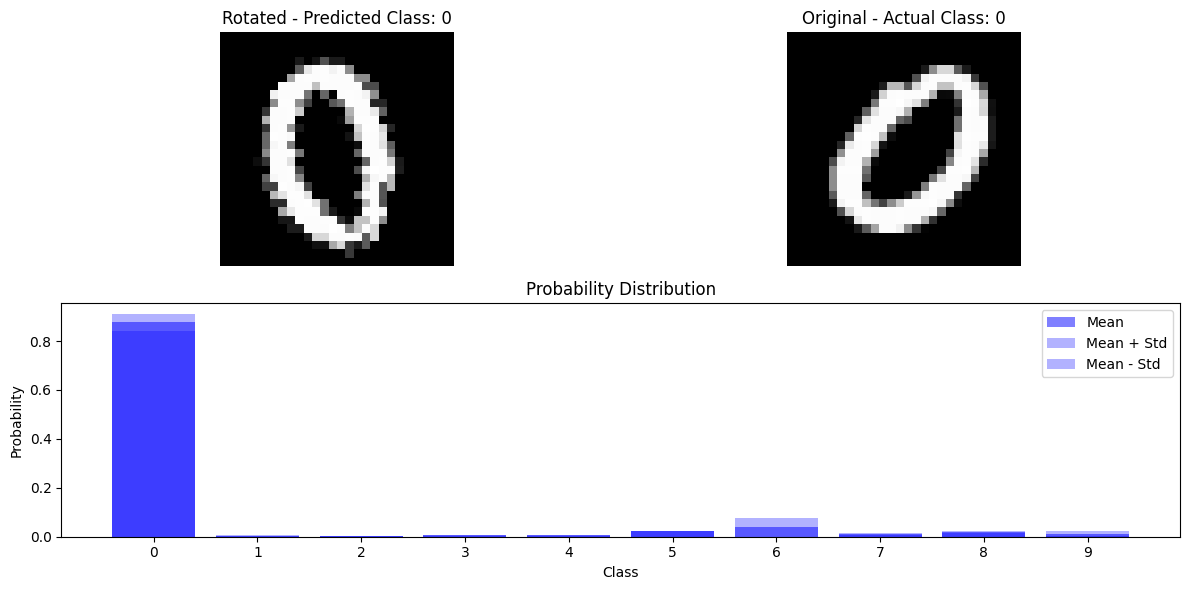

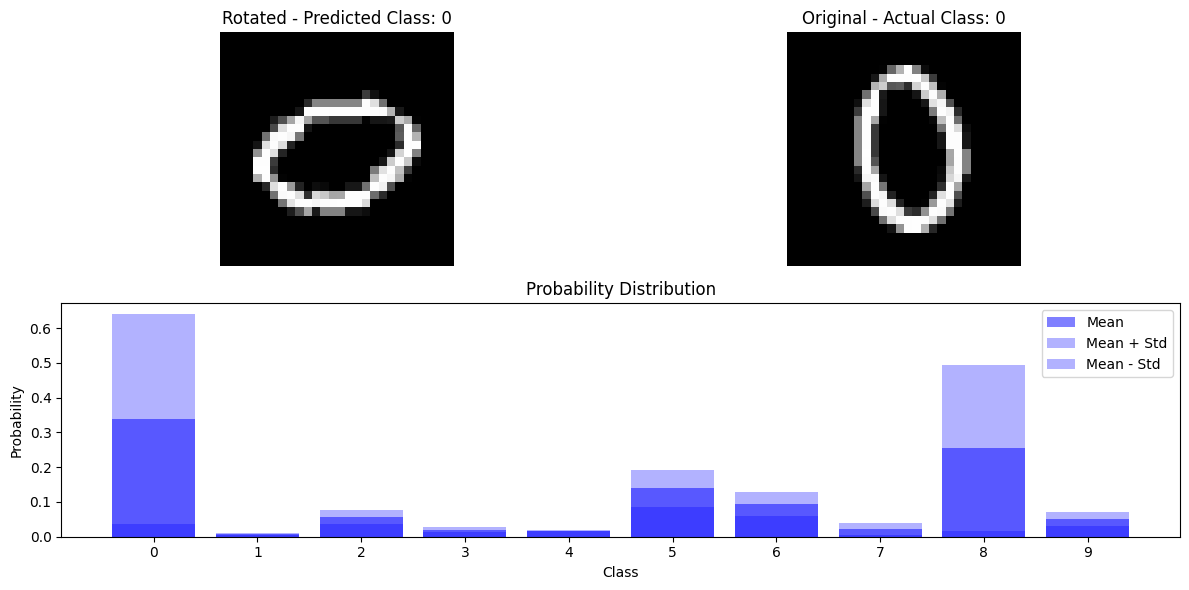

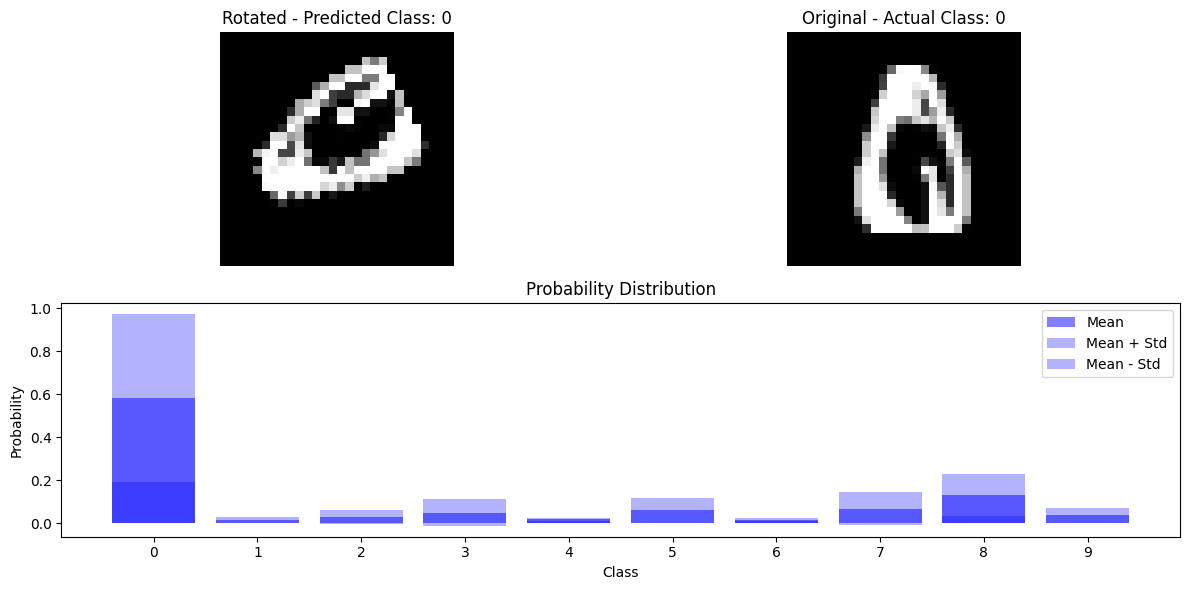

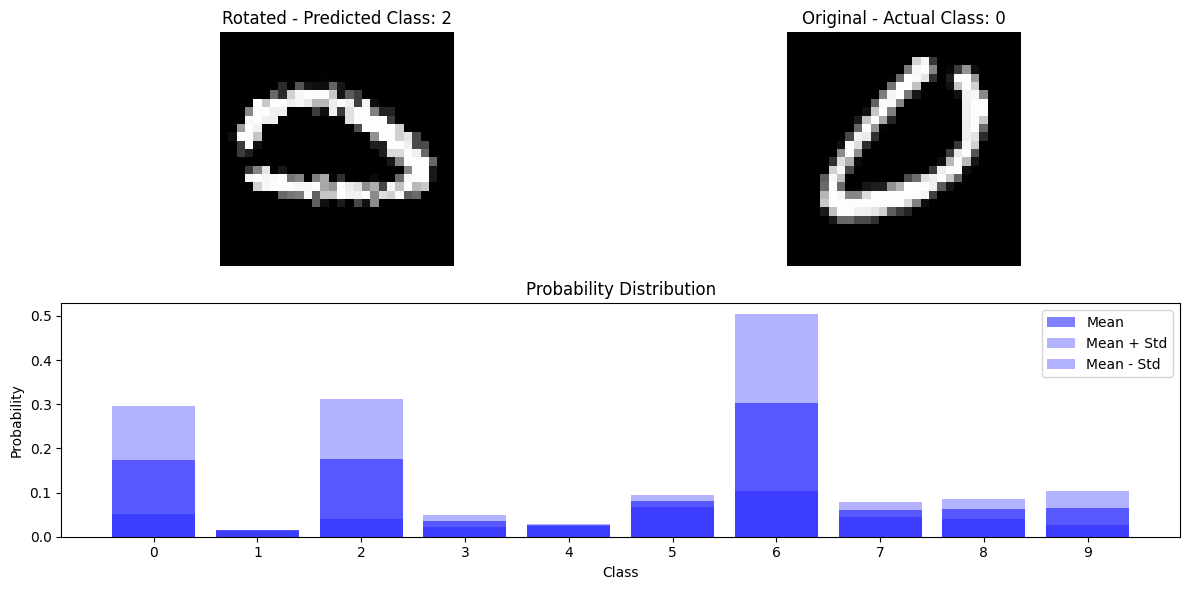

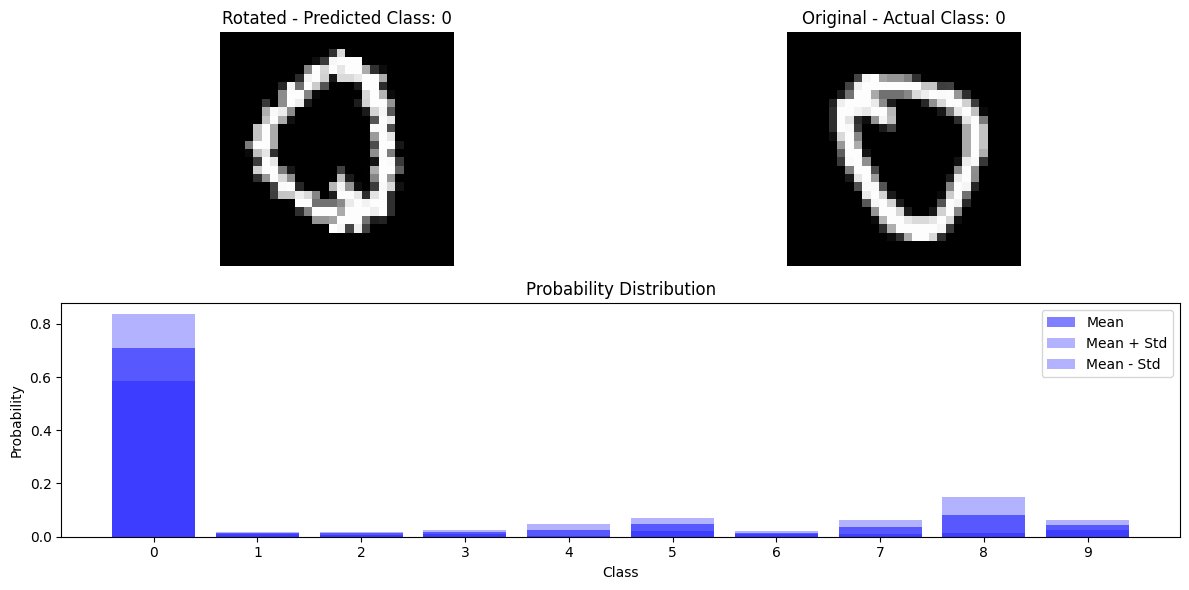

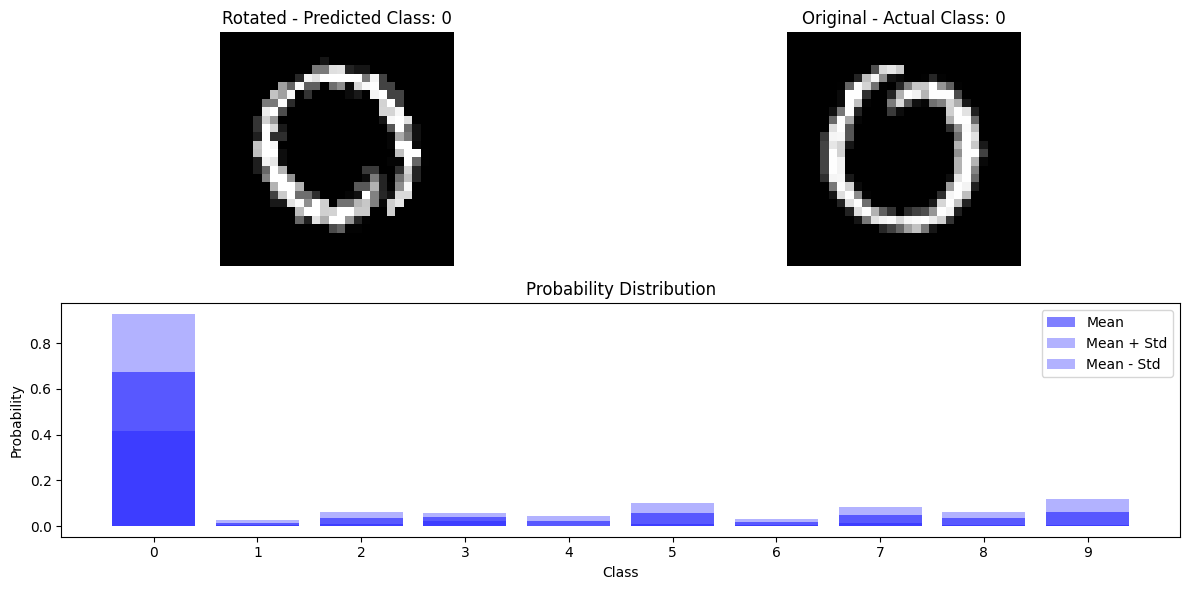

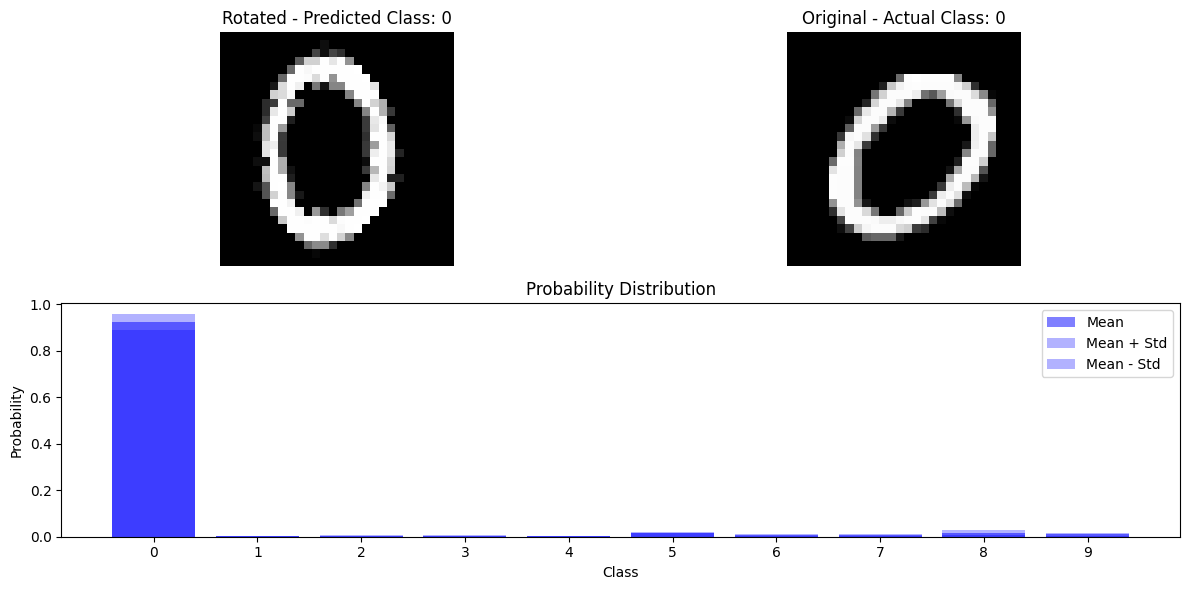

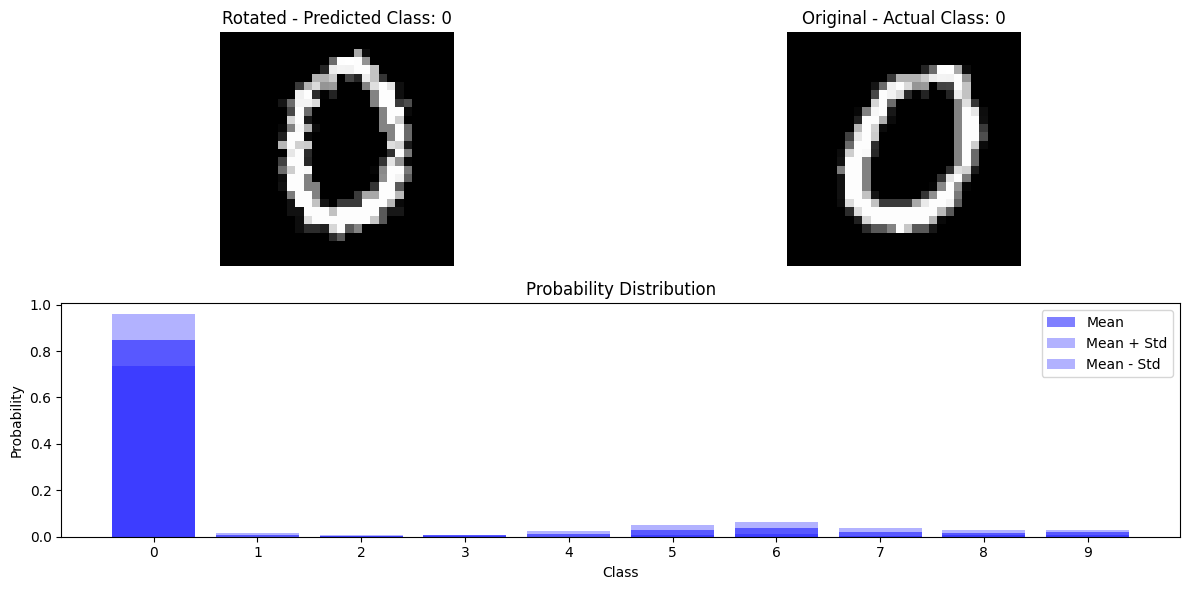

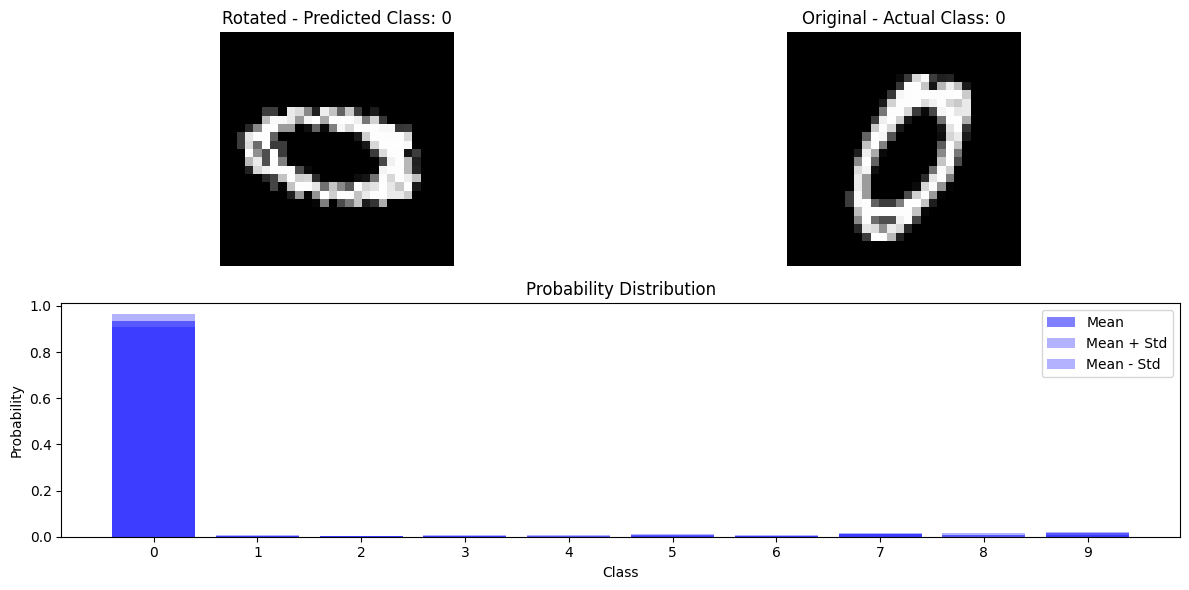

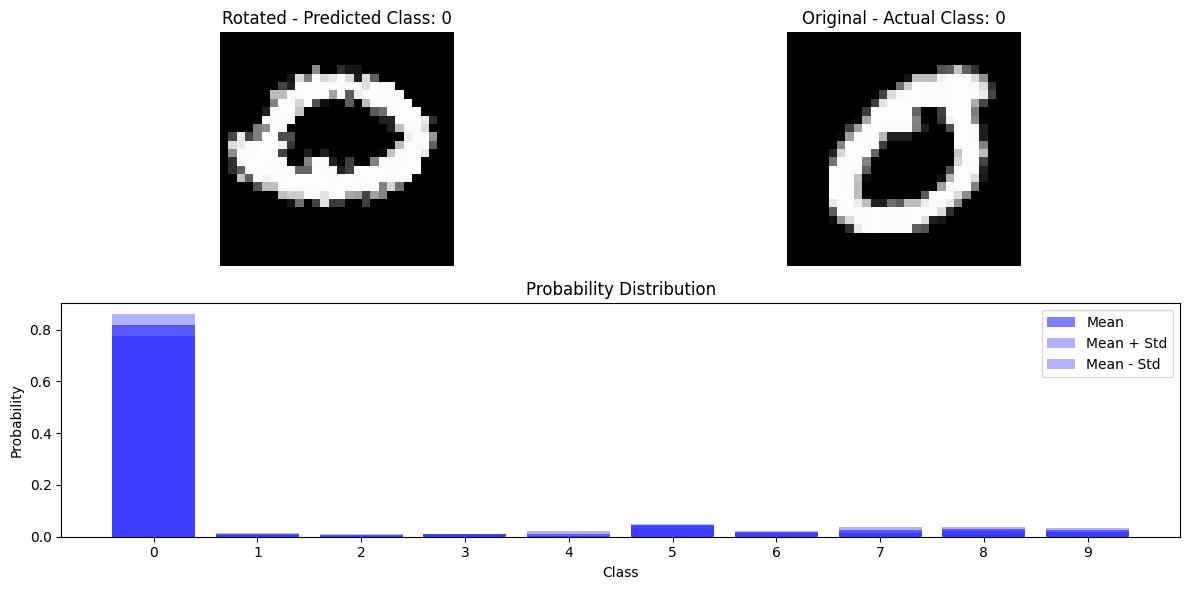

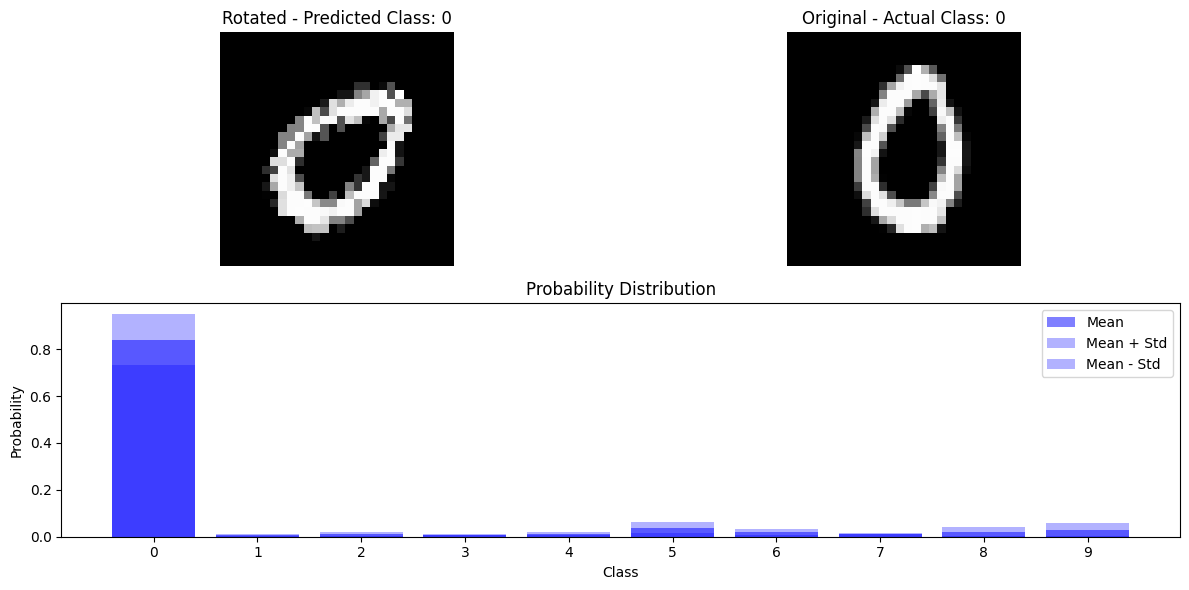

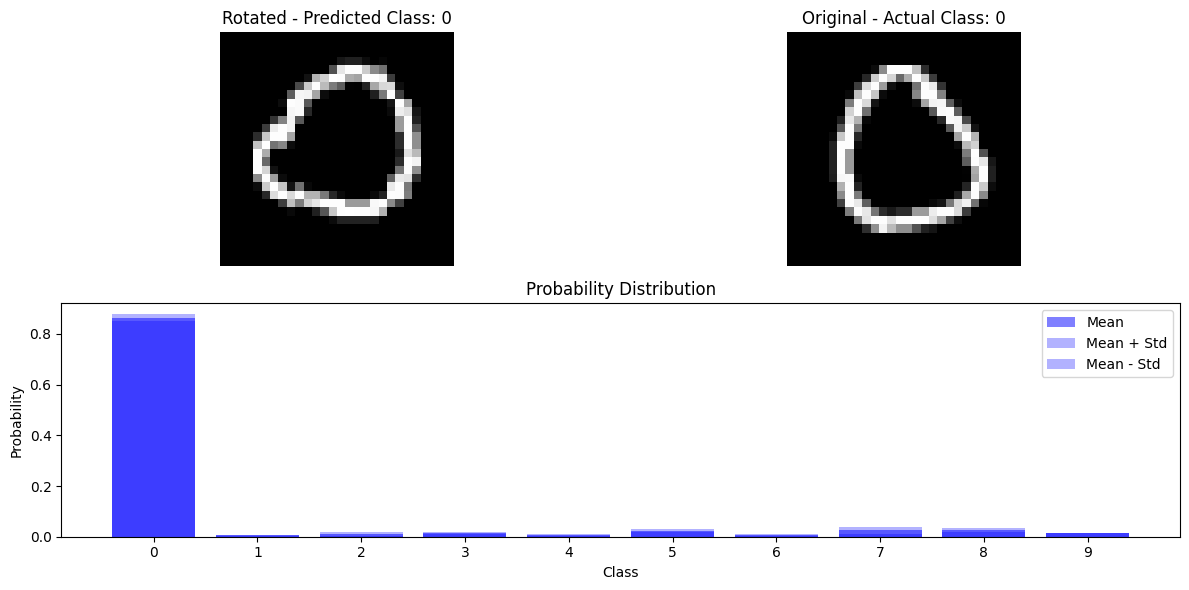

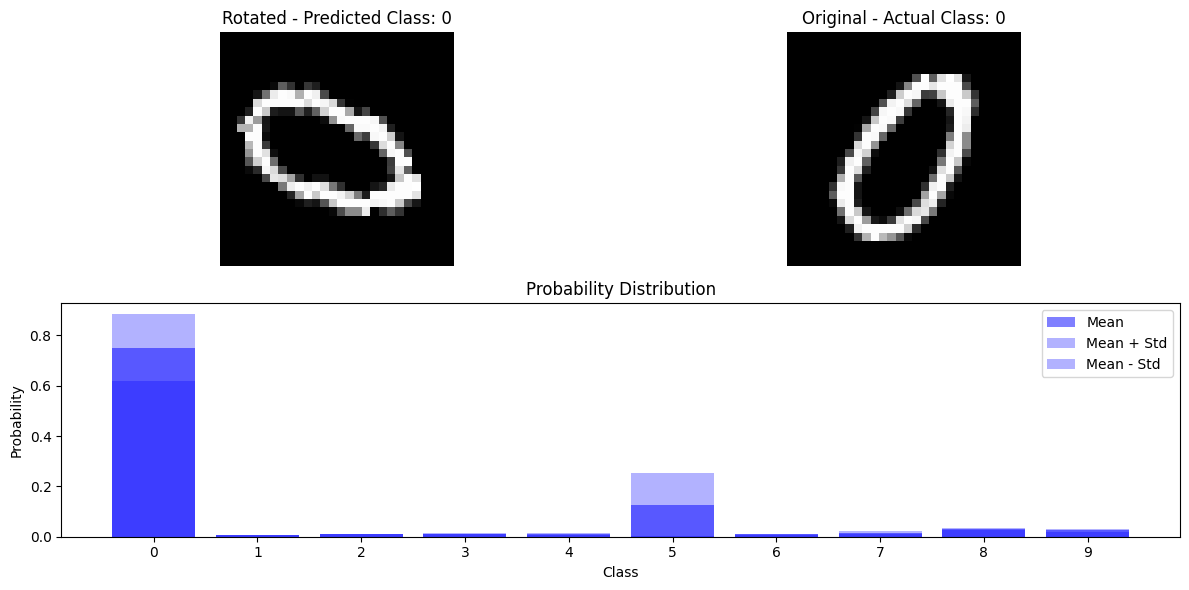

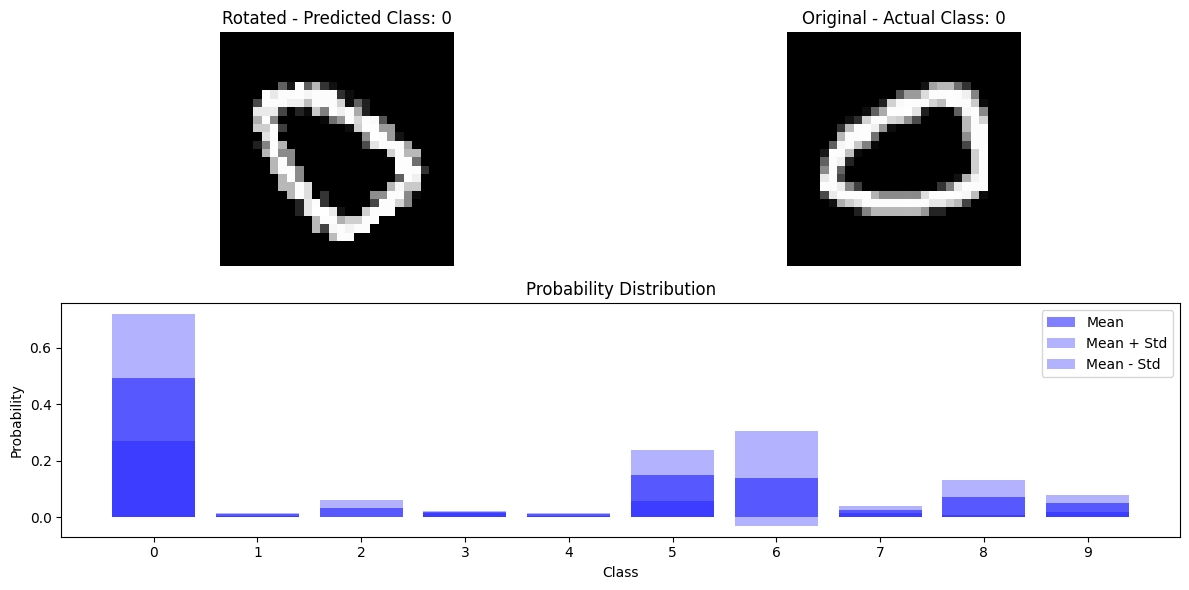

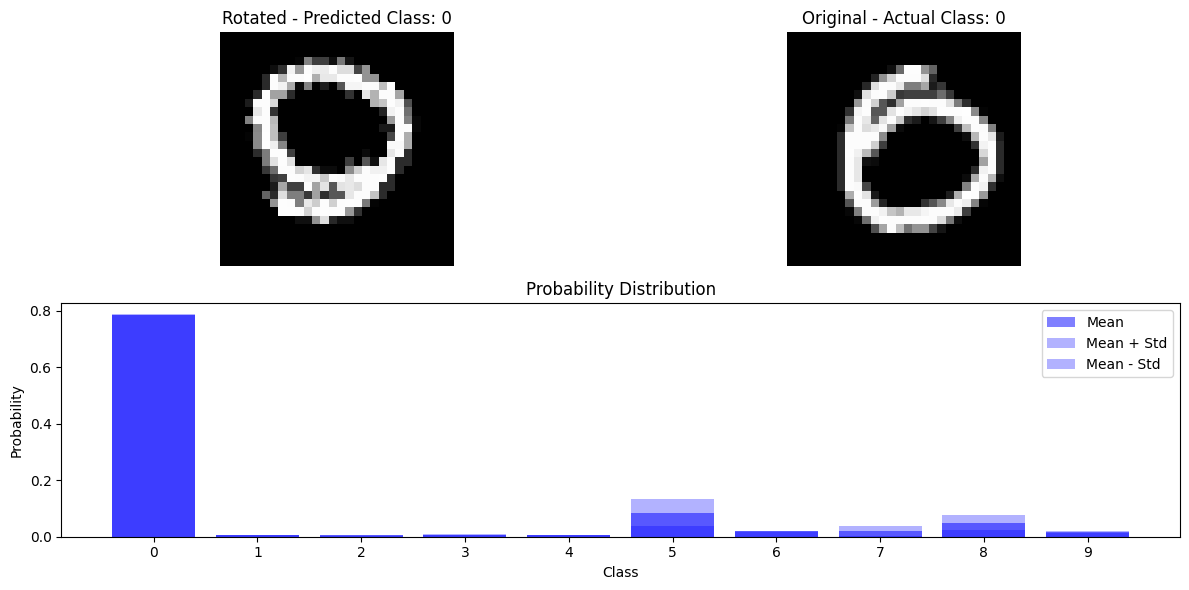

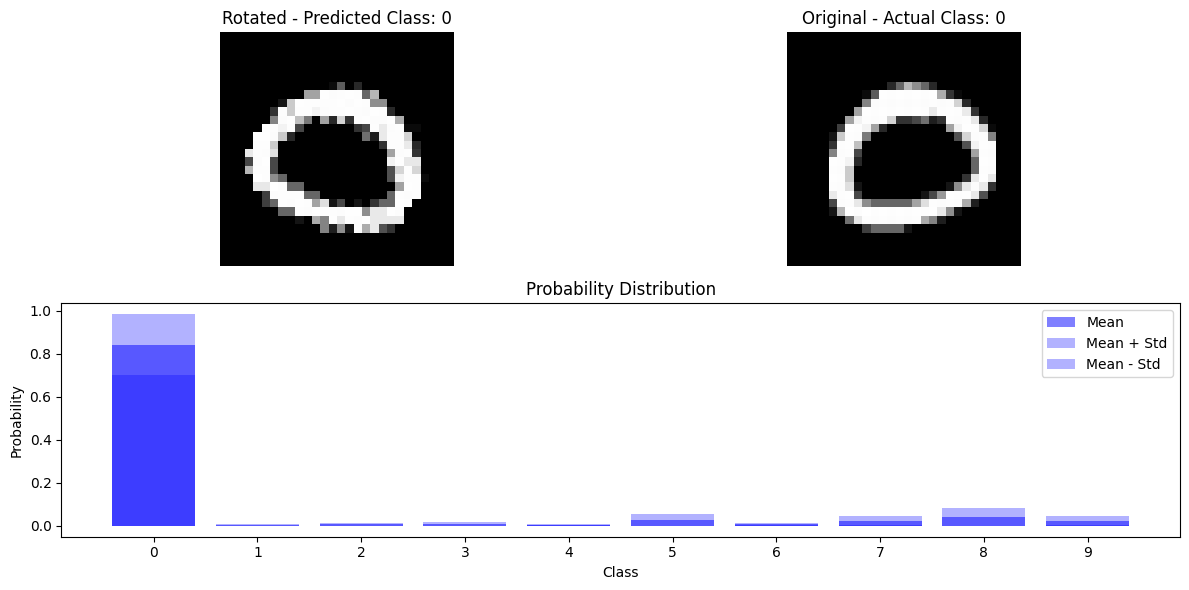

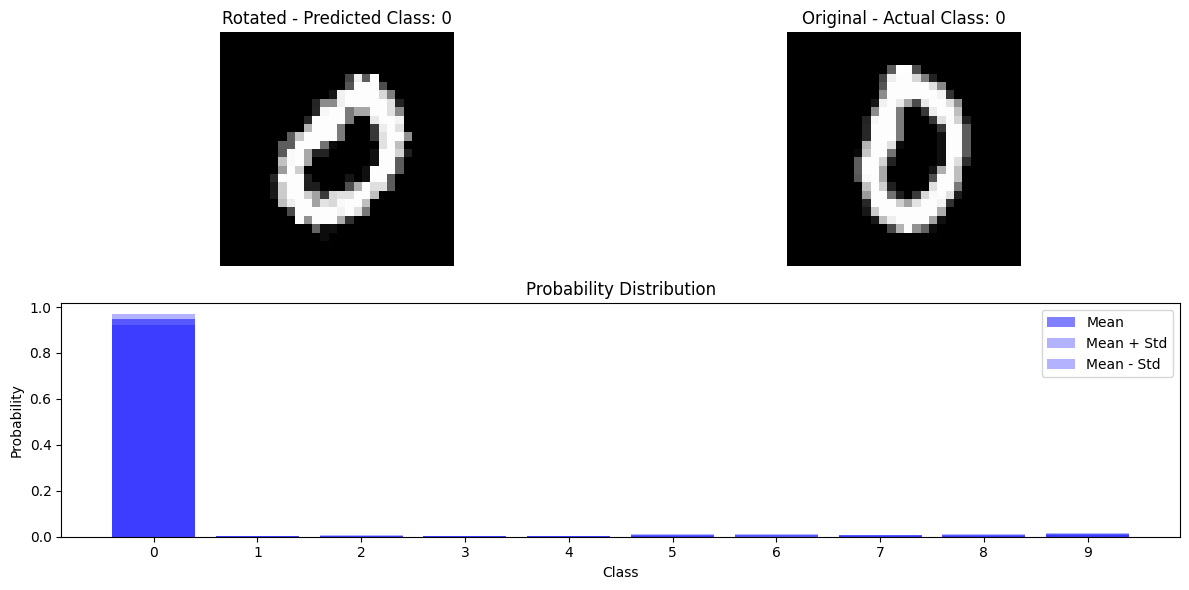

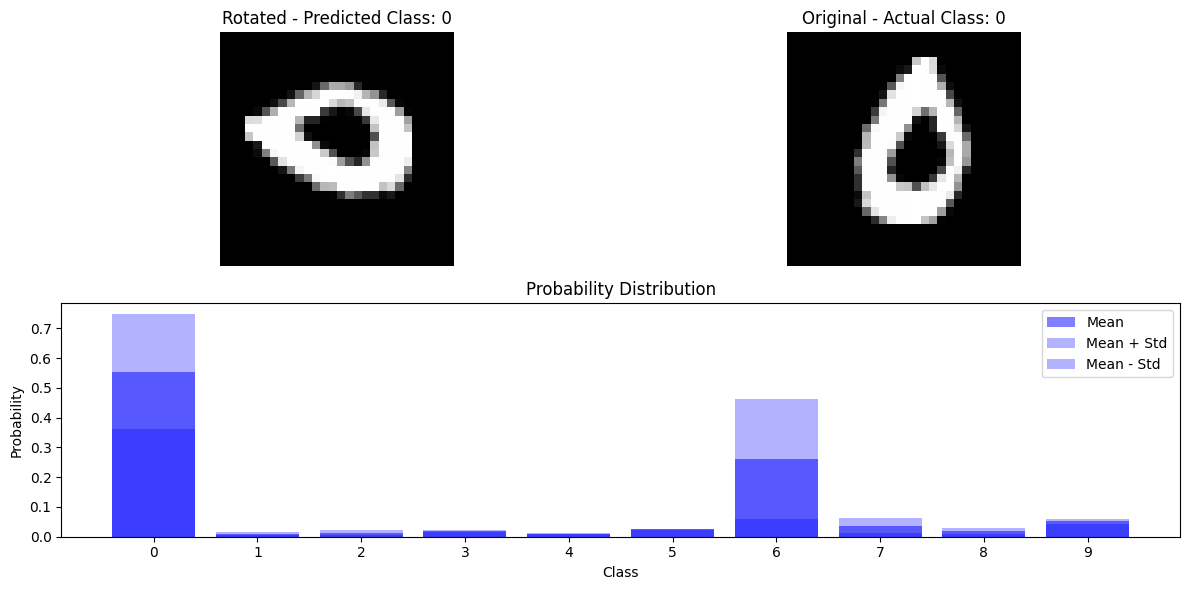

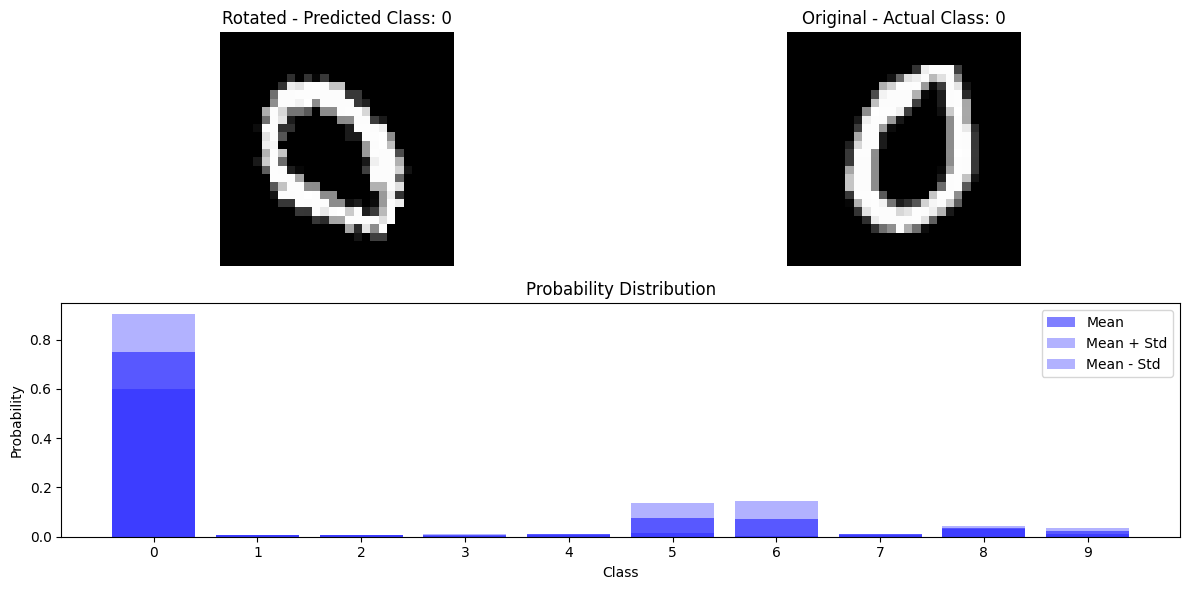

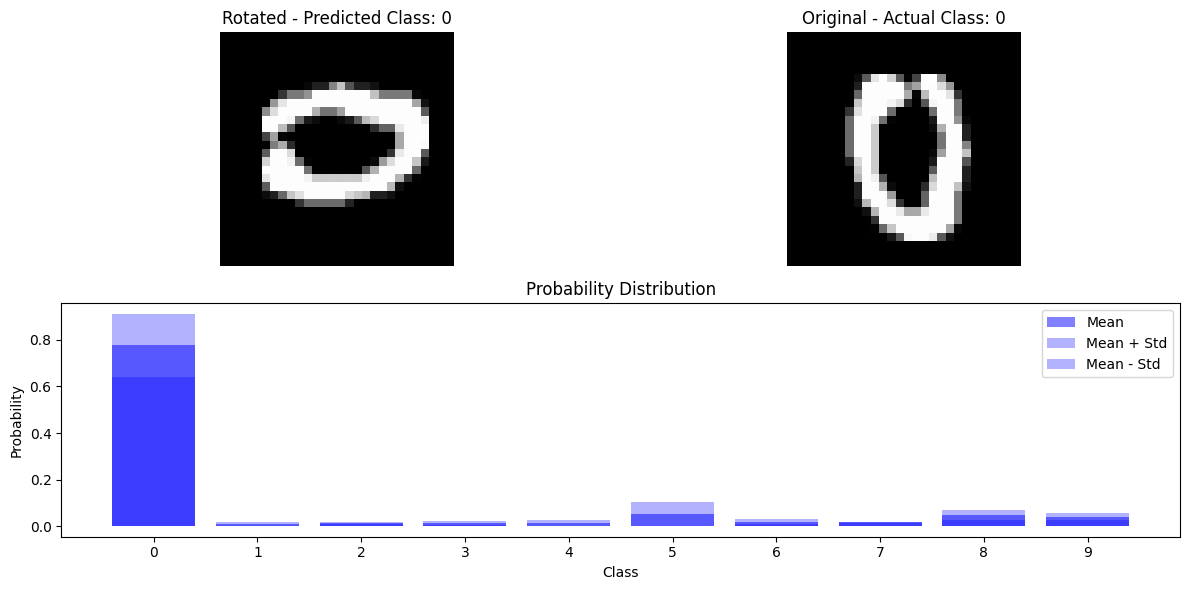

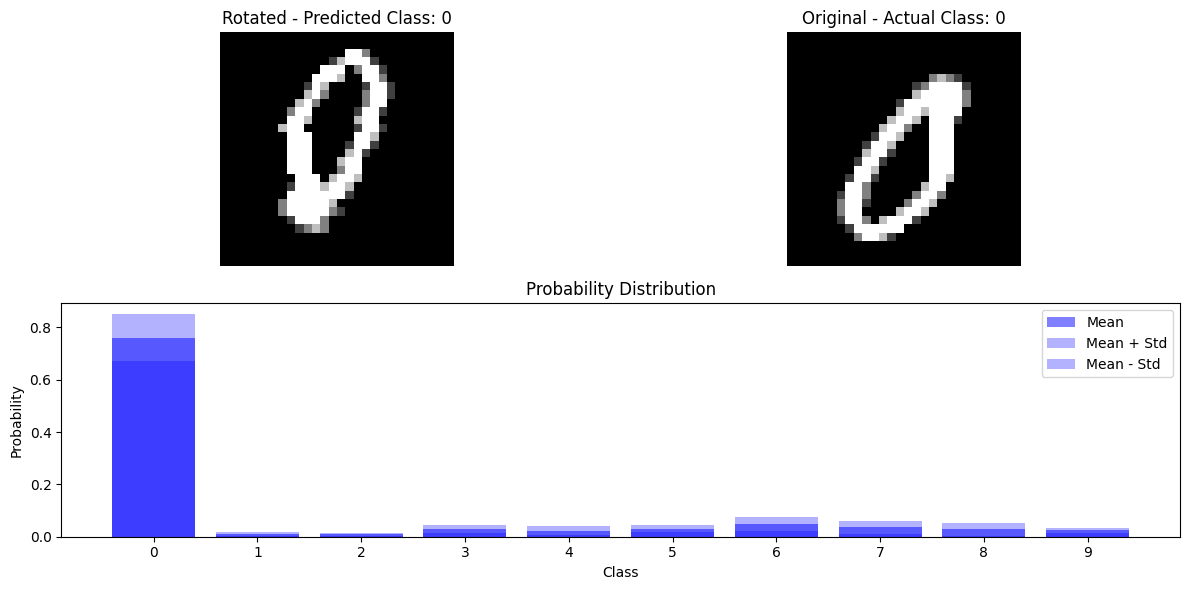

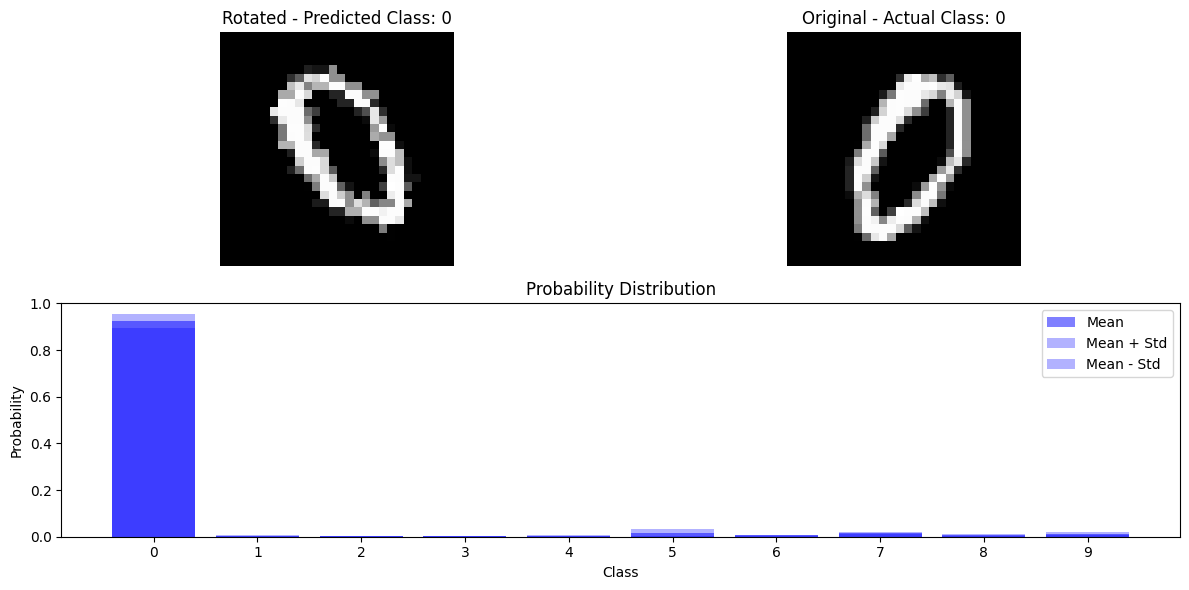

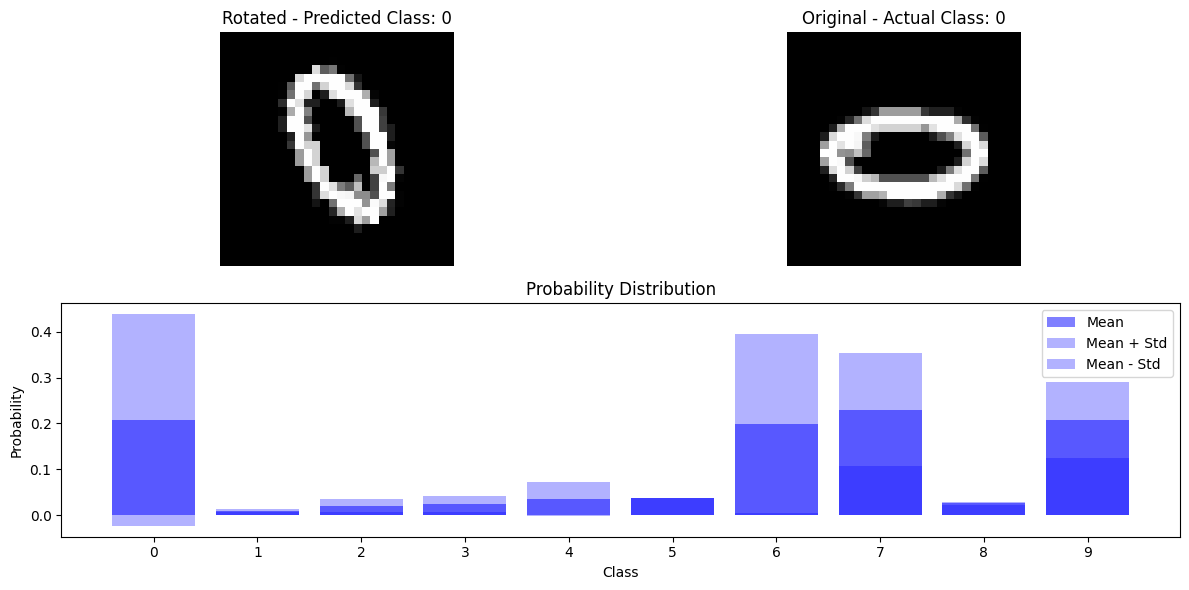

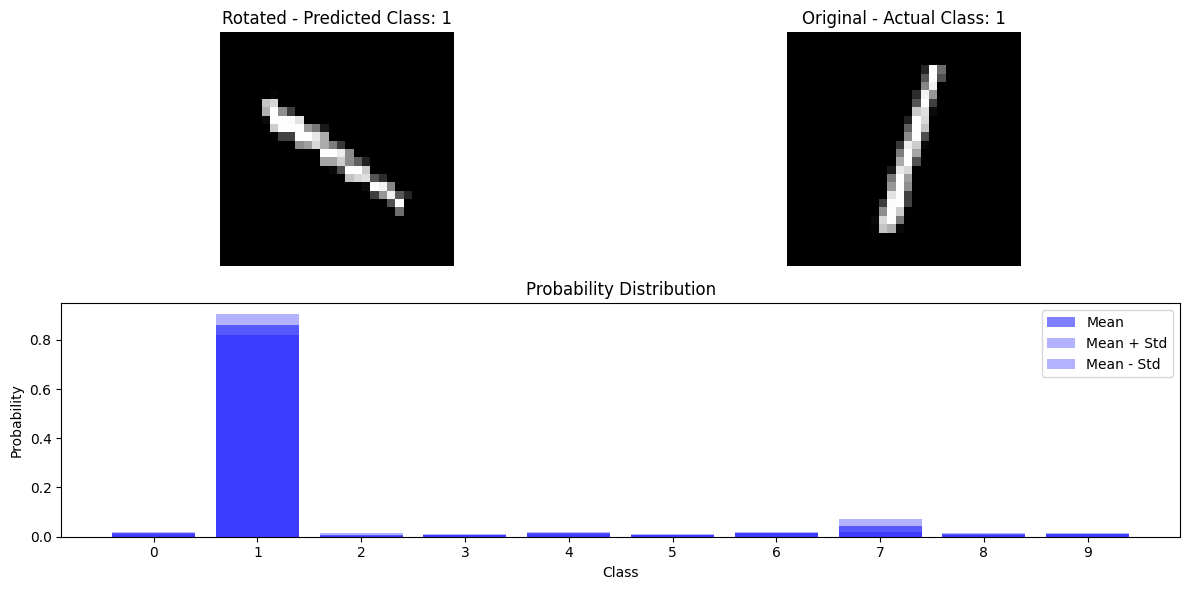

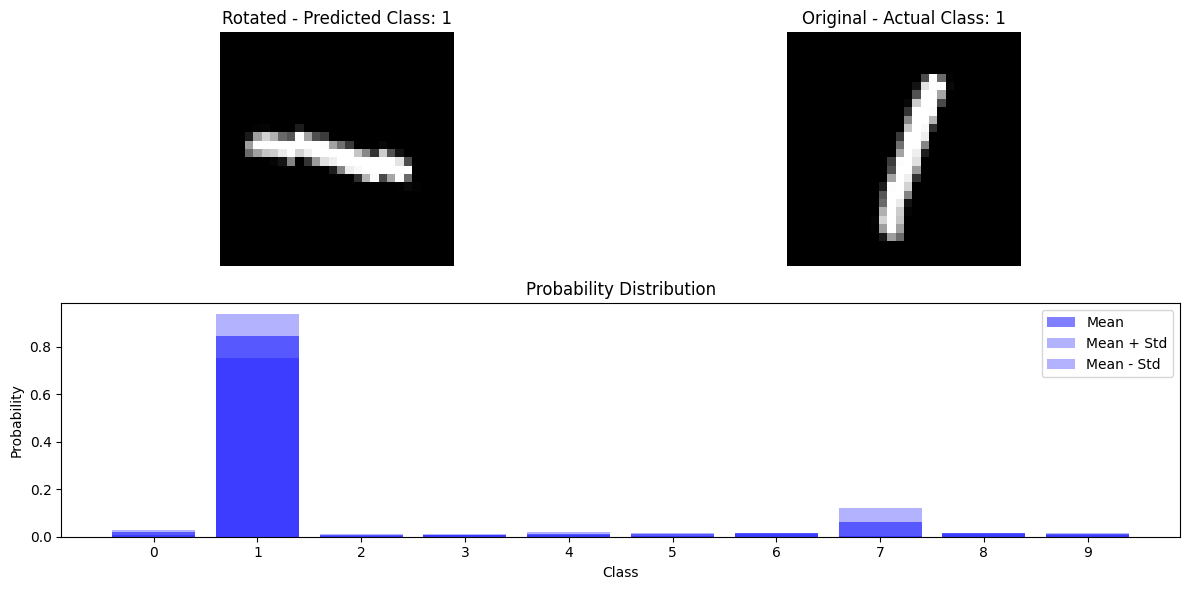

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms

# Assuming you have these variables defined
num_images_to_display = 5
predicted_classes = two_model_outputs["mode"]
probabilities = two_model_outputs["mean_prob"]
std = two_model_outputs["std"]



# Display rotated images
rotated_test_images = DataLoader(rotated_loaded_test_subset, batch_size=num_images_to_display, shuffle=False)
for images, labels in rotated_test_images:
    rotated_images = images
    rotated_labels = labels
    break

test_images = DataLoader(loaded_test_subset, batch_size=num_images_to_display, shuffle=False)
for images, labels in test_images:
    original_images = images
    original_labels = labels
    break



for i in range(num_images_to_display):
    plt.figure(figsize=(12, 6))

    # Plot the rotated image
    plt.subplot(2, 2, 1)
    plt.imshow(rotated_images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Rotated - Predicted Class: {predicted_classes[i]}')
    plt.axis('off')

    # Plot the original image
    plt.subplot(2, 2, 2)
    plt.imshow(original_images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Original - Actual Class: {original_labels[i].item()}')
    plt.axis('off')

    # Display the probability distribution below
    plt.subplot(2, 1, 2)
    plt.bar(np.arange(0, 10), probabilities[i].numpy(), color='blue', alpha=0.5, label='Mean')
    plt.bar(np.arange(0, 10), probabilities[i]+std[i], color='blue', alpha=0.3, label='Mean + Std')
    plt.bar(np.arange(0, 10), probabilities[i]-std[i], color='blue', alpha=0.3, label='Mean - Std')
    plt.title("Probability Distribution")
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.xticks(np.arange(0, 10))
    plt.legend()

    plt.tight_layout()
    plt.show()
